This is part of the blog series for Object Detection with R-CNN.

<img src="https://media.giphy.com/media/61Rem8VlsANGpByXBu/giphy.gif" width="1000">

In this blog, we will review the selective sarch algorithm.
The selective search is one of the most successful category-independent region proposal algorithms, and R-CNN also uses selective search to find region proposal. 


[J.R.R. Uijlings et al](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf) take a hierarchical grouping algorithm to form the basis of 
selective search, and first apply [fast segmentation method of Felzenszwalb and Huttenlocher](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf) to create smallest partition of images called "initial regions". Then selective search later uses a greedy algorithm to iteratively
group regions together. 


So, roughly speaking, the selective search has two steps:

- Step 1: Create initial regions by Felzenszwalb’s efficient graph based segmentation algorithm
- Step 2: Group regions based on various criteria (Local Binary Pattern features and )

I will go over the details of each step one by one. 
The codes here are based a lot on [AlpacaDB/selectivesearch's Github account](https://github.com/AlpacaDB/selectivesearch/blob/develop/selectivesearch/selectivesearch.py). 
So please credit them when you use codes in this blog. 

## Reference
- [Region Proposals tutorial in Coursera from Andrew Ng](https://es.coursera.org/lecture/convolutional-neural-networks/optional-region-proposals-aCYZv)
- ["Selective Search for Object Recognition" by J.R.R. Uijlings et al.](http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)
- [AlpacaDB/selectivesearch](https://github.com/AlpacaDB/selectivesearch/blob/develop/selectivesearch/selectivesearch.py)
- [Efficient graph-based image segmentation, Felzenszwalb, P.F. and Huttenlocher, D.P. International Journal of Computer Vision, 2004](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf)
- [Shih-Shinh Huang's youtube tutorial: quarter DIP Efficient Graph Based Image Segmentation](https://www.youtube.com/watch?v=iDKeR_swA8g)




### Reference: "Object Detection with R-CNN" series in my blog
- [Part 1: Object Detection with Pascal VOC2012 - data preparation and understanding](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html)


- [Part 2: Object Detection with Pascal VOC2012 - R-CNN overview](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_RCNN_overview.html)


- [Part 3: Object Detection with Pascal VOC2012 - Selective Search](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_selective_search.html)
    - [Implement Local Binary Pattern Descriptor from scratch](https://fairyonice.github.io/implement-lbp-from%20scratch.html)
    
    
- [Part 4: Object Detection with Pascal VOC2012 - CNN feature extraction](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_cnn_feature_extraction.html)


- [Part 5: Object Detection with Pascal VOC2012 - Inference with your own image!](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_inference.html)

In [1]:
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.misc
import skimage.segmentation
import skimage.feature
from copy import copy

## This must be the location of the PASCAL VOC data. 
img_dir          = "VOCdevkit/VOC2012/JPEGImages"

# Step 1: Create initial regions by Felzenszwalb’s efficient graph based segmentation algorithm

J.R.R. Uijlings's graph segmentation is an unsupervised method to partition the image into several regions. 
It uses the graph representation of an image.
In graph formulation, each pixel intensity is vertice and the pair of the adjacent pixels is edge (See Figure that 
I took from [Shih-Shinh Huang's youtube tutorial: quarter DIP Efficient Graph Based Image Segmentation](https://www.youtube.com/watch?v=iDKeR_swA8g)).

Weight measures the strength of the edge, and the absolute difference of intensities is used as a weight.
Then the pixels should be combined into the same group with the idea that: 

- edges between two vertices in the same group should have lower weights
- edges between two vertices in the different group should have higher weights 

![Shih-Shinh Huang's youtube tutorial](https://farm5.staticflickr.com/4873/44926733935_eae0a6373d_k.jpg)
(Credit: [Shih-Shinh Huang's youtube tutorial: quarter DIP Efficient Graph Based Image Segmentation](https://www.youtube.com/watch?v=iDKeR_swA8g))

Thankfully, [skimage.segmentation: Comparison of segmentation and superpixel algorithms](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py) already implemented Felzenszwalb and Huttenlocher's segmentation algorithm. 
So we will use this implemented algorithm. 

Let's try it out and visualize the segmented images.
The following codes randomly select 5 frames from PASCAL data and visualize its original image and segmented image.

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


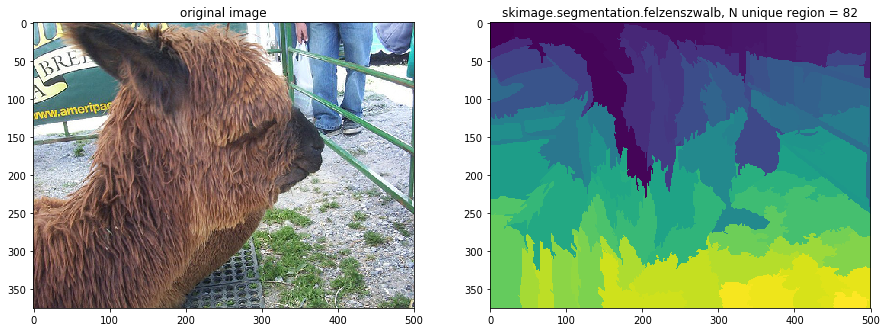

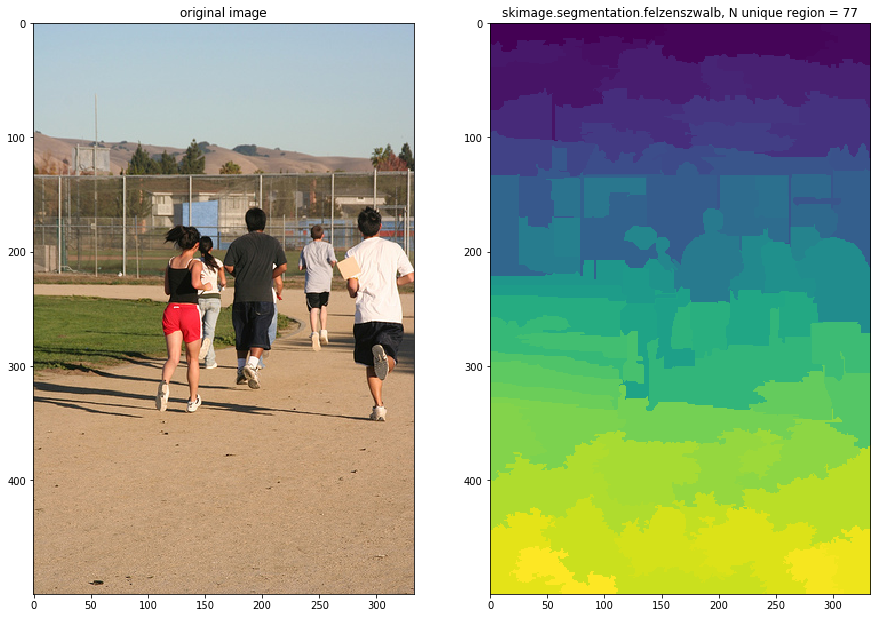

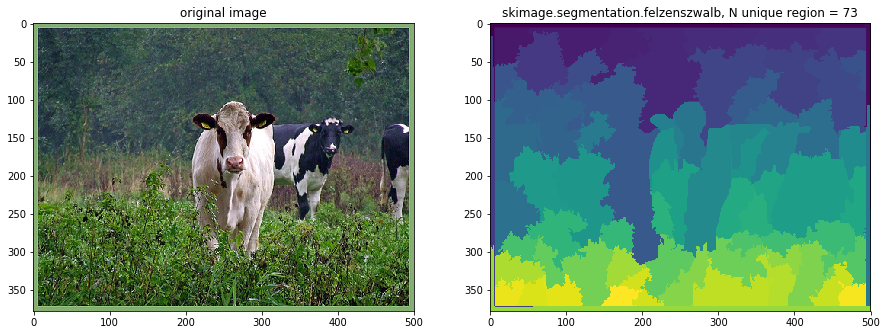

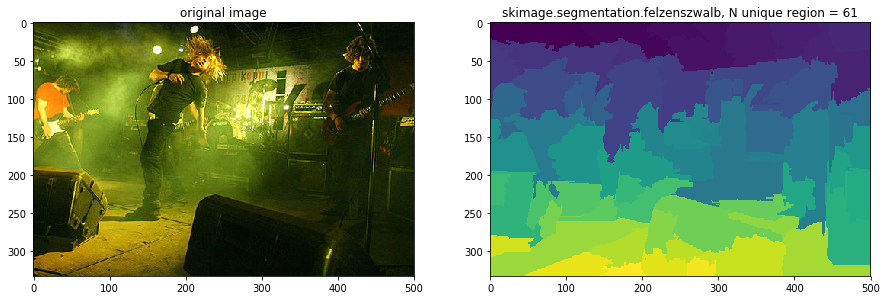

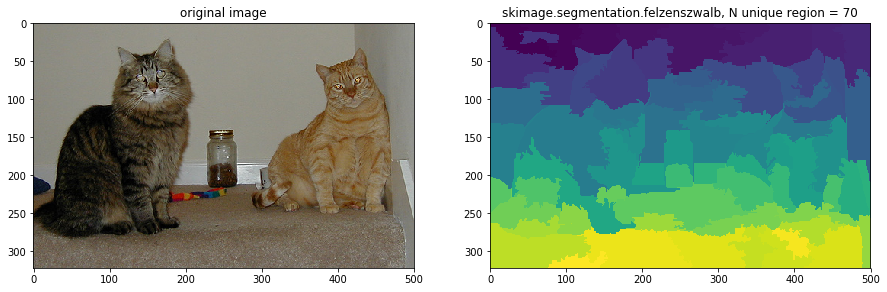

In [2]:


def image_segmentation(img_8bit, scale = 1.0, sigma = 0.8, min_size = 50):
    '''
    J.R.R. Uijlings's hierarchical grouping algorithm 
    
    == input ==
    img_8bit : shape = (height, width, 3),
               8-bits degital image (each digit ranges between 0 - 255)
    
    == output ==
    img      : shape = (height, width, 4)
    '''
    # convert the image to range between 0 and 1
    img_float = skimage.util.img_as_float(img_8bit)
    im_mask   = skimage.segmentation.felzenszwalb(
                    img_float, 
                    scale    = scale, 
                    sigma    = sigma,
                    min_size = min_size)
    img       = np.dstack([img_8bit,im_mask])
    return(img)

scale    = 1.0
sigma    = 0.8
# min_size may be around 50 for better RCNN performance but for the sake of visualization, I will stick to min_size =500
min_size = 500 # 500 3000

np.random.seed(4)
listed_path = os.listdir(img_dir)
Nplot = 5
random_img_path = np.random.choice(listed_path,Nplot)
for imgnm in random_img_path:
    # import 8 bits degital image (each digit ranges between 0 - 255)
    img_8bit  = scipy.misc.imread(os.path.join(img_dir,imgnm))
    img       = image_segmentation(img_8bit, scale, sigma, min_size)
    
    fig = plt.figure(figsize=(15,30))
    ax  = fig.add_subplot(1,2,1)
    ax.imshow(img_8bit)
    ax.set_title("original image")
    ax  = fig.add_subplot(1,2,2)
    ax.imshow(img[:,:,3])
    ax.set_title("skimage.segmentation.felzenszwalb, N unique region = {}".format(len(np.unique(img[:,:,3]))))
    plt.show()

Now I will extract as many rectangle regions as the number of the regions found by the segmentation algorithm.
Each rectangle region is selected to be the smallest rectangle region covering the entire segmented region.

In [3]:
def extract_region(img):
    '''
    For each segmented region,
    extract smallest rectangle regions covering the smallest segmented region.
    
    == input ==
    img : (height, width, N channel)
          N channel = [R, G, B , L], L = label for the region
          only the L channel is used in this analysis 
    == output ==
    
    dictionary R :
    
    {0: {'labels': [0], 'max_x': 131, 'max_y': 74, 'min_x': 0,   'min_y': 0},
     1: {'labels': [1], 'max_x': 189, 'max_y': 37, 'min_x': 75,  'min_y': 0},
     2: {'labels': [2], 'max_x': 282, 'max_y': 38, 'min_x': 162, 'min_y': 0},
     3: {'labels': [3], 'max_x': 499, 'max_y': 23, 'min_x': 247, 'min_y': 0},
     4: {'labels': [4], 'max_x': 499, 'max_y': 74, 'min_x': 428, 'min_y': 13},
     5: {'labels': [5], 'max_x': 441, 'max_y': 76, 'min_x': 333, 'min_y': 16},
     6: {'labels': [6], 'max_x': 348, 'max_y': 80, 'min_x': 62,  'min_y': 21},
    '''
    ## only use the segmentation output
    img_segment = img[:,:,3]
    R = {}
    for y, i in enumerate(img_segment): ## along vertical axis 

        for x, l in enumerate(i): ## along horizontal axis
            # initialize a new region
            if l not in R:
                R[l] = {"min_x": np.Inf, 
                        "min_y": np.Inf,
                        "max_x": 0, 
                        "max_y": 0, 
                        "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y
    ## remove region if it does not have positive height or positive width
    
    Rcopy = copy(R)
    for key in R.keys():
        r = R[key]
        if (r["min_x"] == r["max_x"]) or (r["min_y"] == r["max_y"]):
            del Rcopy[key]
    return(Rcopy)
R = extract_region(img)
print("{} rectangle regions are found".format(len(R)))

70 rectangle regions are found


## Visualize the initial rectangle regions from the segmentation method of Felzenszwalb and Huttenlocher
Let's visualize the regions found by the segmentation method of Felzenszwalb and Huttenlocher.
Can we use these regions as final region proposal for RCNN? Not quite yet. Despite that there are 70 regions, none of these regions capture cats while one of the region seems to capture the bin. 

You may try to increase min_size to obtain bigger regions but then it will make the region for bin too large.
Try min_size = 3000, for example. It will yield a perfect region for right cat but then you will use the region for the bin.

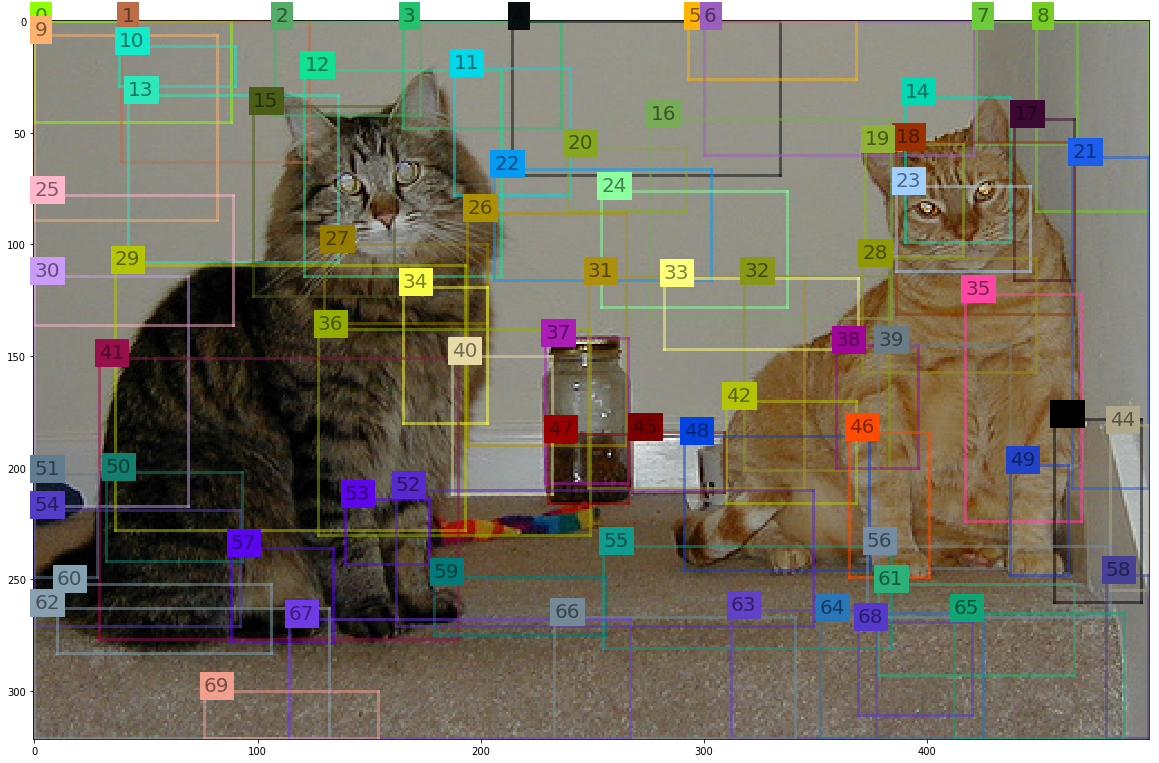

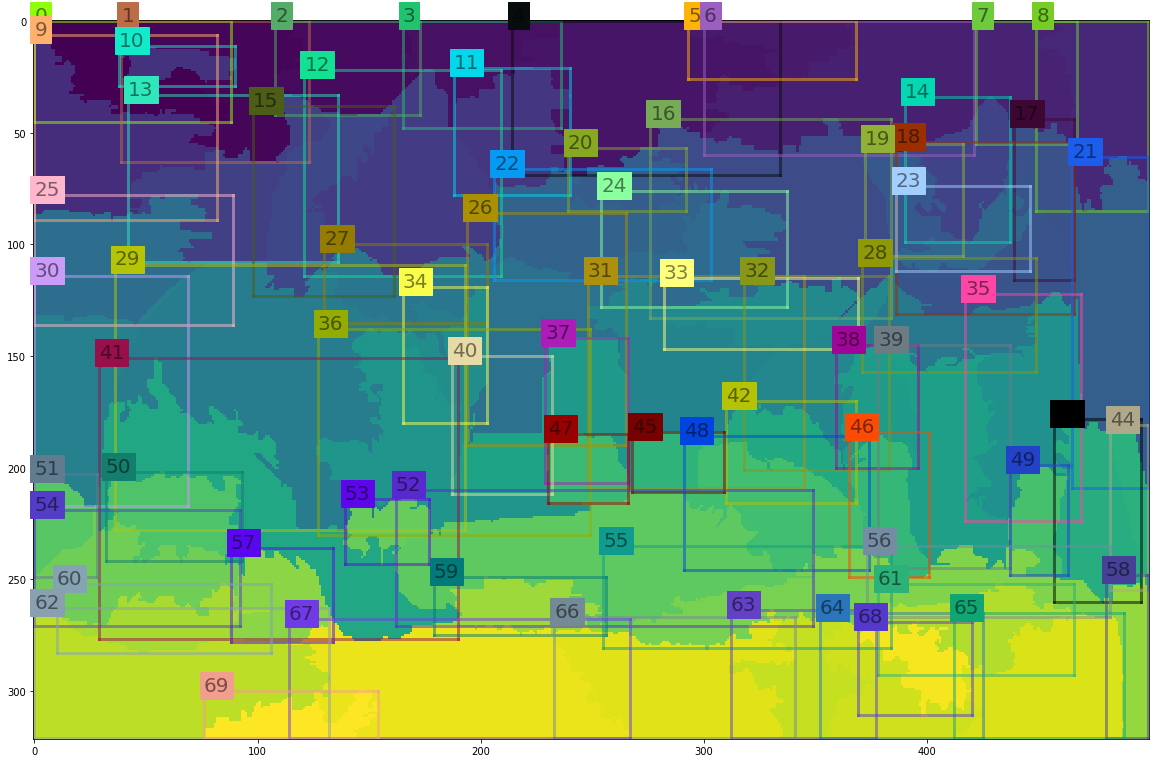

In [4]:
def plt_rectangle(plt,label,x1,y1,x2,y2,color = "yellow", alpha=0.5):
    linewidth = 3
    if type(label) == list:
        linewidth = len(label)*3 + 2
        label = ""
        
    plt.text(x1,y1,label,fontsize=20,backgroundcolor=color,alpha=alpha)
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color, alpha=alpha)

figsize = (20,20)
plt.figure(figsize=figsize)    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

plt.figure(figsize=figsize)    
plt.imshow(img[:,:,3])
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

# Step 2: Group regions based on various criteria
In Step 1, we used segmentation method of Felzenszwalb and Huttenlocher to create initial regions. You saw that this method provide rectangle regions but it is not quite good enough to capture all the objects. So now we want to group these regions in sensible way! 


J.R.R. Uijlings says

<blockquote>
There is no single optimal strategy to group regions
together. ... regions may
form an object because of only colour, only texture, or because
parts are enclosed. 
Furthermore, lighting conditions such as
shading and the colour of the light may influence how regions
form an object. 
Therefore instead of a single strategy which
works well in most cases, we want to have a diverse set of
strategies to deal with all cases.
</blockquote>

First the similarities between all
neighbouring regions are calculated. The two most similar regions
are grouped together, and new similarities are calculated between
the resulting region and its neighbours. The process of grouping
the most similar regions is repeated until the whole image becomes
a single region.

### Local Binary Pattern (LBP) texture operator
To capture the texture similarities of the initial regions, for each initial region, calculate LBP features.
LBP texture operator was first described in 1994 (LBP) and has since been found to be a powerful feature for texture classification.
With LBP features, you can, for example, separate carpet images from blinds images. 
I reviewed LBP in the previous blog post [Implement Local Binary Pattern Descriptor from scratch](https://fairyonice.github.io/implement-lbp-from%20scratch.html). 


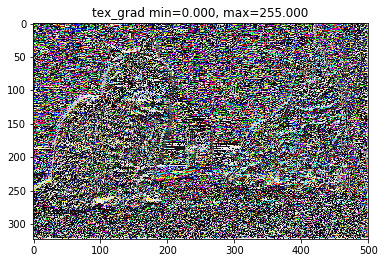

In [5]:
def calc_texture_gradient(img):
    """
        calculate texture gradient for entire image

        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.

        output will be [height(*)][width(*)]
    """
    ret = np.zeros(img.shape[:3])
    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret


def plot_image_with_min_max(img,nm):
    img = img[:,:,:3]
    plt.imshow(img)
    plt.title("{} min={:5.3f}, max={:5.3f}".format(nm,
                                                   np.min(img),
                                                   np.max(img)))
    plt.show()

tex_grad = calc_texture_gradient(img)   
plot_image_with_min_max(tex_grad,nm="tex_grad")

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


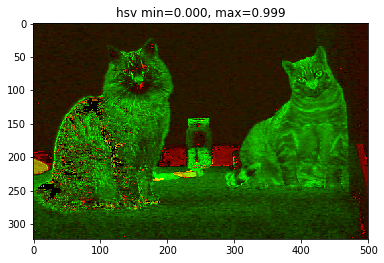

In [6]:
def calc_hsv(img):
    hsv = skimage.color.rgb2hsv(img[:,:,:3])
    return(hsv)

hsv = calc_hsv(img)
plot_image_with_min_max(hsv,nm="hsv")

In [7]:
def calc_hist(img, minhist=0, maxhist=1):
    """
        calculate colour histogram for each region

        the size of output histogram will be BINS * COLOUR_CHANNELS(3)

        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]

        extract HSV
        
        len(hist) = BINS * 3
        hist[:BINS] = [0, 10, 20, 0,...,0] meaning that 
           there are 10 pixels that have values between (maxhist - minhist)/BINS*1 and (maxhist - minhist)/BINS*2
           there are 10 pixels that have values between (maxhist - minhist)/BINS*2 and (maxhist - minhist)/BINS*3
    
    """

    BINS = 25
    hist = np.array([])

    for colour_channel in range(3):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, BINS, 
                                   # The lower and upper range of the bins. 
                                   (minhist, maxhist))[0]])

    # L1 normalize
    hist = hist / len(img)
    return hist

def augment_regions_with_histogram_info(tex_grad, img, R,hsv,tex_trad):
    for k, v in list(R.items()):

        ## height and width axies are flattened. 
        ## masked_pixel.shape = (N pixel with this mask ID , 3)
        masked_pixels  = hsv[img[:, :, 3] == k] 
        R[k]["size"]   = len(masked_pixels / 4)
        R[k]["hist_c"] = calc_hist(masked_pixels,minhist=0, maxhist=1)

        # texture histogram
        R[k]["hist_t"] = calc_hist(tex_grad[img[:, :, 3] == k],minhist=0, maxhist=2**8-1)
    return(R)
R = augment_regions_with_histogram_info(tex_grad, img,R,hsv,tex_grad)

In [8]:

def extract_neighbours(regions):
    '''
    check if two regions intersect 
    '''

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"] and a["min_y"] < b["min_y"] < a["max_y"]) or\
           (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or\
           (a["min_x"] < b["min_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or\
           (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours

neighbours = extract_neighbours(R)
print("Out of {} regions, we found {} intersecting pairs".format(len(R),len(neighbours)))

Out of 70 regions, we found 198 intersecting pairs


## For each pair of intersecting regions, calculate similarlities of the two regions.

In [9]:
def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize
def calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2)       +\
            _sim_texture(r1, r2)      +\
            _sim_size(r1, r2, imsize) +\
            _sim_fill(r1, r2, imsize))

def calculate_similarlity(img,neighbours,verbose=False):
    # calculate initial similarities
    imsize = img.shape[0] * img.shape[1]
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = calc_sim(ar, br, imsize)
        if verbose:
            print("S[({:2.0f}, {:2.0f})]={:3.2f}".format(ai,bi,S[(ai, bi)]))
    return(S)

print("S[(Pair of the intersecting regions)] = Similarity index")
S = calculate_similarlity(img,neighbours,verbose=True)

S[(Pair of the intersecting regions)] = Similarity index
S[( 0,  9)]=7.51
S[( 0, 10)]=7.34
S[( 0, 13)]=7.39
S[( 1,  2)]=7.55
S[( 1,  9)]=7.43
S[( 1, 10)]=7.25
S[( 1, 12)]=6.20
S[( 1, 13)]=7.48
S[( 1, 15)]=5.95
S[( 2, 12)]=6.23
S[( 2, 13)]=7.34
S[( 2, 15)]=6.01
S[( 3, 11)]=7.71
S[( 3, 12)]=6.22
S[( 4,  5)]=7.63
S[( 4,  6)]=7.60
S[( 4, 11)]=7.63
S[( 4, 16)]=7.37
S[( 4, 20)]=7.52
S[( 4, 22)]=7.48
S[( 6, 14)]=5.44
S[( 6, 16)]=7.63
S[( 6, 18)]=5.57
S[( 6, 19)]=5.61
S[( 7, 14)]=5.94
S[( 7, 17)]=7.13
S[( 7, 18)]=5.93
S[( 8, 17)]=6.78
S[( 8, 18)]=5.60
S[( 8, 21)]=7.46
S[( 9, 10)]=7.52
S[( 9, 13)]=7.36
S[(11, 12)]=6.22
S[(11, 20)]=7.43
S[(11, 22)]=7.56
S[(12, 13)]=6.42
S[(12, 15)]=7.09
S[(12, 22)]=6.16
S[(12, 26)]=6.35
S[(12, 27)]=6.85
S[(12, 29)]=6.91
S[(13, 15)]=6.21
S[(13, 25)]=7.47
S[(13, 27)]=5.80
S[(14, 19)]=7.37
S[(15, 27)]=7.14
S[(16, 19)]=5.61
S[(16, 20)]=7.58
S[(16, 22)]=7.57
S[(16, 24)]=7.69
S[(16, 28)]=5.46
S[(16, 31)]=7.39
S[(16, 32)]=5.43
S[(16, 33)]=7.75
S[(17, 21)]=7.10
S[(17, 2

The tickness of the bounding box shows the number of merged initial regions.

In [10]:
def merge_regions(r1, r2):
    '''
    Suppose r1 and r2 look like: 
    
    (minx1, miny1)
          _____________________
          |                   |
          |     (minx2,maxy2) |
          |           ________|____ 
          |          |        |    |
          |          |        |    |
          |          |________|____|(maxx2, maxy2)
          |___________________|(maxx1, maxy1)
          
    Then for merged region,
    
    minx : minx1
    miny : miny1
    maxx : maxx2
    maxy : maxy1 
    size : the number of pixels in the two regions (intersection is counted twice?)
    
                         
    '''
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt

def merge_regions_in_order(S,R,imsize, verbose=False):
    '''
    == Input ==
    S : similarity dictionary
    
    R : dictionary of proposed regions
    
    == Output ==
    
    regions : list of regions
    
    '''
    # hierarchal search
    while S != {}:

        # Step 1: get highest similarity pair of regions from the similarlity dictionary
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # Step 2: marge the region pair and add to the region dictionary
        t = max(R.keys()) + 1.0
        R[t] = merge_regions(R[i], R[j])

        # Step 3: from the similarity dictionary, 
        #         remove all the pair of regions where one of the regions is selected in Step 1
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)
        for k in key_to_delete:
            del S[k]

        # Step 4: calculate similarity with new merged region and the regions and its intersecting region
        #         (intersecting region is the region that are to be deleted)
        for k in key_to_delete:
            if k != (i,j):
                if k[0] in (i, j):
                    n = k[1]
                else:
                    n = k[0]
                S[(t, n)] = calc_sim(R[t], R[n], imsize)
    if verbose:
        print("{} regions".format(len(R)))

    ## finally return list of region proposal
    regions = []
    for k, r in list(R.items()):
            regions.append({
                'rect': (
                    r['min_x'],              # min x
                    r['min_y'],              # min y
                    r['max_x'] - r['min_x'], # width 
                    r['max_y'] - r['min_y']),# height
                'size': r['size'],
                'labels': r['labels']
            })
    return(regions)



regions = merge_regions_in_order(S,R,img.shape[0]*img.shape[1],verbose=True)

139 regions


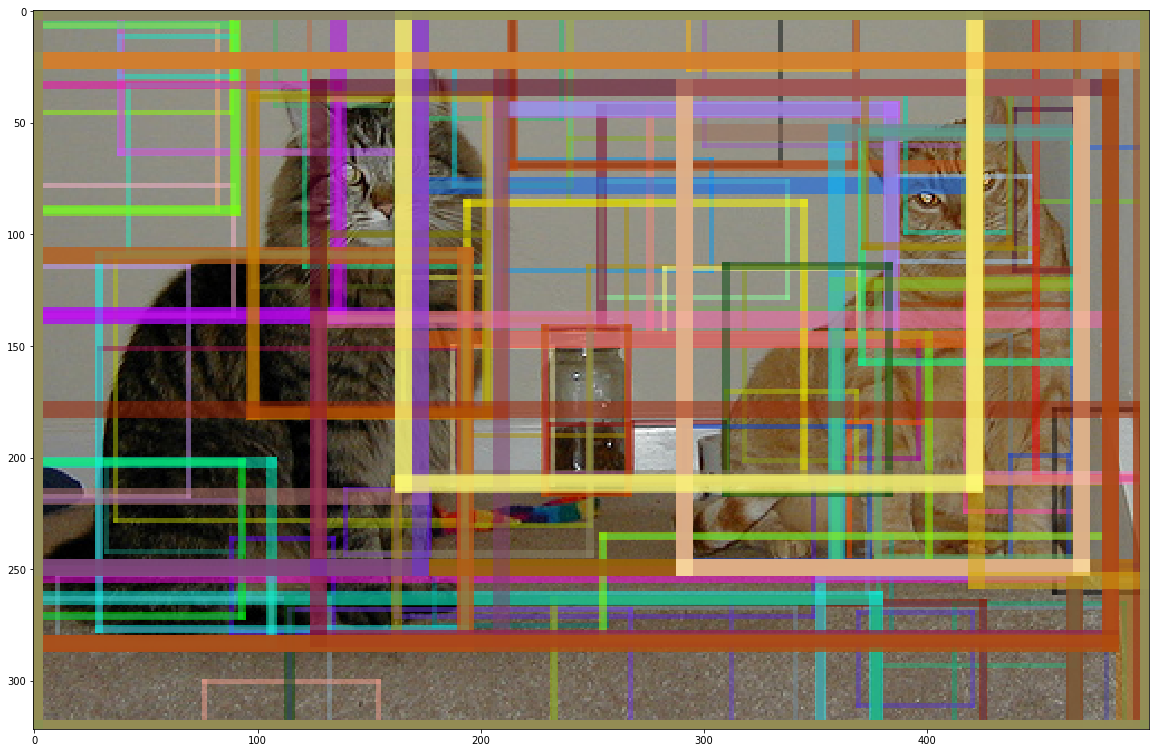

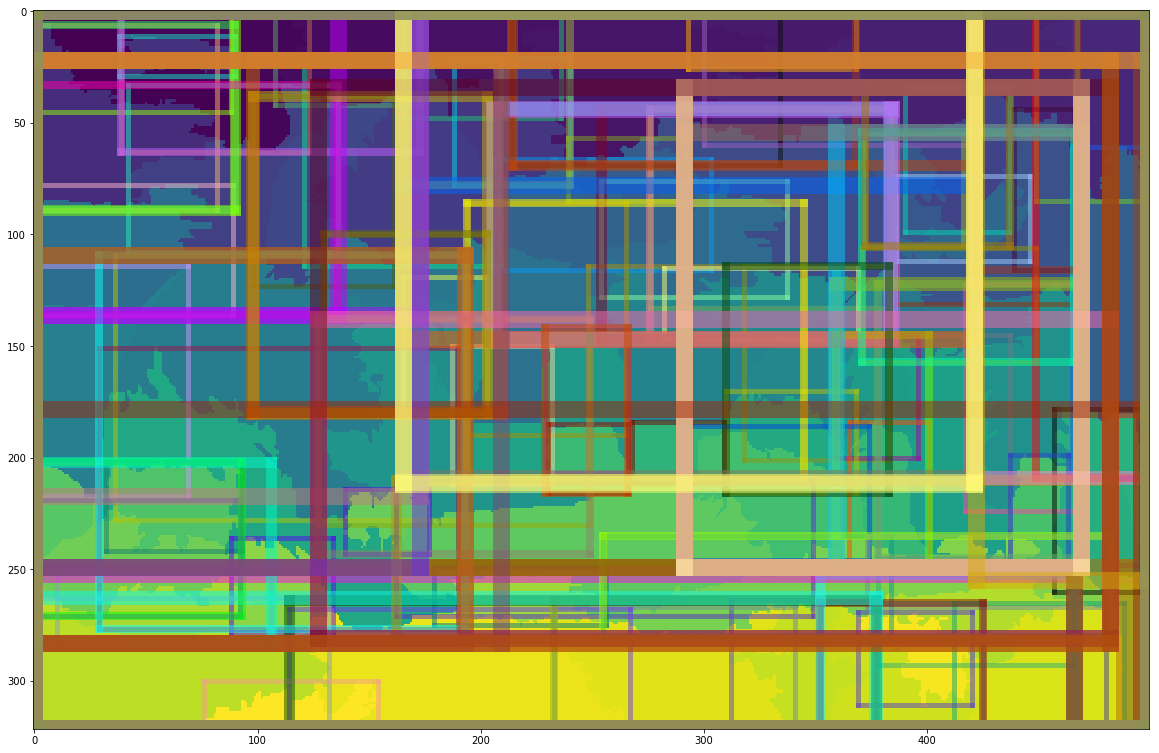

In [11]:
plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,x1,y1,x2 = x1 + width,y2 = y1 + height, color = color)
plt.show()

plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,3])
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,
                  x1,
                  y1,
                  x2 = x1 + width,
                  y2 = y1 + height, color= color)
plt.show()

Finally wrap around all the functions. 

In [12]:
def get_region_proposal(img_8bit,min_size = 500):
    img        = image_segmentation(img_8bit,min_size = min_size)
    R          = extract_region(img)    
    tex_grad   = calc_texture_gradient(img)
    hsv        = calc_hsv(img)
    R          = augment_regions_with_histogram_info(tex_grad, img, R,hsv,tex_grad)
    del tex_grad, hsv
    neighbours = extract_neighbours(R)
    S          = calculate_similarlity(img,neighbours)
    regions    = merge_regions_in_order(S,R,imsize = img.shape[0] * img.shape[1])
    return(regions)
regions = get_region_proposal(img_8bit,min_size=500)

regions
print("{} regions are found".format(len(regions)))

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


139 regions are found


# Evaluate the performance of the selective search in PASCAL data

This is an optional section.
Now let's check how many of the objects are found as an object via the selective search.
To simplify the problem I will only focus on the person class in this analysis. 
I will treat that the object is found when the Intersection over Union (IoU) is greater than 0.5.

IoU is a common metric to measure how similar our predicted bounding box is to the ground truth bounding box.
See explanation at: [Intersection over Union](http://ronny.rest/tutorials/module/localization_001/iou/). I will cite their self-explanatory diagram here:
<img src="https://farm5.staticflickr.com/4839/46007894091_39ba95c082_b.jpg" width="352" alt="Screen Shot 2018-11-22 at 7.02.28 PM">



First, we read in the annotation data extracted in [Part 1: Object Detection with Pascal VOC2012 - data preparation and understanding](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_data_preparation_and_understanding.html). 

In [13]:
# location to save df_anno.csv
import pandas as pd
dir_preprocessed = "VOCdevkit/VOC2012"
df_anno = pd.read_csv(os.path.join(dir_preprocessed,"df_anno.csv"),low_memory=False)

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145,150,155,160,165,170,175,180,185,190,195,200,205,210,215,220,225,230,235,240,245,250,255,260,265,270,275,280) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Keep the images that contain at least one person object.

In [14]:
cols_bbx = []
for colnm in df_anno.columns:
    if "name" in colnm:
        cols_bbx.append(colnm)
bbx_has_personTF = df_anno[cols_bbx].values == "person"
pick = np.any(bbx_has_personTF,axis=1)
df_anno_person = df_anno.loc[pick,:]

Define a function that calculates Intersection over Union between two regions.


In [15]:
def get_IOU(xmin1,ymin1,xmax1,ymax1,
            xmin2,ymin2,xmax2,ymax2):
    '''
     
    (minx1, miny1)
          _____________________
          |                   |
          |     (minx2,maxy2) |
          |           ________|____ 
          |          |        |    |
          |          |        |    |
          |          |________|____|(maxx2, maxy2)
          |___________________|(maxx1, maxy1)
          
    
                         
    '''    
    def get_wha(xmin1,xmax1,ymin1,ymax1):
            width1  = xmax1 - xmin1
            height1 = ymax1 - ymin1
            area1   = width1 * height1
            return(width1,height1,area1)
    width1,height1,area1 = get_wha(xmin1,xmax1,ymin1,ymax1)
    width2,height2,area2 = get_wha(xmin2,xmax2,ymin2,ymax2)
            
    int_xmin   = np.max([xmin1,xmin2])
    int_ymin   = np.max([ymin1,ymin2])
    int_xmax   = np.min([xmax1,xmax2])
    int_ymax   = np.min([ymax1,ymax2])            
    int_width  = int_xmax - int_xmin
    int_height = int_ymax - int_ymin
    int_area   = int_width*int_height    
    
    if (int_width < 0) or (int_height < 0):
        IOU = 0
    else:
        IOU = int_area / float(area1 + area2 - int_area)
    return(IOU)

Finally count the number of person object that is idenfied by the selective search.
Warning: The code below requires 1 Day to complete so I do not recommend you to run.

```
TIME TOOK : 1340.0814800858498MIN
Total N of person : 17401, Total N of person found : 11381, TPR: 0.654
```


In [16]:
import time, imageio
            
start = time.time()            
person_found_vec = []
for irow in range(df_anno_person.shape[0]): ## run over each frame
    row  = df_anno_person.iloc[irow,:]
    path = os.path.join(img_dir,row["fileID"] + ".jpg")
    img  = imageio.imread(path)
    
    ## calculate region proposal
    regions = get_region_proposal(img,min_size=40)
    
    for ibb in range(row["Nobj"]): ## go over each of the true annotated object
        print("frameID = {:04.0f}/{}, BBXID = {},  N region proposals = {}".format(
            irow, df_anno_person.shape[0], ibb, len(regions)))
        name = row["bbx_{}_name".format(ibb)]
        if name != "person":
            continue 
        ## bounding box of the person     
        true_xmin   = row["bbx_{}_xmin".format(ibb)]
        true_ymin   = row["bbx_{}_ymin".format(ibb)]
        true_xmax   = row["bbx_{}_xmax".format(ibb)]
        true_ymax   = row["bbx_{}_ymax".format(ibb)]   
        person_found_TF = 0
        for r in regions:  ## go over each region proposal and calculate the IoU
            
            prpl_xmin, prpl_ymin, prpl_width, prpl_height = r["rect"]
            IoU = get_IOU(prpl_xmin, prpl_ymin, prpl_xmin + prpl_width, prpl_ymin + prpl_height,
                          true_xmin, true_ymin, true_xmax, true_ymax)
            if IoU > 0.5:
                person_found_TF = 1
        person_found_vec.append(person_found_TF)
end = time.time()  
print("TIME TOOK : {}MIN".format((end-start)/60))
print("Total N of person : {}, Total N of person found : {}, TPR: {:4.3f}".format(
    len(person_found_vec),
    np.sum(person_found_vec),
    np.mean(person_found_vec)))

/Users/yumikondo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/Users/yumikondo/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0000/9583, BBXID = 0,  N region proposals = 2927
frameID = 0001/9583, BBXID = 0,  N region proposals = 1988
frameID = 0001/9583, BBXID = 1,  N region proposals = 1988
frameID = 0001/9583, BBXID = 2,  N region proposals = 1988
frameID = 0001/9583, BBXID = 3,  N region proposals = 1988
frameID = 0002/9583, BBXID = 0,  N region proposals = 1899
frameID = 0002/9583, BBXID = 1,  N region proposals = 1899
frameID = 0002/9583, BBXID = 2,  N region proposals = 1899
frameID = 0002/9583, BBXID = 3,  N region proposals = 1899
frameID = 0002/9583, BBXID = 4,  N region proposals = 1899
frameID = 0002/9583, BBXID = 5,  N region proposals = 1899
frameID = 0003/9583, BBXID = 0,  N region proposals = 2223
frameID = 0003/9583, BBXID = 1,  N region proposals = 2223
frameID = 0003/9583, BBXID = 2,  N region proposals = 2223
frameID = 0003/9583, BBXID = 3,  N region proposals = 2223
frameID = 0003/9583, BBXID = 4,  N region proposals = 2223
frameID = 0003/9583, BBXID = 5,  N region proposals = 22

frameID = 0037/9583, BBXID = 0,  N region proposals = 1614
frameID = 0037/9583, BBXID = 1,  N region proposals = 1614
frameID = 0037/9583, BBXID = 2,  N region proposals = 1614
frameID = 0037/9583, BBXID = 3,  N region proposals = 1614
frameID = 0037/9583, BBXID = 4,  N region proposals = 1614
frameID = 0038/9583, BBXID = 0,  N region proposals = 2132
frameID = 0038/9583, BBXID = 1,  N region proposals = 2132
frameID = 0039/9583, BBXID = 0,  N region proposals = 2154
frameID = 0039/9583, BBXID = 1,  N region proposals = 2154
frameID = 0040/9583, BBXID = 0,  N region proposals = 2752
frameID = 0040/9583, BBXID = 1,  N region proposals = 2752
frameID = 0040/9583, BBXID = 2,  N region proposals = 2752
frameID = 0041/9583, BBXID = 0,  N region proposals = 2363
frameID = 0041/9583, BBXID = 1,  N region proposals = 2363
frameID = 0042/9583, BBXID = 0,  N region proposals = 2197
frameID = 0042/9583, BBXID = 1,  N region proposals = 2197
frameID = 0042/9583, BBXID = 2,  N region proposals = 21

frameID = 0080/9583, BBXID = 0,  N region proposals = 2037
frameID = 0080/9583, BBXID = 1,  N region proposals = 2037
frameID = 0080/9583, BBXID = 2,  N region proposals = 2037
frameID = 0081/9583, BBXID = 0,  N region proposals = 1928
frameID = 0081/9583, BBXID = 1,  N region proposals = 1928
frameID = 0081/9583, BBXID = 2,  N region proposals = 1928
frameID = 0081/9583, BBXID = 3,  N region proposals = 1928
frameID = 0081/9583, BBXID = 4,  N region proposals = 1928
frameID = 0081/9583, BBXID = 5,  N region proposals = 1928
frameID = 0081/9583, BBXID = 6,  N region proposals = 1928
frameID = 0081/9583, BBXID = 7,  N region proposals = 1928
frameID = 0081/9583, BBXID = 8,  N region proposals = 1928
frameID = 0081/9583, BBXID = 9,  N region proposals = 1928
frameID = 0081/9583, BBXID = 10,  N region proposals = 1928
frameID = 0081/9583, BBXID = 11,  N region proposals = 1928
frameID = 0081/9583, BBXID = 12,  N region proposals = 1928
frameID = 0082/9583, BBXID = 0,  N region proposals =

frameID = 0126/9583, BBXID = 0,  N region proposals = 2176
frameID = 0126/9583, BBXID = 1,  N region proposals = 2176
frameID = 0127/9583, BBXID = 0,  N region proposals = 1960
frameID = 0127/9583, BBXID = 1,  N region proposals = 1960
frameID = 0127/9583, BBXID = 2,  N region proposals = 1960
frameID = 0128/9583, BBXID = 0,  N region proposals = 1961
frameID = 0129/9583, BBXID = 0,  N region proposals = 2026
frameID = 0130/9583, BBXID = 0,  N region proposals = 1493
frameID = 0130/9583, BBXID = 1,  N region proposals = 1493
frameID = 0130/9583, BBXID = 2,  N region proposals = 1493
frameID = 0131/9583, BBXID = 0,  N region proposals = 2452
frameID = 0132/9583, BBXID = 0,  N region proposals = 2166
frameID = 0132/9583, BBXID = 1,  N region proposals = 2166
frameID = 0132/9583, BBXID = 2,  N region proposals = 2166
frameID = 0132/9583, BBXID = 3,  N region proposals = 2166
frameID = 0132/9583, BBXID = 4,  N region proposals = 2166
frameID = 0133/9583, BBXID = 0,  N region proposals = 23

frameID = 0170/9583, BBXID = 0,  N region proposals = 2193
frameID = 0170/9583, BBXID = 1,  N region proposals = 2193
frameID = 0170/9583, BBXID = 2,  N region proposals = 2193
frameID = 0170/9583, BBXID = 3,  N region proposals = 2193
frameID = 0170/9583, BBXID = 4,  N region proposals = 2193
frameID = 0171/9583, BBXID = 0,  N region proposals = 1864
frameID = 0171/9583, BBXID = 1,  N region proposals = 1864
frameID = 0171/9583, BBXID = 2,  N region proposals = 1864
frameID = 0172/9583, BBXID = 0,  N region proposals = 2288
frameID = 0172/9583, BBXID = 1,  N region proposals = 2288
frameID = 0173/9583, BBXID = 0,  N region proposals = 2006
frameID = 0173/9583, BBXID = 1,  N region proposals = 2006
frameID = 0174/9583, BBXID = 0,  N region proposals = 1804
frameID = 0174/9583, BBXID = 1,  N region proposals = 1804
frameID = 0174/9583, BBXID = 2,  N region proposals = 1804
frameID = 0174/9583, BBXID = 3,  N region proposals = 1804
frameID = 0174/9583, BBXID = 4,  N region proposals = 18

frameID = 0220/9583, BBXID = 0,  N region proposals = 2196
frameID = 0220/9583, BBXID = 1,  N region proposals = 2196
frameID = 0220/9583, BBXID = 2,  N region proposals = 2196
frameID = 0220/9583, BBXID = 3,  N region proposals = 2196
frameID = 0220/9583, BBXID = 4,  N region proposals = 2196
frameID = 0221/9583, BBXID = 0,  N region proposals = 2163
frameID = 0221/9583, BBXID = 1,  N region proposals = 2163
frameID = 0221/9583, BBXID = 2,  N region proposals = 2163
frameID = 0221/9583, BBXID = 3,  N region proposals = 2163
frameID = 0222/9583, BBXID = 0,  N region proposals = 1244
frameID = 0222/9583, BBXID = 1,  N region proposals = 1244
frameID = 0222/9583, BBXID = 2,  N region proposals = 1244
frameID = 0222/9583, BBXID = 3,  N region proposals = 1244
frameID = 0222/9583, BBXID = 4,  N region proposals = 1244
frameID = 0223/9583, BBXID = 0,  N region proposals = 1992
frameID = 0224/9583, BBXID = 0,  N region proposals = 2244
frameID = 0224/9583, BBXID = 1,  N region proposals = 22

frameID = 0275/9583, BBXID = 0,  N region proposals = 2231
frameID = 0275/9583, BBXID = 1,  N region proposals = 2231
frameID = 0275/9583, BBXID = 2,  N region proposals = 2231
frameID = 0275/9583, BBXID = 3,  N region proposals = 2231
frameID = 0276/9583, BBXID = 0,  N region proposals = 2192
frameID = 0276/9583, BBXID = 1,  N region proposals = 2192
frameID = 0277/9583, BBXID = 0,  N region proposals = 2219
frameID = 0277/9583, BBXID = 1,  N region proposals = 2219
frameID = 0277/9583, BBXID = 2,  N region proposals = 2219
frameID = 0278/9583, BBXID = 0,  N region proposals = 1990
frameID = 0279/9583, BBXID = 0,  N region proposals = 2046
frameID = 0280/9583, BBXID = 0,  N region proposals = 2154
frameID = 0281/9583, BBXID = 0,  N region proposals = 2080
frameID = 0282/9583, BBXID = 0,  N region proposals = 2475
frameID = 0282/9583, BBXID = 1,  N region proposals = 2475
frameID = 0282/9583, BBXID = 2,  N region proposals = 2475
frameID = 0283/9583, BBXID = 0,  N region proposals = 23

frameID = 0320/9583, BBXID = 0,  N region proposals = 2219
frameID = 0320/9583, BBXID = 1,  N region proposals = 2219
frameID = 0321/9583, BBXID = 0,  N region proposals = 2264
frameID = 0321/9583, BBXID = 1,  N region proposals = 2264
frameID = 0321/9583, BBXID = 2,  N region proposals = 2264
frameID = 0321/9583, BBXID = 3,  N region proposals = 2264
frameID = 0321/9583, BBXID = 4,  N region proposals = 2264
frameID = 0321/9583, BBXID = 5,  N region proposals = 2264
frameID = 0321/9583, BBXID = 6,  N region proposals = 2264
frameID = 0322/9583, BBXID = 0,  N region proposals = 2091
frameID = 0323/9583, BBXID = 0,  N region proposals = 1909
frameID = 0323/9583, BBXID = 1,  N region proposals = 1909
frameID = 0324/9583, BBXID = 0,  N region proposals = 2309
frameID = 0324/9583, BBXID = 1,  N region proposals = 2309
frameID = 0324/9583, BBXID = 2,  N region proposals = 2309
frameID = 0324/9583, BBXID = 3,  N region proposals = 2309
frameID = 0324/9583, BBXID = 4,  N region proposals = 23

frameID = 0368/9583, BBXID = 2,  N region proposals = 2265
frameID = 0368/9583, BBXID = 3,  N region proposals = 2265
frameID = 0368/9583, BBXID = 4,  N region proposals = 2265
frameID = 0368/9583, BBXID = 5,  N region proposals = 2265
frameID = 0368/9583, BBXID = 6,  N region proposals = 2265
frameID = 0368/9583, BBXID = 7,  N region proposals = 2265
frameID = 0368/9583, BBXID = 8,  N region proposals = 2265
frameID = 0369/9583, BBXID = 0,  N region proposals = 2223
frameID = 0369/9583, BBXID = 1,  N region proposals = 2223
frameID = 0369/9583, BBXID = 2,  N region proposals = 2223
frameID = 0370/9583, BBXID = 0,  N region proposals = 2069
frameID = 0370/9583, BBXID = 1,  N region proposals = 2069
frameID = 0371/9583, BBXID = 0,  N region proposals = 1511
frameID = 0371/9583, BBXID = 1,  N region proposals = 1511
frameID = 0372/9583, BBXID = 0,  N region proposals = 1969
frameID = 0372/9583, BBXID = 1,  N region proposals = 1969
frameID = 0372/9583, BBXID = 2,  N region proposals = 19

frameID = 0409/9583, BBXID = 0,  N region proposals = 1905
frameID = 0409/9583, BBXID = 1,  N region proposals = 1905
frameID = 0409/9583, BBXID = 2,  N region proposals = 1905
frameID = 0409/9583, BBXID = 3,  N region proposals = 1905
frameID = 0409/9583, BBXID = 4,  N region proposals = 1905
frameID = 0410/9583, BBXID = 0,  N region proposals = 1757
frameID = 0410/9583, BBXID = 1,  N region proposals = 1757
frameID = 0411/9583, BBXID = 0,  N region proposals = 2293
frameID = 0411/9583, BBXID = 1,  N region proposals = 2293
frameID = 0412/9583, BBXID = 0,  N region proposals = 2067
frameID = 0412/9583, BBXID = 1,  N region proposals = 2067
frameID = 0413/9583, BBXID = 0,  N region proposals = 1946
frameID = 0413/9583, BBXID = 1,  N region proposals = 1946
frameID = 0414/9583, BBXID = 0,  N region proposals = 2356
frameID = 0414/9583, BBXID = 1,  N region proposals = 2356
frameID = 0414/9583, BBXID = 2,  N region proposals = 2356
frameID = 0414/9583, BBXID = 3,  N region proposals = 23

frameID = 0455/9583, BBXID = 0,  N region proposals = 1925
frameID = 0455/9583, BBXID = 1,  N region proposals = 1925
frameID = 0455/9583, BBXID = 2,  N region proposals = 1925
frameID = 0455/9583, BBXID = 3,  N region proposals = 1925
frameID = 0455/9583, BBXID = 4,  N region proposals = 1925
frameID = 0456/9583, BBXID = 0,  N region proposals = 2370
frameID = 0457/9583, BBXID = 0,  N region proposals = 2331
frameID = 0457/9583, BBXID = 1,  N region proposals = 2331
frameID = 0457/9583, BBXID = 2,  N region proposals = 2331
frameID = 0457/9583, BBXID = 3,  N region proposals = 2331
frameID = 0457/9583, BBXID = 4,  N region proposals = 2331
frameID = 0457/9583, BBXID = 5,  N region proposals = 2331
frameID = 0458/9583, BBXID = 0,  N region proposals = 2001
frameID = 0458/9583, BBXID = 1,  N region proposals = 2001
frameID = 0458/9583, BBXID = 2,  N region proposals = 2001
frameID = 0458/9583, BBXID = 3,  N region proposals = 2001
frameID = 0458/9583, BBXID = 4,  N region proposals = 20

frameID = 0499/9583, BBXID = 0,  N region proposals = 1633
frameID = 0500/9583, BBXID = 0,  N region proposals = 1593
frameID = 0500/9583, BBXID = 1,  N region proposals = 1593
frameID = 0501/9583, BBXID = 0,  N region proposals = 1692
frameID = 0502/9583, BBXID = 0,  N region proposals = 1590
frameID = 0503/9583, BBXID = 0,  N region proposals = 1717
frameID = 0503/9583, BBXID = 1,  N region proposals = 1717
frameID = 0503/9583, BBXID = 2,  N region proposals = 1717
frameID = 0503/9583, BBXID = 3,  N region proposals = 1717
frameID = 0504/9583, BBXID = 0,  N region proposals = 1784
frameID = 0504/9583, BBXID = 1,  N region proposals = 1784
frameID = 0505/9583, BBXID = 0,  N region proposals = 2140
frameID = 0505/9583, BBXID = 1,  N region proposals = 2140
frameID = 0506/9583, BBXID = 0,  N region proposals = 2284
frameID = 0506/9583, BBXID = 1,  N region proposals = 2284
frameID = 0506/9583, BBXID = 2,  N region proposals = 2284
frameID = 0506/9583, BBXID = 3,  N region proposals = 22

frameID = 0552/9583, BBXID = 0,  N region proposals = 2251
frameID = 0553/9583, BBXID = 0,  N region proposals = 1655
frameID = 0554/9583, BBXID = 0,  N region proposals = 2024
frameID = 0554/9583, BBXID = 1,  N region proposals = 2024
frameID = 0555/9583, BBXID = 0,  N region proposals = 2057
frameID = 0555/9583, BBXID = 1,  N region proposals = 2057
frameID = 0555/9583, BBXID = 2,  N region proposals = 2057
frameID = 0555/9583, BBXID = 3,  N region proposals = 2057
frameID = 0555/9583, BBXID = 4,  N region proposals = 2057
frameID = 0555/9583, BBXID = 5,  N region proposals = 2057
frameID = 0555/9583, BBXID = 6,  N region proposals = 2057
frameID = 0556/9583, BBXID = 0,  N region proposals = 1740
frameID = 0556/9583, BBXID = 1,  N region proposals = 1740
frameID = 0556/9583, BBXID = 2,  N region proposals = 1740
frameID = 0557/9583, BBXID = 0,  N region proposals = 2418
frameID = 0557/9583, BBXID = 1,  N region proposals = 2418
frameID = 0557/9583, BBXID = 2,  N region proposals = 24

frameID = 0612/9583, BBXID = 0,  N region proposals = 2242
frameID = 0612/9583, BBXID = 1,  N region proposals = 2242
frameID = 0613/9583, BBXID = 0,  N region proposals = 1729
frameID = 0613/9583, BBXID = 1,  N region proposals = 1729
frameID = 0614/9583, BBXID = 0,  N region proposals = 2128
frameID = 0615/9583, BBXID = 0,  N region proposals = 2234
frameID = 0615/9583, BBXID = 1,  N region proposals = 2234
frameID = 0616/9583, BBXID = 0,  N region proposals = 2065
frameID = 0616/9583, BBXID = 1,  N region proposals = 2065
frameID = 0616/9583, BBXID = 2,  N region proposals = 2065
frameID = 0616/9583, BBXID = 3,  N region proposals = 2065
frameID = 0616/9583, BBXID = 4,  N region proposals = 2065
frameID = 0616/9583, BBXID = 5,  N region proposals = 2065
frameID = 0616/9583, BBXID = 6,  N region proposals = 2065
frameID = 0616/9583, BBXID = 7,  N region proposals = 2065
frameID = 0616/9583, BBXID = 8,  N region proposals = 2065
frameID = 0616/9583, BBXID = 9,  N region proposals = 20

frameID = 0649/9583, BBXID = 0,  N region proposals = 2235
frameID = 0649/9583, BBXID = 1,  N region proposals = 2235
frameID = 0649/9583, BBXID = 2,  N region proposals = 2235
frameID = 0649/9583, BBXID = 3,  N region proposals = 2235
frameID = 0649/9583, BBXID = 4,  N region proposals = 2235
frameID = 0649/9583, BBXID = 5,  N region proposals = 2235
frameID = 0649/9583, BBXID = 6,  N region proposals = 2235
frameID = 0649/9583, BBXID = 7,  N region proposals = 2235
frameID = 0650/9583, BBXID = 0,  N region proposals = 2337
frameID = 0650/9583, BBXID = 1,  N region proposals = 2337
frameID = 0650/9583, BBXID = 2,  N region proposals = 2337
frameID = 0650/9583, BBXID = 3,  N region proposals = 2337
frameID = 0650/9583, BBXID = 4,  N region proposals = 2337
frameID = 0651/9583, BBXID = 0,  N region proposals = 2425
frameID = 0651/9583, BBXID = 1,  N region proposals = 2425
frameID = 0652/9583, BBXID = 0,  N region proposals = 2018
frameID = 0652/9583, BBXID = 1,  N region proposals = 20

frameID = 0684/9583, BBXID = 0,  N region proposals = 2383
frameID = 0684/9583, BBXID = 1,  N region proposals = 2383
frameID = 0684/9583, BBXID = 2,  N region proposals = 2383
frameID = 0685/9583, BBXID = 0,  N region proposals = 1833
frameID = 0685/9583, BBXID = 1,  N region proposals = 1833
frameID = 0685/9583, BBXID = 2,  N region proposals = 1833
frameID = 0685/9583, BBXID = 3,  N region proposals = 1833
frameID = 0685/9583, BBXID = 4,  N region proposals = 1833
frameID = 0686/9583, BBXID = 0,  N region proposals = 2309
frameID = 0686/9583, BBXID = 1,  N region proposals = 2309
frameID = 0687/9583, BBXID = 0,  N region proposals = 2167
frameID = 0687/9583, BBXID = 1,  N region proposals = 2167
frameID = 0687/9583, BBXID = 2,  N region proposals = 2167
frameID = 0687/9583, BBXID = 3,  N region proposals = 2167
frameID = 0687/9583, BBXID = 4,  N region proposals = 2167
frameID = 0687/9583, BBXID = 5,  N region proposals = 2167
frameID = 0687/9583, BBXID = 6,  N region proposals = 21

frameID = 0727/9583, BBXID = 0,  N region proposals = 1422
frameID = 0728/9583, BBXID = 0,  N region proposals = 2092
frameID = 0728/9583, BBXID = 1,  N region proposals = 2092
frameID = 0728/9583, BBXID = 2,  N region proposals = 2092
frameID = 0729/9583, BBXID = 0,  N region proposals = 2109
frameID = 0729/9583, BBXID = 1,  N region proposals = 2109
frameID = 0729/9583, BBXID = 2,  N region proposals = 2109
frameID = 0729/9583, BBXID = 3,  N region proposals = 2109
frameID = 0729/9583, BBXID = 4,  N region proposals = 2109
frameID = 0730/9583, BBXID = 0,  N region proposals = 2329
frameID = 0731/9583, BBXID = 0,  N region proposals = 2556
frameID = 0731/9583, BBXID = 1,  N region proposals = 2556
frameID = 0732/9583, BBXID = 0,  N region proposals = 2372
frameID = 0732/9583, BBXID = 1,  N region proposals = 2372
frameID = 0733/9583, BBXID = 0,  N region proposals = 2241
frameID = 0733/9583, BBXID = 1,  N region proposals = 2241
frameID = 0733/9583, BBXID = 2,  N region proposals = 22

frameID = 0779/9583, BBXID = 0,  N region proposals = 2362
frameID = 0779/9583, BBXID = 1,  N region proposals = 2362
frameID = 0779/9583, BBXID = 2,  N region proposals = 2362
frameID = 0779/9583, BBXID = 3,  N region proposals = 2362
frameID = 0779/9583, BBXID = 4,  N region proposals = 2362
frameID = 0779/9583, BBXID = 5,  N region proposals = 2362
frameID = 0780/9583, BBXID = 0,  N region proposals = 2141
frameID = 0780/9583, BBXID = 1,  N region proposals = 2141
frameID = 0780/9583, BBXID = 2,  N region proposals = 2141
frameID = 0780/9583, BBXID = 3,  N region proposals = 2141
frameID = 0781/9583, BBXID = 0,  N region proposals = 1428
frameID = 0781/9583, BBXID = 1,  N region proposals = 1428
frameID = 0781/9583, BBXID = 2,  N region proposals = 1428
frameID = 0782/9583, BBXID = 0,  N region proposals = 2397
frameID = 0782/9583, BBXID = 1,  N region proposals = 2397
frameID = 0782/9583, BBXID = 2,  N region proposals = 2397
frameID = 0782/9583, BBXID = 3,  N region proposals = 23

frameID = 0817/9583, BBXID = 3,  N region proposals = 2071
frameID = 0817/9583, BBXID = 4,  N region proposals = 2071
frameID = 0817/9583, BBXID = 5,  N region proposals = 2071
frameID = 0817/9583, BBXID = 6,  N region proposals = 2071
frameID = 0817/9583, BBXID = 7,  N region proposals = 2071
frameID = 0818/9583, BBXID = 0,  N region proposals = 2715
frameID = 0818/9583, BBXID = 1,  N region proposals = 2715
frameID = 0819/9583, BBXID = 0,  N region proposals = 2949
frameID = 0819/9583, BBXID = 1,  N region proposals = 2949
frameID = 0820/9583, BBXID = 0,  N region proposals = 2078
frameID = 0820/9583, BBXID = 1,  N region proposals = 2078
frameID = 0821/9583, BBXID = 0,  N region proposals = 2123
frameID = 0821/9583, BBXID = 1,  N region proposals = 2123
frameID = 0821/9583, BBXID = 2,  N region proposals = 2123
frameID = 0822/9583, BBXID = 0,  N region proposals = 2265
frameID = 0823/9583, BBXID = 0,  N region proposals = 2402
frameID = 0823/9583, BBXID = 1,  N region proposals = 24

frameID = 0857/9583, BBXID = 3,  N region proposals = 2187
frameID = 0857/9583, BBXID = 4,  N region proposals = 2187
frameID = 0857/9583, BBXID = 5,  N region proposals = 2187
frameID = 0857/9583, BBXID = 6,  N region proposals = 2187
frameID = 0857/9583, BBXID = 7,  N region proposals = 2187
frameID = 0858/9583, BBXID = 0,  N region proposals = 2232
frameID = 0858/9583, BBXID = 1,  N region proposals = 2232
frameID = 0859/9583, BBXID = 0,  N region proposals = 2267
frameID = 0859/9583, BBXID = 1,  N region proposals = 2267
frameID = 0859/9583, BBXID = 2,  N region proposals = 2267
frameID = 0859/9583, BBXID = 3,  N region proposals = 2267
frameID = 0859/9583, BBXID = 4,  N region proposals = 2267
frameID = 0859/9583, BBXID = 5,  N region proposals = 2267
frameID = 0859/9583, BBXID = 6,  N region proposals = 2267
frameID = 0859/9583, BBXID = 7,  N region proposals = 2267
frameID = 0859/9583, BBXID = 8,  N region proposals = 2267
frameID = 0859/9583, BBXID = 9,  N region proposals = 22

frameID = 0899/9583, BBXID = 6,  N region proposals = 1961
frameID = 0899/9583, BBXID = 7,  N region proposals = 1961
frameID = 0899/9583, BBXID = 8,  N region proposals = 1961
frameID = 0900/9583, BBXID = 0,  N region proposals = 2237
frameID = 0901/9583, BBXID = 0,  N region proposals = 2483
frameID = 0901/9583, BBXID = 1,  N region proposals = 2483
frameID = 0901/9583, BBXID = 2,  N region proposals = 2483
frameID = 0901/9583, BBXID = 3,  N region proposals = 2483
frameID = 0901/9583, BBXID = 4,  N region proposals = 2483
frameID = 0902/9583, BBXID = 0,  N region proposals = 2299
frameID = 0902/9583, BBXID = 1,  N region proposals = 2299
frameID = 0903/9583, BBXID = 0,  N region proposals = 2505
frameID = 0903/9583, BBXID = 1,  N region proposals = 2505
frameID = 0903/9583, BBXID = 2,  N region proposals = 2505
frameID = 0903/9583, BBXID = 3,  N region proposals = 2505
frameID = 0903/9583, BBXID = 4,  N region proposals = 2505
frameID = 0903/9583, BBXID = 5,  N region proposals = 25

frameID = 0933/9583, BBXID = 0,  N region proposals = 2217
frameID = 0934/9583, BBXID = 0,  N region proposals = 1894
frameID = 0934/9583, BBXID = 1,  N region proposals = 1894
frameID = 0934/9583, BBXID = 2,  N region proposals = 1894
frameID = 0934/9583, BBXID = 3,  N region proposals = 1894
frameID = 0934/9583, BBXID = 4,  N region proposals = 1894
frameID = 0935/9583, BBXID = 0,  N region proposals = 2038
frameID = 0936/9583, BBXID = 0,  N region proposals = 2410
frameID = 0937/9583, BBXID = 0,  N region proposals = 2176
frameID = 0937/9583, BBXID = 1,  N region proposals = 2176
frameID = 0938/9583, BBXID = 0,  N region proposals = 1972
frameID = 0938/9583, BBXID = 1,  N region proposals = 1972
frameID = 0938/9583, BBXID = 2,  N region proposals = 1972
frameID = 0939/9583, BBXID = 0,  N region proposals = 2321
frameID = 0939/9583, BBXID = 1,  N region proposals = 2321
frameID = 0939/9583, BBXID = 2,  N region proposals = 2321
frameID = 0939/9583, BBXID = 3,  N region proposals = 23

frameID = 0973/9583, BBXID = 0,  N region proposals = 2386
frameID = 0973/9583, BBXID = 1,  N region proposals = 2386
frameID = 0974/9583, BBXID = 0,  N region proposals = 1979
frameID = 0974/9583, BBXID = 1,  N region proposals = 1979
frameID = 0974/9583, BBXID = 2,  N region proposals = 1979
frameID = 0975/9583, BBXID = 0,  N region proposals = 2287
frameID = 0976/9583, BBXID = 0,  N region proposals = 1510
frameID = 0976/9583, BBXID = 1,  N region proposals = 1510
frameID = 0976/9583, BBXID = 2,  N region proposals = 1510
frameID = 0976/9583, BBXID = 3,  N region proposals = 1510
frameID = 0976/9583, BBXID = 4,  N region proposals = 1510
frameID = 0976/9583, BBXID = 5,  N region proposals = 1510
frameID = 0976/9583, BBXID = 6,  N region proposals = 1510
frameID = 0976/9583, BBXID = 7,  N region proposals = 1510
frameID = 0976/9583, BBXID = 8,  N region proposals = 1510
frameID = 0976/9583, BBXID = 9,  N region proposals = 1510
frameID = 0976/9583, BBXID = 10,  N region proposals = 1

frameID = 1009/9583, BBXID = 0,  N region proposals = 2172
frameID = 1009/9583, BBXID = 1,  N region proposals = 2172
frameID = 1009/9583, BBXID = 2,  N region proposals = 2172
frameID = 1009/9583, BBXID = 3,  N region proposals = 2172
frameID = 1009/9583, BBXID = 4,  N region proposals = 2172
frameID = 1009/9583, BBXID = 5,  N region proposals = 2172
frameID = 1009/9583, BBXID = 6,  N region proposals = 2172
frameID = 1009/9583, BBXID = 7,  N region proposals = 2172
frameID = 1009/9583, BBXID = 8,  N region proposals = 2172
frameID = 1009/9583, BBXID = 9,  N region proposals = 2172
frameID = 1009/9583, BBXID = 10,  N region proposals = 2172
frameID = 1009/9583, BBXID = 11,  N region proposals = 2172
frameID = 1009/9583, BBXID = 12,  N region proposals = 2172
frameID = 1009/9583, BBXID = 13,  N region proposals = 2172
frameID = 1010/9583, BBXID = 0,  N region proposals = 1930
frameID = 1010/9583, BBXID = 1,  N region proposals = 1930
frameID = 1010/9583, BBXID = 2,  N region proposals 

frameID = 1048/9583, BBXID = 3,  N region proposals = 2187
frameID = 1049/9583, BBXID = 0,  N region proposals = 2152
frameID = 1049/9583, BBXID = 1,  N region proposals = 2152
frameID = 1049/9583, BBXID = 2,  N region proposals = 2152
frameID = 1050/9583, BBXID = 0,  N region proposals = 1895
frameID = 1050/9583, BBXID = 1,  N region proposals = 1895
frameID = 1050/9583, BBXID = 2,  N region proposals = 1895
frameID = 1050/9583, BBXID = 3,  N region proposals = 1895
frameID = 1050/9583, BBXID = 4,  N region proposals = 1895
frameID = 1050/9583, BBXID = 5,  N region proposals = 1895
frameID = 1050/9583, BBXID = 6,  N region proposals = 1895
frameID = 1050/9583, BBXID = 7,  N region proposals = 1895
frameID = 1050/9583, BBXID = 8,  N region proposals = 1895
frameID = 1050/9583, BBXID = 9,  N region proposals = 1895
frameID = 1050/9583, BBXID = 10,  N region proposals = 1895
frameID = 1051/9583, BBXID = 0,  N region proposals = 2217
frameID = 1052/9583, BBXID = 0,  N region proposals = 2

frameID = 1081/9583, BBXID = 0,  N region proposals = 2048
frameID = 1081/9583, BBXID = 1,  N region proposals = 2048
frameID = 1082/9583, BBXID = 0,  N region proposals = 2472
frameID = 1082/9583, BBXID = 1,  N region proposals = 2472
frameID = 1082/9583, BBXID = 2,  N region proposals = 2472
frameID = 1083/9583, BBXID = 0,  N region proposals = 2487
frameID = 1084/9583, BBXID = 0,  N region proposals = 2279
frameID = 1084/9583, BBXID = 1,  N region proposals = 2279
frameID = 1084/9583, BBXID = 2,  N region proposals = 2279
frameID = 1084/9583, BBXID = 3,  N region proposals = 2279
frameID = 1085/9583, BBXID = 0,  N region proposals = 1958
frameID = 1085/9583, BBXID = 1,  N region proposals = 1958
frameID = 1086/9583, BBXID = 0,  N region proposals = 2165
frameID = 1086/9583, BBXID = 1,  N region proposals = 2165
frameID = 1086/9583, BBXID = 2,  N region proposals = 2165
frameID = 1087/9583, BBXID = 0,  N region proposals = 1797
frameID = 1087/9583, BBXID = 1,  N region proposals = 17

frameID = 1121/9583, BBXID = 3,  N region proposals = 2162
frameID = 1121/9583, BBXID = 4,  N region proposals = 2162
frameID = 1121/9583, BBXID = 5,  N region proposals = 2162
frameID = 1122/9583, BBXID = 0,  N region proposals = 2377
frameID = 1123/9583, BBXID = 0,  N region proposals = 2171
frameID = 1123/9583, BBXID = 1,  N region proposals = 2171
frameID = 1124/9583, BBXID = 0,  N region proposals = 1953
frameID = 1124/9583, BBXID = 1,  N region proposals = 1953
frameID = 1124/9583, BBXID = 2,  N region proposals = 1953
frameID = 1124/9583, BBXID = 3,  N region proposals = 1953
frameID = 1124/9583, BBXID = 4,  N region proposals = 1953
frameID = 1124/9583, BBXID = 5,  N region proposals = 1953
frameID = 1124/9583, BBXID = 6,  N region proposals = 1953
frameID = 1124/9583, BBXID = 7,  N region proposals = 1953
frameID = 1124/9583, BBXID = 8,  N region proposals = 1953
frameID = 1124/9583, BBXID = 9,  N region proposals = 1953
frameID = 1124/9583, BBXID = 10,  N region proposals = 1

frameID = 1155/9583, BBXID = 0,  N region proposals = 2232
frameID = 1155/9583, BBXID = 1,  N region proposals = 2232
frameID = 1156/9583, BBXID = 0,  N region proposals = 2184
frameID = 1157/9583, BBXID = 0,  N region proposals = 2308
frameID = 1157/9583, BBXID = 1,  N region proposals = 2308
frameID = 1158/9583, BBXID = 0,  N region proposals = 2127
frameID = 1158/9583, BBXID = 1,  N region proposals = 2127
frameID = 1159/9583, BBXID = 0,  N region proposals = 2219
frameID = 1159/9583, BBXID = 1,  N region proposals = 2219
frameID = 1159/9583, BBXID = 2,  N region proposals = 2219
frameID = 1160/9583, BBXID = 0,  N region proposals = 2253
frameID = 1161/9583, BBXID = 0,  N region proposals = 1889
frameID = 1162/9583, BBXID = 0,  N region proposals = 1900
frameID = 1163/9583, BBXID = 0,  N region proposals = 1995
frameID = 1163/9583, BBXID = 1,  N region proposals = 1995
frameID = 1163/9583, BBXID = 2,  N region proposals = 1995
frameID = 1163/9583, BBXID = 3,  N region proposals = 19

frameID = 1199/9583, BBXID = 0,  N region proposals = 2257
frameID = 1200/9583, BBXID = 0,  N region proposals = 2015
frameID = 1200/9583, BBXID = 1,  N region proposals = 2015
frameID = 1201/9583, BBXID = 0,  N region proposals = 2247
frameID = 1201/9583, BBXID = 1,  N region proposals = 2247
frameID = 1201/9583, BBXID = 2,  N region proposals = 2247
frameID = 1201/9583, BBXID = 3,  N region proposals = 2247
frameID = 1201/9583, BBXID = 4,  N region proposals = 2247
frameID = 1201/9583, BBXID = 5,  N region proposals = 2247
frameID = 1201/9583, BBXID = 6,  N region proposals = 2247
frameID = 1202/9583, BBXID = 0,  N region proposals = 2215
frameID = 1202/9583, BBXID = 1,  N region proposals = 2215
frameID = 1202/9583, BBXID = 2,  N region proposals = 2215
frameID = 1203/9583, BBXID = 0,  N region proposals = 1892
frameID = 1204/9583, BBXID = 0,  N region proposals = 2273
frameID = 1204/9583, BBXID = 1,  N region proposals = 2273
frameID = 1204/9583, BBXID = 2,  N region proposals = 22

frameID = 1248/9583, BBXID = 0,  N region proposals = 2156
frameID = 1249/9583, BBXID = 0,  N region proposals = 2127
frameID = 1249/9583, BBXID = 1,  N region proposals = 2127
frameID = 1249/9583, BBXID = 2,  N region proposals = 2127
frameID = 1249/9583, BBXID = 3,  N region proposals = 2127
frameID = 1250/9583, BBXID = 0,  N region proposals = 2517
frameID = 1250/9583, BBXID = 1,  N region proposals = 2517
frameID = 1251/9583, BBXID = 0,  N region proposals = 2115
frameID = 1252/9583, BBXID = 0,  N region proposals = 2329
frameID = 1252/9583, BBXID = 1,  N region proposals = 2329
frameID = 1252/9583, BBXID = 2,  N region proposals = 2329
frameID = 1253/9583, BBXID = 0,  N region proposals = 2292
frameID = 1253/9583, BBXID = 1,  N region proposals = 2292
frameID = 1253/9583, BBXID = 2,  N region proposals = 2292
frameID = 1253/9583, BBXID = 3,  N region proposals = 2292
frameID = 1253/9583, BBXID = 4,  N region proposals = 2292
frameID = 1254/9583, BBXID = 0,  N region proposals = 19

frameID = 1293/9583, BBXID = 0,  N region proposals = 2136
frameID = 1293/9583, BBXID = 1,  N region proposals = 2136
frameID = 1294/9583, BBXID = 0,  N region proposals = 2313
frameID = 1295/9583, BBXID = 0,  N region proposals = 2155
frameID = 1295/9583, BBXID = 1,  N region proposals = 2155
frameID = 1295/9583, BBXID = 2,  N region proposals = 2155
frameID = 1296/9583, BBXID = 0,  N region proposals = 2310
frameID = 1297/9583, BBXID = 0,  N region proposals = 2040
frameID = 1297/9583, BBXID = 1,  N region proposals = 2040
frameID = 1297/9583, BBXID = 2,  N region proposals = 2040
frameID = 1298/9583, BBXID = 0,  N region proposals = 2203
frameID = 1298/9583, BBXID = 1,  N region proposals = 2203
frameID = 1299/9583, BBXID = 0,  N region proposals = 2640
frameID = 1299/9583, BBXID = 1,  N region proposals = 2640
frameID = 1300/9583, BBXID = 0,  N region proposals = 2113
frameID = 1300/9583, BBXID = 1,  N region proposals = 2113
frameID = 1300/9583, BBXID = 2,  N region proposals = 21

frameID = 1336/9583, BBXID = 0,  N region proposals = 2316
frameID = 1337/9583, BBXID = 0,  N region proposals = 2196
frameID = 1337/9583, BBXID = 1,  N region proposals = 2196
frameID = 1338/9583, BBXID = 0,  N region proposals = 1531
frameID = 1338/9583, BBXID = 1,  N region proposals = 1531
frameID = 1339/9583, BBXID = 0,  N region proposals = 2098
frameID = 1339/9583, BBXID = 1,  N region proposals = 2098
frameID = 1339/9583, BBXID = 2,  N region proposals = 2098
frameID = 1339/9583, BBXID = 3,  N region proposals = 2098
frameID = 1339/9583, BBXID = 4,  N region proposals = 2098
frameID = 1340/9583, BBXID = 0,  N region proposals = 2375
frameID = 1340/9583, BBXID = 1,  N region proposals = 2375
frameID = 1340/9583, BBXID = 2,  N region proposals = 2375
frameID = 1341/9583, BBXID = 0,  N region proposals = 2108
frameID = 1341/9583, BBXID = 1,  N region proposals = 2108
frameID = 1341/9583, BBXID = 2,  N region proposals = 2108
frameID = 1341/9583, BBXID = 3,  N region proposals = 21

frameID = 1374/9583, BBXID = 0,  N region proposals = 2203
frameID = 1374/9583, BBXID = 1,  N region proposals = 2203
frameID = 1374/9583, BBXID = 2,  N region proposals = 2203
frameID = 1374/9583, BBXID = 3,  N region proposals = 2203
frameID = 1374/9583, BBXID = 4,  N region proposals = 2203
frameID = 1375/9583, BBXID = 0,  N region proposals = 1805
frameID = 1375/9583, BBXID = 1,  N region proposals = 1805
frameID = 1376/9583, BBXID = 0,  N region proposals = 2371
frameID = 1376/9583, BBXID = 1,  N region proposals = 2371
frameID = 1377/9583, BBXID = 0,  N region proposals = 2111
frameID = 1378/9583, BBXID = 0,  N region proposals = 3011
frameID = 1378/9583, BBXID = 1,  N region proposals = 3011
frameID = 1379/9583, BBXID = 0,  N region proposals = 2331
frameID = 1379/9583, BBXID = 1,  N region proposals = 2331
frameID = 1379/9583, BBXID = 2,  N region proposals = 2331
frameID = 1379/9583, BBXID = 3,  N region proposals = 2331
frameID = 1379/9583, BBXID = 4,  N region proposals = 23

frameID = 1416/9583, BBXID = 0,  N region proposals = 2287
frameID = 1416/9583, BBXID = 1,  N region proposals = 2287
frameID = 1416/9583, BBXID = 2,  N region proposals = 2287
frameID = 1416/9583, BBXID = 3,  N region proposals = 2287
frameID = 1417/9583, BBXID = 0,  N region proposals = 1978
frameID = 1417/9583, BBXID = 1,  N region proposals = 1978
frameID = 1418/9583, BBXID = 0,  N region proposals = 2257
frameID = 1418/9583, BBXID = 1,  N region proposals = 2257
frameID = 1419/9583, BBXID = 0,  N region proposals = 1987
frameID = 1419/9583, BBXID = 1,  N region proposals = 1987
frameID = 1420/9583, BBXID = 0,  N region proposals = 2040
frameID = 1420/9583, BBXID = 1,  N region proposals = 2040
frameID = 1420/9583, BBXID = 2,  N region proposals = 2040
frameID = 1420/9583, BBXID = 3,  N region proposals = 2040
frameID = 1420/9583, BBXID = 4,  N region proposals = 2040
frameID = 1420/9583, BBXID = 5,  N region proposals = 2040
frameID = 1420/9583, BBXID = 6,  N region proposals = 20

frameID = 1454/9583, BBXID = 5,  N region proposals = 2413
frameID = 1454/9583, BBXID = 6,  N region proposals = 2413
frameID = 1455/9583, BBXID = 0,  N region proposals = 2293
frameID = 1455/9583, BBXID = 1,  N region proposals = 2293
frameID = 1455/9583, BBXID = 2,  N region proposals = 2293
frameID = 1455/9583, BBXID = 3,  N region proposals = 2293
frameID = 1455/9583, BBXID = 4,  N region proposals = 2293
frameID = 1456/9583, BBXID = 0,  N region proposals = 2563
frameID = 1457/9583, BBXID = 0,  N region proposals = 2284
frameID = 1457/9583, BBXID = 1,  N region proposals = 2284
frameID = 1458/9583, BBXID = 0,  N region proposals = 2060
frameID = 1458/9583, BBXID = 1,  N region proposals = 2060
frameID = 1459/9583, BBXID = 0,  N region proposals = 2142
frameID = 1459/9583, BBXID = 1,  N region proposals = 2142
frameID = 1460/9583, BBXID = 0,  N region proposals = 2169
frameID = 1461/9583, BBXID = 0,  N region proposals = 2455
frameID = 1461/9583, BBXID = 1,  N region proposals = 24

frameID = 1501/9583, BBXID = 2,  N region proposals = 2297
frameID = 1501/9583, BBXID = 3,  N region proposals = 2297
frameID = 1501/9583, BBXID = 4,  N region proposals = 2297
frameID = 1501/9583, BBXID = 5,  N region proposals = 2297
frameID = 1501/9583, BBXID = 6,  N region proposals = 2297
frameID = 1501/9583, BBXID = 7,  N region proposals = 2297
frameID = 1502/9583, BBXID = 0,  N region proposals = 2322
frameID = 1502/9583, BBXID = 1,  N region proposals = 2322
frameID = 1503/9583, BBXID = 0,  N region proposals = 2085
frameID = 1503/9583, BBXID = 1,  N region proposals = 2085
frameID = 1503/9583, BBXID = 2,  N region proposals = 2085
frameID = 1504/9583, BBXID = 0,  N region proposals = 2067
frameID = 1504/9583, BBXID = 1,  N region proposals = 2067
frameID = 1505/9583, BBXID = 0,  N region proposals = 2314
frameID = 1505/9583, BBXID = 1,  N region proposals = 2314
frameID = 1505/9583, BBXID = 2,  N region proposals = 2314
frameID = 1505/9583, BBXID = 3,  N region proposals = 23

frameID = 1548/9583, BBXID = 5,  N region proposals = 2198
frameID = 1548/9583, BBXID = 6,  N region proposals = 2198
frameID = 1548/9583, BBXID = 7,  N region proposals = 2198
frameID = 1548/9583, BBXID = 8,  N region proposals = 2198
frameID = 1548/9583, BBXID = 9,  N region proposals = 2198
frameID = 1548/9583, BBXID = 10,  N region proposals = 2198
frameID = 1548/9583, BBXID = 11,  N region proposals = 2198
frameID = 1548/9583, BBXID = 12,  N region proposals = 2198
frameID = 1549/9583, BBXID = 0,  N region proposals = 2037
frameID = 1549/9583, BBXID = 1,  N region proposals = 2037
frameID = 1549/9583, BBXID = 2,  N region proposals = 2037
frameID = 1549/9583, BBXID = 3,  N region proposals = 2037
frameID = 1549/9583, BBXID = 4,  N region proposals = 2037
frameID = 1549/9583, BBXID = 5,  N region proposals = 2037
frameID = 1549/9583, BBXID = 6,  N region proposals = 2037
frameID = 1549/9583, BBXID = 7,  N region proposals = 2037
frameID = 1549/9583, BBXID = 8,  N region proposals =

frameID = 1582/9583, BBXID = 0,  N region proposals = 2034
frameID = 1582/9583, BBXID = 1,  N region proposals = 2034
frameID = 1582/9583, BBXID = 2,  N region proposals = 2034
frameID = 1582/9583, BBXID = 3,  N region proposals = 2034
frameID = 1582/9583, BBXID = 4,  N region proposals = 2034
frameID = 1582/9583, BBXID = 5,  N region proposals = 2034
frameID = 1582/9583, BBXID = 6,  N region proposals = 2034
frameID = 1582/9583, BBXID = 7,  N region proposals = 2034
frameID = 1582/9583, BBXID = 8,  N region proposals = 2034
frameID = 1582/9583, BBXID = 9,  N region proposals = 2034
frameID = 1582/9583, BBXID = 10,  N region proposals = 2034
frameID = 1582/9583, BBXID = 11,  N region proposals = 2034
frameID = 1583/9583, BBXID = 0,  N region proposals = 2178
frameID = 1583/9583, BBXID = 1,  N region proposals = 2178
frameID = 1584/9583, BBXID = 0,  N region proposals = 2158
frameID = 1584/9583, BBXID = 1,  N region proposals = 2158
frameID = 1584/9583, BBXID = 2,  N region proposals = 

frameID = 1617/9583, BBXID = 0,  N region proposals = 1971
frameID = 1617/9583, BBXID = 1,  N region proposals = 1971
frameID = 1617/9583, BBXID = 2,  N region proposals = 1971
frameID = 1618/9583, BBXID = 0,  N region proposals = 2321
frameID = 1618/9583, BBXID = 1,  N region proposals = 2321
frameID = 1619/9583, BBXID = 0,  N region proposals = 2133
frameID = 1620/9583, BBXID = 0,  N region proposals = 2688
frameID = 1620/9583, BBXID = 1,  N region proposals = 2688
frameID = 1620/9583, BBXID = 2,  N region proposals = 2688
frameID = 1621/9583, BBXID = 0,  N region proposals = 2109
frameID = 1621/9583, BBXID = 1,  N region proposals = 2109
frameID = 1621/9583, BBXID = 2,  N region proposals = 2109
frameID = 1621/9583, BBXID = 3,  N region proposals = 2109
frameID = 1621/9583, BBXID = 4,  N region proposals = 2109
frameID = 1621/9583, BBXID = 5,  N region proposals = 2109
frameID = 1621/9583, BBXID = 6,  N region proposals = 2109
frameID = 1621/9583, BBXID = 7,  N region proposals = 21

frameID = 1657/9583, BBXID = 0,  N region proposals = 1370
frameID = 1657/9583, BBXID = 1,  N region proposals = 1370
frameID = 1657/9583, BBXID = 2,  N region proposals = 1370
frameID = 1657/9583, BBXID = 3,  N region proposals = 1370
frameID = 1657/9583, BBXID = 4,  N region proposals = 1370
frameID = 1658/9583, BBXID = 0,  N region proposals = 2069
frameID = 1658/9583, BBXID = 1,  N region proposals = 2069
frameID = 1658/9583, BBXID = 2,  N region proposals = 2069
frameID = 1659/9583, BBXID = 0,  N region proposals = 2271
frameID = 1660/9583, BBXID = 0,  N region proposals = 1961
frameID = 1660/9583, BBXID = 1,  N region proposals = 1961
frameID = 1661/9583, BBXID = 0,  N region proposals = 2187
frameID = 1661/9583, BBXID = 1,  N region proposals = 2187
frameID = 1662/9583, BBXID = 0,  N region proposals = 2324
frameID = 1663/9583, BBXID = 0,  N region proposals = 2105
frameID = 1663/9583, BBXID = 1,  N region proposals = 2105
frameID = 1664/9583, BBXID = 0,  N region proposals = 23

frameID = 1700/9583, BBXID = 0,  N region proposals = 2028
frameID = 1700/9583, BBXID = 1,  N region proposals = 2028
frameID = 1700/9583, BBXID = 2,  N region proposals = 2028
frameID = 1700/9583, BBXID = 3,  N region proposals = 2028
frameID = 1700/9583, BBXID = 4,  N region proposals = 2028
frameID = 1700/9583, BBXID = 5,  N region proposals = 2028
frameID = 1701/9583, BBXID = 0,  N region proposals = 2197
frameID = 1701/9583, BBXID = 1,  N region proposals = 2197
frameID = 1702/9583, BBXID = 0,  N region proposals = 1998
frameID = 1703/9583, BBXID = 0,  N region proposals = 2143
frameID = 1703/9583, BBXID = 1,  N region proposals = 2143
frameID = 1703/9583, BBXID = 2,  N region proposals = 2143
frameID = 1703/9583, BBXID = 3,  N region proposals = 2143
frameID = 1703/9583, BBXID = 4,  N region proposals = 2143
frameID = 1704/9583, BBXID = 0,  N region proposals = 2423
frameID = 1704/9583, BBXID = 1,  N region proposals = 2423
frameID = 1705/9583, BBXID = 0,  N region proposals = 23

frameID = 1738/9583, BBXID = 2,  N region proposals = 2396
frameID = 1738/9583, BBXID = 3,  N region proposals = 2396
frameID = 1738/9583, BBXID = 4,  N region proposals = 2396
frameID = 1738/9583, BBXID = 5,  N region proposals = 2396
frameID = 1739/9583, BBXID = 0,  N region proposals = 2038
frameID = 1739/9583, BBXID = 1,  N region proposals = 2038
frameID = 1739/9583, BBXID = 2,  N region proposals = 2038
frameID = 1739/9583, BBXID = 3,  N region proposals = 2038
frameID = 1739/9583, BBXID = 4,  N region proposals = 2038
frameID = 1739/9583, BBXID = 5,  N region proposals = 2038
frameID = 1740/9583, BBXID = 0,  N region proposals = 884
frameID = 1740/9583, BBXID = 1,  N region proposals = 884
frameID = 1740/9583, BBXID = 2,  N region proposals = 884
frameID = 1740/9583, BBXID = 3,  N region proposals = 884
frameID = 1741/9583, BBXID = 0,  N region proposals = 2204
frameID = 1741/9583, BBXID = 1,  N region proposals = 2204
frameID = 1742/9583, BBXID = 0,  N region proposals = 1964
f

frameID = 1770/9583, BBXID = 3,  N region proposals = 2060
frameID = 1770/9583, BBXID = 4,  N region proposals = 2060
frameID = 1770/9583, BBXID = 5,  N region proposals = 2060
frameID = 1770/9583, BBXID = 6,  N region proposals = 2060
frameID = 1770/9583, BBXID = 7,  N region proposals = 2060
frameID = 1770/9583, BBXID = 8,  N region proposals = 2060
frameID = 1771/9583, BBXID = 0,  N region proposals = 2463
frameID = 1771/9583, BBXID = 1,  N region proposals = 2463
frameID = 1771/9583, BBXID = 2,  N region proposals = 2463
frameID = 1772/9583, BBXID = 0,  N region proposals = 2582
frameID = 1772/9583, BBXID = 1,  N region proposals = 2582
frameID = 1772/9583, BBXID = 2,  N region proposals = 2582
frameID = 1772/9583, BBXID = 3,  N region proposals = 2582
frameID = 1773/9583, BBXID = 0,  N region proposals = 2462
frameID = 1773/9583, BBXID = 1,  N region proposals = 2462
frameID = 1773/9583, BBXID = 2,  N region proposals = 2462
frameID = 1773/9583, BBXID = 3,  N region proposals = 24

frameID = 1803/9583, BBXID = 9,  N region proposals = 1896
frameID = 1803/9583, BBXID = 10,  N region proposals = 1896
frameID = 1803/9583, BBXID = 11,  N region proposals = 1896
frameID = 1803/9583, BBXID = 12,  N region proposals = 1896
frameID = 1803/9583, BBXID = 13,  N region proposals = 1896
frameID = 1804/9583, BBXID = 0,  N region proposals = 2087
frameID = 1804/9583, BBXID = 1,  N region proposals = 2087
frameID = 1805/9583, BBXID = 0,  N region proposals = 2071
frameID = 1805/9583, BBXID = 1,  N region proposals = 2071
frameID = 1805/9583, BBXID = 2,  N region proposals = 2071
frameID = 1805/9583, BBXID = 3,  N region proposals = 2071
frameID = 1805/9583, BBXID = 4,  N region proposals = 2071
frameID = 1805/9583, BBXID = 5,  N region proposals = 2071
frameID = 1805/9583, BBXID = 6,  N region proposals = 2071
frameID = 1805/9583, BBXID = 7,  N region proposals = 2071
frameID = 1805/9583, BBXID = 8,  N region proposals = 2071
frameID = 1805/9583, BBXID = 9,  N region proposals 

frameID = 1839/9583, BBXID = 0,  N region proposals = 2177
frameID = 1839/9583, BBXID = 1,  N region proposals = 2177
frameID = 1840/9583, BBXID = 0,  N region proposals = 1694
frameID = 1840/9583, BBXID = 1,  N region proposals = 1694
frameID = 1840/9583, BBXID = 2,  N region proposals = 1694
frameID = 1840/9583, BBXID = 3,  N region proposals = 1694
frameID = 1840/9583, BBXID = 4,  N region proposals = 1694
frameID = 1840/9583, BBXID = 5,  N region proposals = 1694
frameID = 1840/9583, BBXID = 6,  N region proposals = 1694
frameID = 1840/9583, BBXID = 7,  N region proposals = 1694
frameID = 1840/9583, BBXID = 8,  N region proposals = 1694
frameID = 1840/9583, BBXID = 9,  N region proposals = 1694
frameID = 1841/9583, BBXID = 0,  N region proposals = 2483
frameID = 1841/9583, BBXID = 1,  N region proposals = 2483
frameID = 1841/9583, BBXID = 2,  N region proposals = 2483
frameID = 1841/9583, BBXID = 3,  N region proposals = 2483
frameID = 1841/9583, BBXID = 4,  N region proposals = 24

frameID = 1866/9583, BBXID = 0,  N region proposals = 2266
frameID = 1866/9583, BBXID = 1,  N region proposals = 2266
frameID = 1866/9583, BBXID = 2,  N region proposals = 2266
frameID = 1866/9583, BBXID = 3,  N region proposals = 2266
frameID = 1866/9583, BBXID = 4,  N region proposals = 2266
frameID = 1866/9583, BBXID = 5,  N region proposals = 2266
frameID = 1866/9583, BBXID = 6,  N region proposals = 2266
frameID = 1866/9583, BBXID = 7,  N region proposals = 2266
frameID = 1866/9583, BBXID = 8,  N region proposals = 2266
frameID = 1866/9583, BBXID = 9,  N region proposals = 2266
frameID = 1866/9583, BBXID = 10,  N region proposals = 2266
frameID = 1867/9583, BBXID = 0,  N region proposals = 1146
frameID = 1867/9583, BBXID = 1,  N region proposals = 1146
frameID = 1868/9583, BBXID = 0,  N region proposals = 982
frameID = 1868/9583, BBXID = 1,  N region proposals = 982
frameID = 1868/9583, BBXID = 2,  N region proposals = 982
frameID = 1869/9583, BBXID = 0,  N region proposals = 1792

frameID = 1900/9583, BBXID = 0,  N region proposals = 2458
frameID = 1900/9583, BBXID = 1,  N region proposals = 2458
frameID = 1900/9583, BBXID = 2,  N region proposals = 2458
frameID = 1900/9583, BBXID = 3,  N region proposals = 2458
frameID = 1900/9583, BBXID = 4,  N region proposals = 2458
frameID = 1900/9583, BBXID = 5,  N region proposals = 2458
frameID = 1900/9583, BBXID = 6,  N region proposals = 2458
frameID = 1900/9583, BBXID = 7,  N region proposals = 2458
frameID = 1901/9583, BBXID = 0,  N region proposals = 2505
frameID = 1902/9583, BBXID = 0,  N region proposals = 2405
frameID = 1902/9583, BBXID = 1,  N region proposals = 2405
frameID = 1902/9583, BBXID = 2,  N region proposals = 2405
frameID = 1902/9583, BBXID = 3,  N region proposals = 2405
frameID = 1902/9583, BBXID = 4,  N region proposals = 2405
frameID = 1902/9583, BBXID = 5,  N region proposals = 2405
frameID = 1902/9583, BBXID = 6,  N region proposals = 2405
frameID = 1902/9583, BBXID = 7,  N region proposals = 24

frameID = 1925/9583, BBXID = 2,  N region proposals = 2099
frameID = 1925/9583, BBXID = 3,  N region proposals = 2099
frameID = 1925/9583, BBXID = 4,  N region proposals = 2099
frameID = 1925/9583, BBXID = 5,  N region proposals = 2099
frameID = 1926/9583, BBXID = 0,  N region proposals = 2238
frameID = 1926/9583, BBXID = 1,  N region proposals = 2238
frameID = 1927/9583, BBXID = 0,  N region proposals = 2488
frameID = 1927/9583, BBXID = 1,  N region proposals = 2488
frameID = 1927/9583, BBXID = 2,  N region proposals = 2488
frameID = 1927/9583, BBXID = 3,  N region proposals = 2488
frameID = 1927/9583, BBXID = 4,  N region proposals = 2488
frameID = 1927/9583, BBXID = 5,  N region proposals = 2488
frameID = 1927/9583, BBXID = 6,  N region proposals = 2488
frameID = 1927/9583, BBXID = 7,  N region proposals = 2488
frameID = 1928/9583, BBXID = 0,  N region proposals = 883
frameID = 1928/9583, BBXID = 1,  N region proposals = 883
frameID = 1928/9583, BBXID = 2,  N region proposals = 883


frameID = 1959/9583, BBXID = 0,  N region proposals = 2317
frameID = 1959/9583, BBXID = 1,  N region proposals = 2317
frameID = 1959/9583, BBXID = 2,  N region proposals = 2317
frameID = 1960/9583, BBXID = 0,  N region proposals = 2131
frameID = 1960/9583, BBXID = 1,  N region proposals = 2131
frameID = 1961/9583, BBXID = 0,  N region proposals = 2244
frameID = 1961/9583, BBXID = 1,  N region proposals = 2244
frameID = 1962/9583, BBXID = 0,  N region proposals = 1521
frameID = 1962/9583, BBXID = 1,  N region proposals = 1521
frameID = 1963/9583, BBXID = 0,  N region proposals = 2435
frameID = 1963/9583, BBXID = 1,  N region proposals = 2435
frameID = 1964/9583, BBXID = 0,  N region proposals = 2094
frameID = 1964/9583, BBXID = 1,  N region proposals = 2094
frameID = 1965/9583, BBXID = 0,  N region proposals = 2345
frameID = 1965/9583, BBXID = 1,  N region proposals = 2345
frameID = 1966/9583, BBXID = 0,  N region proposals = 2721
frameID = 1966/9583, BBXID = 1,  N region proposals = 27

frameID = 2019/9583, BBXID = 0,  N region proposals = 2673
frameID = 2019/9583, BBXID = 1,  N region proposals = 2673
frameID = 2020/9583, BBXID = 0,  N region proposals = 2276
frameID = 2020/9583, BBXID = 1,  N region proposals = 2276
frameID = 2021/9583, BBXID = 0,  N region proposals = 2263
frameID = 2021/9583, BBXID = 1,  N region proposals = 2263
frameID = 2022/9583, BBXID = 0,  N region proposals = 2358
frameID = 2022/9583, BBXID = 1,  N region proposals = 2358
frameID = 2022/9583, BBXID = 2,  N region proposals = 2358
frameID = 2023/9583, BBXID = 0,  N region proposals = 2388
frameID = 2023/9583, BBXID = 1,  N region proposals = 2388
frameID = 2023/9583, BBXID = 2,  N region proposals = 2388
frameID = 2023/9583, BBXID = 3,  N region proposals = 2388
frameID = 2023/9583, BBXID = 4,  N region proposals = 2388
frameID = 2023/9583, BBXID = 5,  N region proposals = 2388
frameID = 2023/9583, BBXID = 6,  N region proposals = 2388
frameID = 2023/9583, BBXID = 7,  N region proposals = 23

frameID = 2052/9583, BBXID = 0,  N region proposals = 2164
frameID = 2052/9583, BBXID = 1,  N region proposals = 2164
frameID = 2052/9583, BBXID = 2,  N region proposals = 2164
frameID = 2052/9583, BBXID = 3,  N region proposals = 2164
frameID = 2052/9583, BBXID = 4,  N region proposals = 2164
frameID = 2052/9583, BBXID = 5,  N region proposals = 2164
frameID = 2052/9583, BBXID = 6,  N region proposals = 2164
frameID = 2052/9583, BBXID = 7,  N region proposals = 2164
frameID = 2052/9583, BBXID = 8,  N region proposals = 2164
frameID = 2052/9583, BBXID = 9,  N region proposals = 2164
frameID = 2053/9583, BBXID = 0,  N region proposals = 2535
frameID = 2053/9583, BBXID = 1,  N region proposals = 2535
frameID = 2053/9583, BBXID = 2,  N region proposals = 2535
frameID = 2053/9583, BBXID = 3,  N region proposals = 2535
frameID = 2054/9583, BBXID = 0,  N region proposals = 2172
frameID = 2054/9583, BBXID = 1,  N region proposals = 2172
frameID = 2055/9583, BBXID = 0,  N region proposals = 21

frameID = 2077/9583, BBXID = 0,  N region proposals = 2127
frameID = 2077/9583, BBXID = 1,  N region proposals = 2127
frameID = 2077/9583, BBXID = 2,  N region proposals = 2127
frameID = 2078/9583, BBXID = 0,  N region proposals = 2069
frameID = 2078/9583, BBXID = 1,  N region proposals = 2069
frameID = 2078/9583, BBXID = 2,  N region proposals = 2069
frameID = 2078/9583, BBXID = 3,  N region proposals = 2069
frameID = 2078/9583, BBXID = 4,  N region proposals = 2069
frameID = 2078/9583, BBXID = 5,  N region proposals = 2069
frameID = 2078/9583, BBXID = 6,  N region proposals = 2069
frameID = 2079/9583, BBXID = 0,  N region proposals = 2122
frameID = 2079/9583, BBXID = 1,  N region proposals = 2122
frameID = 2079/9583, BBXID = 2,  N region proposals = 2122
frameID = 2080/9583, BBXID = 0,  N region proposals = 2353
frameID = 2080/9583, BBXID = 1,  N region proposals = 2353
frameID = 2080/9583, BBXID = 2,  N region proposals = 2353
frameID = 2080/9583, BBXID = 3,  N region proposals = 23

frameID = 2104/9583, BBXID = 0,  N region proposals = 2119
frameID = 2104/9583, BBXID = 1,  N region proposals = 2119
frameID = 2105/9583, BBXID = 0,  N region proposals = 2322
frameID = 2105/9583, BBXID = 1,  N region proposals = 2322
frameID = 2105/9583, BBXID = 2,  N region proposals = 2322
frameID = 2105/9583, BBXID = 3,  N region proposals = 2322
frameID = 2105/9583, BBXID = 4,  N region proposals = 2322
frameID = 2106/9583, BBXID = 0,  N region proposals = 2076
frameID = 2106/9583, BBXID = 1,  N region proposals = 2076
frameID = 2107/9583, BBXID = 0,  N region proposals = 2233
frameID = 2107/9583, BBXID = 1,  N region proposals = 2233
frameID = 2108/9583, BBXID = 0,  N region proposals = 2310
frameID = 2108/9583, BBXID = 1,  N region proposals = 2310
frameID = 2109/9583, BBXID = 0,  N region proposals = 2250
frameID = 2109/9583, BBXID = 1,  N region proposals = 2250
frameID = 2109/9583, BBXID = 2,  N region proposals = 2250
frameID = 2109/9583, BBXID = 3,  N region proposals = 22

frameID = 2139/9583, BBXID = 0,  N region proposals = 2154
frameID = 2139/9583, BBXID = 1,  N region proposals = 2154
frameID = 2140/9583, BBXID = 0,  N region proposals = 2190
frameID = 2140/9583, BBXID = 1,  N region proposals = 2190
frameID = 2140/9583, BBXID = 2,  N region proposals = 2190
frameID = 2141/9583, BBXID = 0,  N region proposals = 2702
frameID = 2141/9583, BBXID = 1,  N region proposals = 2702
frameID = 2141/9583, BBXID = 2,  N region proposals = 2702
frameID = 2141/9583, BBXID = 3,  N region proposals = 2702
frameID = 2142/9583, BBXID = 0,  N region proposals = 2361
frameID = 2142/9583, BBXID = 1,  N region proposals = 2361
frameID = 2142/9583, BBXID = 2,  N region proposals = 2361
frameID = 2142/9583, BBXID = 3,  N region proposals = 2361
frameID = 2142/9583, BBXID = 4,  N region proposals = 2361
frameID = 2143/9583, BBXID = 0,  N region proposals = 2346
frameID = 2143/9583, BBXID = 1,  N region proposals = 2346
frameID = 2143/9583, BBXID = 2,  N region proposals = 23

frameID = 2173/9583, BBXID = 0,  N region proposals = 1862
frameID = 2173/9583, BBXID = 1,  N region proposals = 1862
frameID = 2174/9583, BBXID = 0,  N region proposals = 1869
frameID = 2174/9583, BBXID = 1,  N region proposals = 1869
frameID = 2174/9583, BBXID = 2,  N region proposals = 1869
frameID = 2175/9583, BBXID = 0,  N region proposals = 2034
frameID = 2175/9583, BBXID = 1,  N region proposals = 2034
frameID = 2175/9583, BBXID = 2,  N region proposals = 2034
frameID = 2175/9583, BBXID = 3,  N region proposals = 2034
frameID = 2176/9583, BBXID = 0,  N region proposals = 1688
frameID = 2176/9583, BBXID = 1,  N region proposals = 1688
frameID = 2177/9583, BBXID = 0,  N region proposals = 1448
frameID = 2177/9583, BBXID = 1,  N region proposals = 1448
frameID = 2177/9583, BBXID = 2,  N region proposals = 1448
frameID = 2178/9583, BBXID = 0,  N region proposals = 2320
frameID = 2178/9583, BBXID = 1,  N region proposals = 2320
frameID = 2178/9583, BBXID = 2,  N region proposals = 23

frameID = 2210/9583, BBXID = 0,  N region proposals = 2046
frameID = 2210/9583, BBXID = 1,  N region proposals = 2046
frameID = 2211/9583, BBXID = 0,  N region proposals = 1946
frameID = 2211/9583, BBXID = 1,  N region proposals = 1946
frameID = 2211/9583, BBXID = 2,  N region proposals = 1946
frameID = 2211/9583, BBXID = 3,  N region proposals = 1946
frameID = 2211/9583, BBXID = 4,  N region proposals = 1946
frameID = 2212/9583, BBXID = 0,  N region proposals = 2011
frameID = 2212/9583, BBXID = 1,  N region proposals = 2011
frameID = 2212/9583, BBXID = 2,  N region proposals = 2011
frameID = 2212/9583, BBXID = 3,  N region proposals = 2011
frameID = 2212/9583, BBXID = 4,  N region proposals = 2011
frameID = 2212/9583, BBXID = 5,  N region proposals = 2011
frameID = 2212/9583, BBXID = 6,  N region proposals = 2011
frameID = 2212/9583, BBXID = 7,  N region proposals = 2011
frameID = 2212/9583, BBXID = 8,  N region proposals = 2011
frameID = 2212/9583, BBXID = 9,  N region proposals = 20

frameID = 2240/9583, BBXID = 0,  N region proposals = 2402
frameID = 2240/9583, BBXID = 1,  N region proposals = 2402
frameID = 2240/9583, BBXID = 2,  N region proposals = 2402
frameID = 2240/9583, BBXID = 3,  N region proposals = 2402
frameID = 2240/9583, BBXID = 4,  N region proposals = 2402
frameID = 2240/9583, BBXID = 5,  N region proposals = 2402
frameID = 2240/9583, BBXID = 6,  N region proposals = 2402
frameID = 2241/9583, BBXID = 0,  N region proposals = 2313
frameID = 2241/9583, BBXID = 1,  N region proposals = 2313
frameID = 2241/9583, BBXID = 2,  N region proposals = 2313
frameID = 2242/9583, BBXID = 0,  N region proposals = 2285
frameID = 2242/9583, BBXID = 1,  N region proposals = 2285
frameID = 2242/9583, BBXID = 2,  N region proposals = 2285
frameID = 2242/9583, BBXID = 3,  N region proposals = 2285
frameID = 2243/9583, BBXID = 0,  N region proposals = 1975
frameID = 2243/9583, BBXID = 1,  N region proposals = 1975
frameID = 2244/9583, BBXID = 0,  N region proposals = 22

frameID = 2275/9583, BBXID = 0,  N region proposals = 2163
frameID = 2275/9583, BBXID = 1,  N region proposals = 2163
frameID = 2275/9583, BBXID = 2,  N region proposals = 2163
frameID = 2275/9583, BBXID = 3,  N region proposals = 2163
frameID = 2275/9583, BBXID = 4,  N region proposals = 2163
frameID = 2275/9583, BBXID = 5,  N region proposals = 2163
frameID = 2275/9583, BBXID = 6,  N region proposals = 2163
frameID = 2275/9583, BBXID = 7,  N region proposals = 2163
frameID = 2276/9583, BBXID = 0,  N region proposals = 2401
frameID = 2276/9583, BBXID = 1,  N region proposals = 2401
frameID = 2276/9583, BBXID = 2,  N region proposals = 2401
frameID = 2276/9583, BBXID = 3,  N region proposals = 2401
frameID = 2276/9583, BBXID = 4,  N region proposals = 2401
frameID = 2277/9583, BBXID = 0,  N region proposals = 2057
frameID = 2277/9583, BBXID = 1,  N region proposals = 2057
frameID = 2277/9583, BBXID = 2,  N region proposals = 2057
frameID = 2277/9583, BBXID = 3,  N region proposals = 20

frameID = 2303/9583, BBXID = 0,  N region proposals = 2304
frameID = 2303/9583, BBXID = 1,  N region proposals = 2304
frameID = 2303/9583, BBXID = 2,  N region proposals = 2304
frameID = 2303/9583, BBXID = 3,  N region proposals = 2304
frameID = 2303/9583, BBXID = 4,  N region proposals = 2304
frameID = 2303/9583, BBXID = 5,  N region proposals = 2304
frameID = 2303/9583, BBXID = 6,  N region proposals = 2304
frameID = 2303/9583, BBXID = 7,  N region proposals = 2304
frameID = 2303/9583, BBXID = 8,  N region proposals = 2304
frameID = 2303/9583, BBXID = 9,  N region proposals = 2304
frameID = 2304/9583, BBXID = 0,  N region proposals = 2369
frameID = 2304/9583, BBXID = 1,  N region proposals = 2369
frameID = 2304/9583, BBXID = 2,  N region proposals = 2369
frameID = 2304/9583, BBXID = 3,  N region proposals = 2369
frameID = 2304/9583, BBXID = 4,  N region proposals = 2369
frameID = 2304/9583, BBXID = 5,  N region proposals = 2369
frameID = 2304/9583, BBXID = 6,  N region proposals = 23

frameID = 2330/9583, BBXID = 0,  N region proposals = 2444
frameID = 2330/9583, BBXID = 1,  N region proposals = 2444
frameID = 2330/9583, BBXID = 2,  N region proposals = 2444
frameID = 2330/9583, BBXID = 3,  N region proposals = 2444
frameID = 2330/9583, BBXID = 4,  N region proposals = 2444
frameID = 2330/9583, BBXID = 5,  N region proposals = 2444
frameID = 2330/9583, BBXID = 6,  N region proposals = 2444
frameID = 2330/9583, BBXID = 7,  N region proposals = 2444
frameID = 2330/9583, BBXID = 8,  N region proposals = 2444
frameID = 2330/9583, BBXID = 9,  N region proposals = 2444
frameID = 2330/9583, BBXID = 10,  N region proposals = 2444
frameID = 2330/9583, BBXID = 11,  N region proposals = 2444
frameID = 2330/9583, BBXID = 12,  N region proposals = 2444
frameID = 2330/9583, BBXID = 13,  N region proposals = 2444
frameID = 2330/9583, BBXID = 14,  N region proposals = 2444
frameID = 2330/9583, BBXID = 15,  N region proposals = 2444
frameID = 2330/9583, BBXID = 16,  N region proposa

frameID = 2357/9583, BBXID = 0,  N region proposals = 2237
frameID = 2357/9583, BBXID = 1,  N region proposals = 2237
frameID = 2358/9583, BBXID = 0,  N region proposals = 2225
frameID = 2358/9583, BBXID = 1,  N region proposals = 2225
frameID = 2358/9583, BBXID = 2,  N region proposals = 2225
frameID = 2358/9583, BBXID = 3,  N region proposals = 2225
frameID = 2359/9583, BBXID = 0,  N region proposals = 1621
frameID = 2359/9583, BBXID = 1,  N region proposals = 1621
frameID = 2359/9583, BBXID = 2,  N region proposals = 1621
frameID = 2359/9583, BBXID = 3,  N region proposals = 1621
frameID = 2359/9583, BBXID = 4,  N region proposals = 1621
frameID = 2359/9583, BBXID = 5,  N region proposals = 1621
frameID = 2360/9583, BBXID = 0,  N region proposals = 2369
frameID = 2360/9583, BBXID = 1,  N region proposals = 2369
frameID = 2360/9583, BBXID = 2,  N region proposals = 2369
frameID = 2360/9583, BBXID = 3,  N region proposals = 2369
frameID = 2360/9583, BBXID = 4,  N region proposals = 23

frameID = 2391/9583, BBXID = 0,  N region proposals = 2375
frameID = 2391/9583, BBXID = 1,  N region proposals = 2375
frameID = 2392/9583, BBXID = 0,  N region proposals = 2058
frameID = 2392/9583, BBXID = 1,  N region proposals = 2058
frameID = 2392/9583, BBXID = 2,  N region proposals = 2058
frameID = 2393/9583, BBXID = 0,  N region proposals = 2090
frameID = 2393/9583, BBXID = 1,  N region proposals = 2090
frameID = 2393/9583, BBXID = 2,  N region proposals = 2090
frameID = 2393/9583, BBXID = 3,  N region proposals = 2090
frameID = 2393/9583, BBXID = 4,  N region proposals = 2090
frameID = 2394/9583, BBXID = 0,  N region proposals = 1924
frameID = 2394/9583, BBXID = 1,  N region proposals = 1924
frameID = 2395/9583, BBXID = 0,  N region proposals = 2423
frameID = 2395/9583, BBXID = 1,  N region proposals = 2423
frameID = 2395/9583, BBXID = 2,  N region proposals = 2423
frameID = 2395/9583, BBXID = 3,  N region proposals = 2423
frameID = 2396/9583, BBXID = 0,  N region proposals = 16

frameID = 2425/9583, BBXID = 0,  N region proposals = 2415
frameID = 2425/9583, BBXID = 1,  N region proposals = 2415
frameID = 2425/9583, BBXID = 2,  N region proposals = 2415
frameID = 2425/9583, BBXID = 3,  N region proposals = 2415
frameID = 2426/9583, BBXID = 0,  N region proposals = 2369
frameID = 2426/9583, BBXID = 1,  N region proposals = 2369
frameID = 2427/9583, BBXID = 0,  N region proposals = 2153
frameID = 2427/9583, BBXID = 1,  N region proposals = 2153
frameID = 2427/9583, BBXID = 2,  N region proposals = 2153
frameID = 2428/9583, BBXID = 0,  N region proposals = 2011
frameID = 2428/9583, BBXID = 1,  N region proposals = 2011
frameID = 2429/9583, BBXID = 0,  N region proposals = 2131
frameID = 2429/9583, BBXID = 1,  N region proposals = 2131
frameID = 2429/9583, BBXID = 2,  N region proposals = 2131
frameID = 2430/9583, BBXID = 0,  N region proposals = 2555
frameID = 2430/9583, BBXID = 1,  N region proposals = 2555
frameID = 2431/9583, BBXID = 0,  N region proposals = 23

frameID = 2452/9583, BBXID = 3,  N region proposals = 2057
frameID = 2452/9583, BBXID = 4,  N region proposals = 2057
frameID = 2452/9583, BBXID = 5,  N region proposals = 2057
frameID = 2452/9583, BBXID = 6,  N region proposals = 2057
frameID = 2452/9583, BBXID = 7,  N region proposals = 2057
frameID = 2453/9583, BBXID = 0,  N region proposals = 2404
frameID = 2453/9583, BBXID = 1,  N region proposals = 2404
frameID = 2453/9583, BBXID = 2,  N region proposals = 2404
frameID = 2454/9583, BBXID = 0,  N region proposals = 2316
frameID = 2454/9583, BBXID = 1,  N region proposals = 2316
frameID = 2454/9583, BBXID = 2,  N region proposals = 2316
frameID = 2454/9583, BBXID = 3,  N region proposals = 2316
frameID = 2454/9583, BBXID = 4,  N region proposals = 2316
frameID = 2454/9583, BBXID = 5,  N region proposals = 2316
frameID = 2454/9583, BBXID = 6,  N region proposals = 2316
frameID = 2454/9583, BBXID = 7,  N region proposals = 2316
frameID = 2454/9583, BBXID = 8,  N region proposals = 23

frameID = 2507/9583, BBXID = 0,  N region proposals = 2231
frameID = 2507/9583, BBXID = 1,  N region proposals = 2231
frameID = 2507/9583, BBXID = 2,  N region proposals = 2231
frameID = 2507/9583, BBXID = 3,  N region proposals = 2231
frameID = 2508/9583, BBXID = 0,  N region proposals = 2171
frameID = 2508/9583, BBXID = 1,  N region proposals = 2171
frameID = 2509/9583, BBXID = 0,  N region proposals = 2154
frameID = 2509/9583, BBXID = 1,  N region proposals = 2154
frameID = 2509/9583, BBXID = 2,  N region proposals = 2154
frameID = 2509/9583, BBXID = 3,  N region proposals = 2154
frameID = 2509/9583, BBXID = 4,  N region proposals = 2154
frameID = 2510/9583, BBXID = 0,  N region proposals = 2132
frameID = 2510/9583, BBXID = 1,  N region proposals = 2132
frameID = 2510/9583, BBXID = 2,  N region proposals = 2132
frameID = 2510/9583, BBXID = 3,  N region proposals = 2132
frameID = 2511/9583, BBXID = 0,  N region proposals = 2161
frameID = 2511/9583, BBXID = 1,  N region proposals = 21

frameID = 2540/9583, BBXID = 0,  N region proposals = 2405
frameID = 2540/9583, BBXID = 1,  N region proposals = 2405
frameID = 2540/9583, BBXID = 2,  N region proposals = 2405
frameID = 2541/9583, BBXID = 0,  N region proposals = 1924
frameID = 2541/9583, BBXID = 1,  N region proposals = 1924
frameID = 2542/9583, BBXID = 0,  N region proposals = 2308
frameID = 2542/9583, BBXID = 1,  N region proposals = 2308
frameID = 2542/9583, BBXID = 2,  N region proposals = 2308
frameID = 2542/9583, BBXID = 3,  N region proposals = 2308
frameID = 2542/9583, BBXID = 4,  N region proposals = 2308
frameID = 2542/9583, BBXID = 5,  N region proposals = 2308
frameID = 2542/9583, BBXID = 6,  N region proposals = 2308
frameID = 2543/9583, BBXID = 0,  N region proposals = 2622
frameID = 2544/9583, BBXID = 0,  N region proposals = 1937
frameID = 2545/9583, BBXID = 0,  N region proposals = 2446
frameID = 2545/9583, BBXID = 1,  N region proposals = 2446
frameID = 2545/9583, BBXID = 2,  N region proposals = 24

frameID = 2574/9583, BBXID = 0,  N region proposals = 2056
frameID = 2574/9583, BBXID = 1,  N region proposals = 2056
frameID = 2574/9583, BBXID = 2,  N region proposals = 2056
frameID = 2574/9583, BBXID = 3,  N region proposals = 2056
frameID = 2574/9583, BBXID = 4,  N region proposals = 2056
frameID = 2574/9583, BBXID = 5,  N region proposals = 2056
frameID = 2575/9583, BBXID = 0,  N region proposals = 2466
frameID = 2575/9583, BBXID = 1,  N region proposals = 2466
frameID = 2575/9583, BBXID = 2,  N region proposals = 2466
frameID = 2575/9583, BBXID = 3,  N region proposals = 2466
frameID = 2576/9583, BBXID = 0,  N region proposals = 2283
frameID = 2577/9583, BBXID = 0,  N region proposals = 2130
frameID = 2577/9583, BBXID = 1,  N region proposals = 2130
frameID = 2578/9583, BBXID = 0,  N region proposals = 2367
frameID = 2578/9583, BBXID = 1,  N region proposals = 2367
frameID = 2578/9583, BBXID = 2,  N region proposals = 2367
frameID = 2578/9583, BBXID = 3,  N region proposals = 23

frameID = 2612/9583, BBXID = 0,  N region proposals = 1985
frameID = 2612/9583, BBXID = 1,  N region proposals = 1985
frameID = 2613/9583, BBXID = 0,  N region proposals = 1915
frameID = 2613/9583, BBXID = 1,  N region proposals = 1915
frameID = 2613/9583, BBXID = 2,  N region proposals = 1915
frameID = 2613/9583, BBXID = 3,  N region proposals = 1915
frameID = 2613/9583, BBXID = 4,  N region proposals = 1915
frameID = 2613/9583, BBXID = 5,  N region proposals = 1915
frameID = 2613/9583, BBXID = 6,  N region proposals = 1915
frameID = 2613/9583, BBXID = 7,  N region proposals = 1915
frameID = 2613/9583, BBXID = 8,  N region proposals = 1915
frameID = 2614/9583, BBXID = 0,  N region proposals = 2268
frameID = 2614/9583, BBXID = 1,  N region proposals = 2268
frameID = 2614/9583, BBXID = 2,  N region proposals = 2268
frameID = 2614/9583, BBXID = 3,  N region proposals = 2268
frameID = 2614/9583, BBXID = 4,  N region proposals = 2268
frameID = 2614/9583, BBXID = 5,  N region proposals = 22

frameID = 2646/9583, BBXID = 0,  N region proposals = 2185
frameID = 2646/9583, BBXID = 1,  N region proposals = 2185
frameID = 2646/9583, BBXID = 2,  N region proposals = 2185
frameID = 2647/9583, BBXID = 0,  N region proposals = 2291
frameID = 2647/9583, BBXID = 1,  N region proposals = 2291
frameID = 2647/9583, BBXID = 2,  N region proposals = 2291
frameID = 2647/9583, BBXID = 3,  N region proposals = 2291
frameID = 2647/9583, BBXID = 4,  N region proposals = 2291
frameID = 2648/9583, BBXID = 0,  N region proposals = 2228
frameID = 2648/9583, BBXID = 1,  N region proposals = 2228
frameID = 2648/9583, BBXID = 2,  N region proposals = 2228
frameID = 2648/9583, BBXID = 3,  N region proposals = 2228
frameID = 2648/9583, BBXID = 4,  N region proposals = 2228
frameID = 2649/9583, BBXID = 0,  N region proposals = 2035
frameID = 2650/9583, BBXID = 0,  N region proposals = 1940
frameID = 2650/9583, BBXID = 1,  N region proposals = 1940
frameID = 2651/9583, BBXID = 0,  N region proposals = 23

frameID = 2720/9583, BBXID = 0,  N region proposals = 1957
frameID = 2720/9583, BBXID = 1,  N region proposals = 1957
frameID = 2721/9583, BBXID = 0,  N region proposals = 2090
frameID = 2721/9583, BBXID = 1,  N region proposals = 2090
frameID = 2721/9583, BBXID = 2,  N region proposals = 2090
frameID = 2721/9583, BBXID = 3,  N region proposals = 2090
frameID = 2722/9583, BBXID = 0,  N region proposals = 2272
frameID = 2722/9583, BBXID = 1,  N region proposals = 2272
frameID = 2722/9583, BBXID = 2,  N region proposals = 2272
frameID = 2722/9583, BBXID = 3,  N region proposals = 2272
frameID = 2722/9583, BBXID = 4,  N region proposals = 2272
frameID = 2723/9583, BBXID = 0,  N region proposals = 2272
frameID = 2723/9583, BBXID = 1,  N region proposals = 2272
frameID = 2723/9583, BBXID = 2,  N region proposals = 2272
frameID = 2723/9583, BBXID = 3,  N region proposals = 2272
frameID = 2723/9583, BBXID = 4,  N region proposals = 2272
frameID = 2723/9583, BBXID = 5,  N region proposals = 22

frameID = 2785/9583, BBXID = 0,  N region proposals = 2071
frameID = 2785/9583, BBXID = 1,  N region proposals = 2071
frameID = 2786/9583, BBXID = 0,  N region proposals = 2557
frameID = 2786/9583, BBXID = 1,  N region proposals = 2557
frameID = 2786/9583, BBXID = 2,  N region proposals = 2557
frameID = 2786/9583, BBXID = 3,  N region proposals = 2557
frameID = 2787/9583, BBXID = 0,  N region proposals = 2368
frameID = 2787/9583, BBXID = 1,  N region proposals = 2368
frameID = 2787/9583, BBXID = 2,  N region proposals = 2368
frameID = 2787/9583, BBXID = 3,  N region proposals = 2368
frameID = 2788/9583, BBXID = 0,  N region proposals = 2412
frameID = 2788/9583, BBXID = 1,  N region proposals = 2412
frameID = 2788/9583, BBXID = 2,  N region proposals = 2412
frameID = 2788/9583, BBXID = 3,  N region proposals = 2412
frameID = 2788/9583, BBXID = 4,  N region proposals = 2412
frameID = 2788/9583, BBXID = 5,  N region proposals = 2412
frameID = 2788/9583, BBXID = 6,  N region proposals = 24

frameID = 2822/9583, BBXID = 0,  N region proposals = 2130
frameID = 2823/9583, BBXID = 0,  N region proposals = 1696
frameID = 2823/9583, BBXID = 1,  N region proposals = 1696
frameID = 2824/9583, BBXID = 0,  N region proposals = 2105
frameID = 2824/9583, BBXID = 1,  N region proposals = 2105
frameID = 2824/9583, BBXID = 2,  N region proposals = 2105
frameID = 2824/9583, BBXID = 3,  N region proposals = 2105
frameID = 2825/9583, BBXID = 0,  N region proposals = 2368
frameID = 2825/9583, BBXID = 1,  N region proposals = 2368
frameID = 2825/9583, BBXID = 2,  N region proposals = 2368
frameID = 2825/9583, BBXID = 3,  N region proposals = 2368
frameID = 2826/9583, BBXID = 0,  N region proposals = 2358
frameID = 2826/9583, BBXID = 1,  N region proposals = 2358
frameID = 2826/9583, BBXID = 2,  N region proposals = 2358
frameID = 2827/9583, BBXID = 0,  N region proposals = 2298
frameID = 2827/9583, BBXID = 1,  N region proposals = 2298
frameID = 2827/9583, BBXID = 2,  N region proposals = 22

frameID = 2852/9583, BBXID = 0,  N region proposals = 2425
frameID = 2853/9583, BBXID = 0,  N region proposals = 2099
frameID = 2853/9583, BBXID = 1,  N region proposals = 2099
frameID = 2854/9583, BBXID = 0,  N region proposals = 2440
frameID = 2854/9583, BBXID = 1,  N region proposals = 2440
frameID = 2854/9583, BBXID = 2,  N region proposals = 2440
frameID = 2854/9583, BBXID = 3,  N region proposals = 2440
frameID = 2854/9583, BBXID = 4,  N region proposals = 2440
frameID = 2855/9583, BBXID = 0,  N region proposals = 2762
frameID = 2855/9583, BBXID = 1,  N region proposals = 2762
frameID = 2855/9583, BBXID = 2,  N region proposals = 2762
frameID = 2855/9583, BBXID = 3,  N region proposals = 2762
frameID = 2856/9583, BBXID = 0,  N region proposals = 2151
frameID = 2856/9583, BBXID = 1,  N region proposals = 2151
frameID = 2857/9583, BBXID = 0,  N region proposals = 2157
frameID = 2857/9583, BBXID = 1,  N region proposals = 2157
frameID = 2857/9583, BBXID = 2,  N region proposals = 21

frameID = 2886/9583, BBXID = 0,  N region proposals = 2188
frameID = 2886/9583, BBXID = 1,  N region proposals = 2188
frameID = 2886/9583, BBXID = 2,  N region proposals = 2188
frameID = 2887/9583, BBXID = 0,  N region proposals = 2019
frameID = 2887/9583, BBXID = 1,  N region proposals = 2019
frameID = 2887/9583, BBXID = 2,  N region proposals = 2019
frameID = 2887/9583, BBXID = 3,  N region proposals = 2019
frameID = 2887/9583, BBXID = 4,  N region proposals = 2019
frameID = 2887/9583, BBXID = 5,  N region proposals = 2019
frameID = 2887/9583, BBXID = 6,  N region proposals = 2019
frameID = 2887/9583, BBXID = 7,  N region proposals = 2019
frameID = 2887/9583, BBXID = 8,  N region proposals = 2019
frameID = 2887/9583, BBXID = 9,  N region proposals = 2019
frameID = 2887/9583, BBXID = 10,  N region proposals = 2019
frameID = 2887/9583, BBXID = 11,  N region proposals = 2019
frameID = 2887/9583, BBXID = 12,  N region proposals = 2019
frameID = 2887/9583, BBXID = 13,  N region proposals 

frameID = 2913/9583, BBXID = 0,  N region proposals = 1895
frameID = 2913/9583, BBXID = 1,  N region proposals = 1895
frameID = 2914/9583, BBXID = 0,  N region proposals = 2140
frameID = 2914/9583, BBXID = 1,  N region proposals = 2140
frameID = 2914/9583, BBXID = 2,  N region proposals = 2140
frameID = 2914/9583, BBXID = 3,  N region proposals = 2140
frameID = 2914/9583, BBXID = 4,  N region proposals = 2140
frameID = 2914/9583, BBXID = 5,  N region proposals = 2140
frameID = 2915/9583, BBXID = 0,  N region proposals = 2338
frameID = 2915/9583, BBXID = 1,  N region proposals = 2338
frameID = 2915/9583, BBXID = 2,  N region proposals = 2338
frameID = 2915/9583, BBXID = 3,  N region proposals = 2338
frameID = 2915/9583, BBXID = 4,  N region proposals = 2338
frameID = 2915/9583, BBXID = 5,  N region proposals = 2338
frameID = 2915/9583, BBXID = 6,  N region proposals = 2338
frameID = 2915/9583, BBXID = 7,  N region proposals = 2338
frameID = 2915/9583, BBXID = 8,  N region proposals = 23

frameID = 2943/9583, BBXID = 0,  N region proposals = 1698
frameID = 2943/9583, BBXID = 1,  N region proposals = 1698
frameID = 2944/9583, BBXID = 0,  N region proposals = 2448
frameID = 2944/9583, BBXID = 1,  N region proposals = 2448
frameID = 2944/9583, BBXID = 2,  N region proposals = 2448
frameID = 2944/9583, BBXID = 3,  N region proposals = 2448
frameID = 2944/9583, BBXID = 4,  N region proposals = 2448
frameID = 2944/9583, BBXID = 5,  N region proposals = 2448
frameID = 2944/9583, BBXID = 6,  N region proposals = 2448
frameID = 2944/9583, BBXID = 7,  N region proposals = 2448
frameID = 2944/9583, BBXID = 8,  N region proposals = 2448
frameID = 2944/9583, BBXID = 9,  N region proposals = 2448
frameID = 2945/9583, BBXID = 0,  N region proposals = 2330
frameID = 2945/9583, BBXID = 1,  N region proposals = 2330
frameID = 2945/9583, BBXID = 2,  N region proposals = 2330
frameID = 2946/9583, BBXID = 0,  N region proposals = 2236
frameID = 2946/9583, BBXID = 1,  N region proposals = 22

frameID = 2977/9583, BBXID = 0,  N region proposals = 2301
frameID = 2978/9583, BBXID = 0,  N region proposals = 2183
frameID = 2978/9583, BBXID = 1,  N region proposals = 2183
frameID = 2979/9583, BBXID = 0,  N region proposals = 2140
frameID = 2979/9583, BBXID = 1,  N region proposals = 2140
frameID = 2979/9583, BBXID = 2,  N region proposals = 2140
frameID = 2979/9583, BBXID = 3,  N region proposals = 2140
frameID = 2980/9583, BBXID = 0,  N region proposals = 1925
frameID = 2980/9583, BBXID = 1,  N region proposals = 1925
frameID = 2981/9583, BBXID = 0,  N region proposals = 2077
frameID = 2981/9583, BBXID = 1,  N region proposals = 2077
frameID = 2982/9583, BBXID = 0,  N region proposals = 2106
frameID = 2982/9583, BBXID = 1,  N region proposals = 2106
frameID = 2983/9583, BBXID = 0,  N region proposals = 3479
frameID = 2983/9583, BBXID = 1,  N region proposals = 3479
frameID = 2984/9583, BBXID = 0,  N region proposals = 1989
frameID = 2984/9583, BBXID = 1,  N region proposals = 19

frameID = 3006/9583, BBXID = 0,  N region proposals = 2176
frameID = 3006/9583, BBXID = 1,  N region proposals = 2176
frameID = 3006/9583, BBXID = 2,  N region proposals = 2176
frameID = 3006/9583, BBXID = 3,  N region proposals = 2176
frameID = 3007/9583, BBXID = 0,  N region proposals = 1769
frameID = 3008/9583, BBXID = 0,  N region proposals = 2138
frameID = 3008/9583, BBXID = 1,  N region proposals = 2138
frameID = 3009/9583, BBXID = 0,  N region proposals = 2294
frameID = 3009/9583, BBXID = 1,  N region proposals = 2294
frameID = 3009/9583, BBXID = 2,  N region proposals = 2294
frameID = 3010/9583, BBXID = 0,  N region proposals = 2361
frameID = 3010/9583, BBXID = 1,  N region proposals = 2361
frameID = 3010/9583, BBXID = 2,  N region proposals = 2361
frameID = 3011/9583, BBXID = 0,  N region proposals = 2658
frameID = 3011/9583, BBXID = 1,  N region proposals = 2658
frameID = 3012/9583, BBXID = 0,  N region proposals = 2014
frameID = 3012/9583, BBXID = 1,  N region proposals = 20

frameID = 3046/9583, BBXID = 0,  N region proposals = 2129
frameID = 3046/9583, BBXID = 1,  N region proposals = 2129
frameID = 3047/9583, BBXID = 0,  N region proposals = 2069
frameID = 3047/9583, BBXID = 1,  N region proposals = 2069
frameID = 3047/9583, BBXID = 2,  N region proposals = 2069
frameID = 3048/9583, BBXID = 0,  N region proposals = 2213
frameID = 3048/9583, BBXID = 1,  N region proposals = 2213
frameID = 3049/9583, BBXID = 0,  N region proposals = 2118
frameID = 3049/9583, BBXID = 1,  N region proposals = 2118
frameID = 3049/9583, BBXID = 2,  N region proposals = 2118
frameID = 3049/9583, BBXID = 3,  N region proposals = 2118
frameID = 3049/9583, BBXID = 4,  N region proposals = 2118
frameID = 3049/9583, BBXID = 5,  N region proposals = 2118
frameID = 3049/9583, BBXID = 6,  N region proposals = 2118
frameID = 3049/9583, BBXID = 7,  N region proposals = 2118
frameID = 3049/9583, BBXID = 8,  N region proposals = 2118
frameID = 3049/9583, BBXID = 9,  N region proposals = 21

frameID = 3084/9583, BBXID = 0,  N region proposals = 2337
frameID = 3084/9583, BBXID = 1,  N region proposals = 2337
frameID = 3084/9583, BBXID = 2,  N region proposals = 2337
frameID = 3084/9583, BBXID = 3,  N region proposals = 2337
frameID = 3084/9583, BBXID = 4,  N region proposals = 2337
frameID = 3084/9583, BBXID = 5,  N region proposals = 2337
frameID = 3084/9583, BBXID = 6,  N region proposals = 2337
frameID = 3084/9583, BBXID = 7,  N region proposals = 2337
frameID = 3084/9583, BBXID = 8,  N region proposals = 2337
frameID = 3084/9583, BBXID = 9,  N region proposals = 2337
frameID = 3084/9583, BBXID = 10,  N region proposals = 2337
frameID = 3084/9583, BBXID = 11,  N region proposals = 2337
frameID = 3085/9583, BBXID = 0,  N region proposals = 2170
frameID = 3085/9583, BBXID = 1,  N region proposals = 2170
frameID = 3086/9583, BBXID = 0,  N region proposals = 2275
frameID = 3086/9583, BBXID = 1,  N region proposals = 2275
frameID = 3086/9583, BBXID = 2,  N region proposals = 

frameID = 3118/9583, BBXID = 0,  N region proposals = 2339
frameID = 3118/9583, BBXID = 1,  N region proposals = 2339
frameID = 3118/9583, BBXID = 2,  N region proposals = 2339
frameID = 3118/9583, BBXID = 3,  N region proposals = 2339
frameID = 3119/9583, BBXID = 0,  N region proposals = 2123
frameID = 3119/9583, BBXID = 1,  N region proposals = 2123
frameID = 3119/9583, BBXID = 2,  N region proposals = 2123
frameID = 3120/9583, BBXID = 0,  N region proposals = 2312
frameID = 3120/9583, BBXID = 1,  N region proposals = 2312
frameID = 3120/9583, BBXID = 2,  N region proposals = 2312
frameID = 3120/9583, BBXID = 3,  N region proposals = 2312
frameID = 3120/9583, BBXID = 4,  N region proposals = 2312
frameID = 3120/9583, BBXID = 5,  N region proposals = 2312
frameID = 3120/9583, BBXID = 6,  N region proposals = 2312
frameID = 3120/9583, BBXID = 7,  N region proposals = 2312
frameID = 3120/9583, BBXID = 8,  N region proposals = 2312
frameID = 3121/9583, BBXID = 0,  N region proposals = 18

frameID = 3149/9583, BBXID = 0,  N region proposals = 2473
frameID = 3149/9583, BBXID = 1,  N region proposals = 2473
frameID = 3149/9583, BBXID = 2,  N region proposals = 2473
frameID = 3149/9583, BBXID = 3,  N region proposals = 2473
frameID = 3149/9583, BBXID = 4,  N region proposals = 2473
frameID = 3149/9583, BBXID = 5,  N region proposals = 2473
frameID = 3149/9583, BBXID = 6,  N region proposals = 2473
frameID = 3149/9583, BBXID = 7,  N region proposals = 2473
frameID = 3150/9583, BBXID = 0,  N region proposals = 2295
frameID = 3150/9583, BBXID = 1,  N region proposals = 2295
frameID = 3150/9583, BBXID = 2,  N region proposals = 2295
frameID = 3151/9583, BBXID = 0,  N region proposals = 2166
frameID = 3151/9583, BBXID = 1,  N region proposals = 2166
frameID = 3151/9583, BBXID = 2,  N region proposals = 2166
frameID = 3152/9583, BBXID = 0,  N region proposals = 2535
frameID = 3152/9583, BBXID = 1,  N region proposals = 2535
frameID = 3152/9583, BBXID = 2,  N region proposals = 25

frameID = 3187/9583, BBXID = 0,  N region proposals = 2401
frameID = 3187/9583, BBXID = 1,  N region proposals = 2401
frameID = 3187/9583, BBXID = 2,  N region proposals = 2401
frameID = 3187/9583, BBXID = 3,  N region proposals = 2401
frameID = 3187/9583, BBXID = 4,  N region proposals = 2401
frameID = 3188/9583, BBXID = 0,  N region proposals = 1883
frameID = 3188/9583, BBXID = 1,  N region proposals = 1883
frameID = 3189/9583, BBXID = 0,  N region proposals = 1948
frameID = 3190/9583, BBXID = 0,  N region proposals = 1755
frameID = 3190/9583, BBXID = 1,  N region proposals = 1755
frameID = 3191/9583, BBXID = 0,  N region proposals = 2394
frameID = 3191/9583, BBXID = 1,  N region proposals = 2394
frameID = 3191/9583, BBXID = 2,  N region proposals = 2394
frameID = 3191/9583, BBXID = 3,  N region proposals = 2394
frameID = 3191/9583, BBXID = 4,  N region proposals = 2394
frameID = 3191/9583, BBXID = 5,  N region proposals = 2394
frameID = 3192/9583, BBXID = 0,  N region proposals = 20

frameID = 3224/9583, BBXID = 0,  N region proposals = 2313
frameID = 3224/9583, BBXID = 1,  N region proposals = 2313
frameID = 3225/9583, BBXID = 0,  N region proposals = 2689
frameID = 3225/9583, BBXID = 1,  N region proposals = 2689
frameID = 3226/9583, BBXID = 0,  N region proposals = 2347
frameID = 3226/9583, BBXID = 1,  N region proposals = 2347
frameID = 3226/9583, BBXID = 2,  N region proposals = 2347
frameID = 3226/9583, BBXID = 3,  N region proposals = 2347
frameID = 3226/9583, BBXID = 4,  N region proposals = 2347
frameID = 3226/9583, BBXID = 5,  N region proposals = 2347
frameID = 3227/9583, BBXID = 0,  N region proposals = 2026
frameID = 3227/9583, BBXID = 1,  N region proposals = 2026
frameID = 3227/9583, BBXID = 2,  N region proposals = 2026
frameID = 3228/9583, BBXID = 0,  N region proposals = 1756
frameID = 3229/9583, BBXID = 0,  N region proposals = 2381
frameID = 3229/9583, BBXID = 1,  N region proposals = 2381
frameID = 3229/9583, BBXID = 2,  N region proposals = 23

frameID = 3264/9583, BBXID = 2,  N region proposals = 2157
frameID = 3264/9583, BBXID = 3,  N region proposals = 2157
frameID = 3264/9583, BBXID = 4,  N region proposals = 2157
frameID = 3264/9583, BBXID = 5,  N region proposals = 2157
frameID = 3264/9583, BBXID = 6,  N region proposals = 2157
frameID = 3264/9583, BBXID = 7,  N region proposals = 2157
frameID = 3264/9583, BBXID = 8,  N region proposals = 2157
frameID = 3264/9583, BBXID = 9,  N region proposals = 2157
frameID = 3265/9583, BBXID = 0,  N region proposals = 2365
frameID = 3265/9583, BBXID = 1,  N region proposals = 2365
frameID = 3265/9583, BBXID = 2,  N region proposals = 2365
frameID = 3265/9583, BBXID = 3,  N region proposals = 2365
frameID = 3265/9583, BBXID = 4,  N region proposals = 2365
frameID = 3266/9583, BBXID = 0,  N region proposals = 2156
frameID = 3266/9583, BBXID = 1,  N region proposals = 2156
frameID = 3267/9583, BBXID = 0,  N region proposals = 2120
frameID = 3267/9583, BBXID = 1,  N region proposals = 21

frameID = 3302/9583, BBXID = 0,  N region proposals = 1818
frameID = 3302/9583, BBXID = 1,  N region proposals = 1818
frameID = 3302/9583, BBXID = 2,  N region proposals = 1818
frameID = 3302/9583, BBXID = 3,  N region proposals = 1818
frameID = 3302/9583, BBXID = 4,  N region proposals = 1818
frameID = 3302/9583, BBXID = 5,  N region proposals = 1818
frameID = 3302/9583, BBXID = 6,  N region proposals = 1818
frameID = 3303/9583, BBXID = 0,  N region proposals = 2341
frameID = 3304/9583, BBXID = 0,  N region proposals = 2574
frameID = 3304/9583, BBXID = 1,  N region proposals = 2574
frameID = 3304/9583, BBXID = 2,  N region proposals = 2574
frameID = 3304/9583, BBXID = 3,  N region proposals = 2574
frameID = 3305/9583, BBXID = 0,  N region proposals = 2390
frameID = 3306/9583, BBXID = 0,  N region proposals = 2297
frameID = 3306/9583, BBXID = 1,  N region proposals = 2297
frameID = 3306/9583, BBXID = 2,  N region proposals = 2297
frameID = 3306/9583, BBXID = 3,  N region proposals = 22

frameID = 3339/9583, BBXID = 0,  N region proposals = 2229
frameID = 3339/9583, BBXID = 1,  N region proposals = 2229
frameID = 3339/9583, BBXID = 2,  N region proposals = 2229
frameID = 3339/9583, BBXID = 3,  N region proposals = 2229
frameID = 3340/9583, BBXID = 0,  N region proposals = 2447
frameID = 3340/9583, BBXID = 1,  N region proposals = 2447
frameID = 3340/9583, BBXID = 2,  N region proposals = 2447
frameID = 3340/9583, BBXID = 3,  N region proposals = 2447
frameID = 3340/9583, BBXID = 4,  N region proposals = 2447
frameID = 3340/9583, BBXID = 5,  N region proposals = 2447
frameID = 3341/9583, BBXID = 0,  N region proposals = 2010
frameID = 3341/9583, BBXID = 1,  N region proposals = 2010
frameID = 3341/9583, BBXID = 2,  N region proposals = 2010
frameID = 3341/9583, BBXID = 3,  N region proposals = 2010
frameID = 3342/9583, BBXID = 0,  N region proposals = 2311
frameID = 3342/9583, BBXID = 1,  N region proposals = 2311
frameID = 3342/9583, BBXID = 2,  N region proposals = 23

frameID = 3372/9583, BBXID = 0,  N region proposals = 2599
frameID = 3372/9583, BBXID = 1,  N region proposals = 2599
frameID = 3372/9583, BBXID = 2,  N region proposals = 2599
frameID = 3373/9583, BBXID = 0,  N region proposals = 1812
frameID = 3373/9583, BBXID = 1,  N region proposals = 1812
frameID = 3374/9583, BBXID = 0,  N region proposals = 2072
frameID = 3374/9583, BBXID = 1,  N region proposals = 2072
frameID = 3374/9583, BBXID = 2,  N region proposals = 2072
frameID = 3375/9583, BBXID = 0,  N region proposals = 2270
frameID = 3375/9583, BBXID = 1,  N region proposals = 2270
frameID = 3375/9583, BBXID = 2,  N region proposals = 2270
frameID = 3375/9583, BBXID = 3,  N region proposals = 2270
frameID = 3376/9583, BBXID = 0,  N region proposals = 2345
frameID = 3376/9583, BBXID = 1,  N region proposals = 2345
frameID = 3377/9583, BBXID = 0,  N region proposals = 2288
frameID = 3377/9583, BBXID = 1,  N region proposals = 2288
frameID = 3377/9583, BBXID = 2,  N region proposals = 22

frameID = 3416/9583, BBXID = 3,  N region proposals = 1911
frameID = 3416/9583, BBXID = 4,  N region proposals = 1911
frameID = 3416/9583, BBXID = 5,  N region proposals = 1911
frameID = 3417/9583, BBXID = 0,  N region proposals = 1816
frameID = 3417/9583, BBXID = 1,  N region proposals = 1816
frameID = 3418/9583, BBXID = 0,  N region proposals = 2622
frameID = 3418/9583, BBXID = 1,  N region proposals = 2622
frameID = 3418/9583, BBXID = 2,  N region proposals = 2622
frameID = 3419/9583, BBXID = 0,  N region proposals = 2340
frameID = 3419/9583, BBXID = 1,  N region proposals = 2340
frameID = 3419/9583, BBXID = 2,  N region proposals = 2340
frameID = 3419/9583, BBXID = 3,  N region proposals = 2340
frameID = 3419/9583, BBXID = 4,  N region proposals = 2340
frameID = 3419/9583, BBXID = 5,  N region proposals = 2340
frameID = 3419/9583, BBXID = 6,  N region proposals = 2340
frameID = 3419/9583, BBXID = 7,  N region proposals = 2340
frameID = 3419/9583, BBXID = 8,  N region proposals = 23

frameID = 3452/9583, BBXID = 2,  N region proposals = 2214
frameID = 3452/9583, BBXID = 3,  N region proposals = 2214
frameID = 3452/9583, BBXID = 4,  N region proposals = 2214
frameID = 3453/9583, BBXID = 0,  N region proposals = 2410
frameID = 3453/9583, BBXID = 1,  N region proposals = 2410
frameID = 3453/9583, BBXID = 2,  N region proposals = 2410
frameID = 3454/9583, BBXID = 0,  N region proposals = 2567
frameID = 3454/9583, BBXID = 1,  N region proposals = 2567
frameID = 3454/9583, BBXID = 2,  N region proposals = 2567
frameID = 3455/9583, BBXID = 0,  N region proposals = 1055
frameID = 3455/9583, BBXID = 1,  N region proposals = 1055
frameID = 3456/9583, BBXID = 0,  N region proposals = 2065
frameID = 3456/9583, BBXID = 1,  N region proposals = 2065
frameID = 3457/9583, BBXID = 0,  N region proposals = 1818
frameID = 3457/9583, BBXID = 1,  N region proposals = 1818
frameID = 3458/9583, BBXID = 0,  N region proposals = 2423
frameID = 3458/9583, BBXID = 1,  N region proposals = 24

frameID = 3486/9583, BBXID = 0,  N region proposals = 2211
frameID = 3486/9583, BBXID = 1,  N region proposals = 2211
frameID = 3486/9583, BBXID = 2,  N region proposals = 2211
frameID = 3487/9583, BBXID = 0,  N region proposals = 2207
frameID = 3487/9583, BBXID = 1,  N region proposals = 2207
frameID = 3487/9583, BBXID = 2,  N region proposals = 2207
frameID = 3488/9583, BBXID = 0,  N region proposals = 2201
frameID = 3488/9583, BBXID = 1,  N region proposals = 2201
frameID = 3489/9583, BBXID = 0,  N region proposals = 2343
frameID = 3489/9583, BBXID = 1,  N region proposals = 2343
frameID = 3489/9583, BBXID = 2,  N region proposals = 2343
frameID = 3489/9583, BBXID = 3,  N region proposals = 2343
frameID = 3489/9583, BBXID = 4,  N region proposals = 2343
frameID = 3489/9583, BBXID = 5,  N region proposals = 2343
frameID = 3489/9583, BBXID = 6,  N region proposals = 2343
frameID = 3489/9583, BBXID = 7,  N region proposals = 2343
frameID = 3489/9583, BBXID = 8,  N region proposals = 23

frameID = 3526/9583, BBXID = 0,  N region proposals = 2016
frameID = 3526/9583, BBXID = 1,  N region proposals = 2016
frameID = 3526/9583, BBXID = 2,  N region proposals = 2016
frameID = 3526/9583, BBXID = 3,  N region proposals = 2016
frameID = 3527/9583, BBXID = 0,  N region proposals = 2261
frameID = 3527/9583, BBXID = 1,  N region proposals = 2261
frameID = 3527/9583, BBXID = 2,  N region proposals = 2261
frameID = 3527/9583, BBXID = 3,  N region proposals = 2261
frameID = 3527/9583, BBXID = 4,  N region proposals = 2261
frameID = 3527/9583, BBXID = 5,  N region proposals = 2261
frameID = 3527/9583, BBXID = 6,  N region proposals = 2261
frameID = 3527/9583, BBXID = 7,  N region proposals = 2261
frameID = 3527/9583, BBXID = 8,  N region proposals = 2261
frameID = 3527/9583, BBXID = 9,  N region proposals = 2261
frameID = 3527/9583, BBXID = 10,  N region proposals = 2261
frameID = 3527/9583, BBXID = 11,  N region proposals = 2261
frameID = 3527/9583, BBXID = 12,  N region proposals =

frameID = 3557/9583, BBXID = 0,  N region proposals = 2194
frameID = 3557/9583, BBXID = 1,  N region proposals = 2194
frameID = 3558/9583, BBXID = 0,  N region proposals = 1896
frameID = 3558/9583, BBXID = 1,  N region proposals = 1896
frameID = 3558/9583, BBXID = 2,  N region proposals = 1896
frameID = 3558/9583, BBXID = 3,  N region proposals = 1896
frameID = 3558/9583, BBXID = 4,  N region proposals = 1896
frameID = 3559/9583, BBXID = 0,  N region proposals = 2637
frameID = 3559/9583, BBXID = 1,  N region proposals = 2637
frameID = 3559/9583, BBXID = 2,  N region proposals = 2637
frameID = 3559/9583, BBXID = 3,  N region proposals = 2637
frameID = 3559/9583, BBXID = 4,  N region proposals = 2637
frameID = 3559/9583, BBXID = 5,  N region proposals = 2637
frameID = 3560/9583, BBXID = 0,  N region proposals = 1699
frameID = 3561/9583, BBXID = 0,  N region proposals = 1981
frameID = 3561/9583, BBXID = 1,  N region proposals = 1981
frameID = 3561/9583, BBXID = 2,  N region proposals = 19

frameID = 3591/9583, BBXID = 12,  N region proposals = 2030
frameID = 3591/9583, BBXID = 13,  N region proposals = 2030
frameID = 3591/9583, BBXID = 14,  N region proposals = 2030
frameID = 3591/9583, BBXID = 15,  N region proposals = 2030
frameID = 3592/9583, BBXID = 0,  N region proposals = 2268
frameID = 3592/9583, BBXID = 1,  N region proposals = 2268
frameID = 3592/9583, BBXID = 2,  N region proposals = 2268
frameID = 3593/9583, BBXID = 0,  N region proposals = 2293
frameID = 3593/9583, BBXID = 1,  N region proposals = 2293
frameID = 3593/9583, BBXID = 2,  N region proposals = 2293
frameID = 3593/9583, BBXID = 3,  N region proposals = 2293
frameID = 3593/9583, BBXID = 4,  N region proposals = 2293
frameID = 3593/9583, BBXID = 5,  N region proposals = 2293
frameID = 3593/9583, BBXID = 6,  N region proposals = 2293
frameID = 3593/9583, BBXID = 7,  N region proposals = 2293
frameID = 3593/9583, BBXID = 8,  N region proposals = 2293
frameID = 3593/9583, BBXID = 9,  N region proposals 

frameID = 3624/9583, BBXID = 0,  N region proposals = 2040
frameID = 3624/9583, BBXID = 1,  N region proposals = 2040
frameID = 3624/9583, BBXID = 2,  N region proposals = 2040
frameID = 3624/9583, BBXID = 3,  N region proposals = 2040
frameID = 3625/9583, BBXID = 0,  N region proposals = 2202
frameID = 3625/9583, BBXID = 1,  N region proposals = 2202
frameID = 3626/9583, BBXID = 0,  N region proposals = 2192
frameID = 3626/9583, BBXID = 1,  N region proposals = 2192
frameID = 3626/9583, BBXID = 2,  N region proposals = 2192
frameID = 3626/9583, BBXID = 3,  N region proposals = 2192
frameID = 3626/9583, BBXID = 4,  N region proposals = 2192
frameID = 3627/9583, BBXID = 0,  N region proposals = 2245
frameID = 3627/9583, BBXID = 1,  N region proposals = 2245
frameID = 3627/9583, BBXID = 2,  N region proposals = 2245
frameID = 3627/9583, BBXID = 3,  N region proposals = 2245
frameID = 3627/9583, BBXID = 4,  N region proposals = 2245
frameID = 3628/9583, BBXID = 0,  N region proposals = 22

frameID = 3660/9583, BBXID = 4,  N region proposals = 2125
frameID = 3661/9583, BBXID = 0,  N region proposals = 2168
frameID = 3662/9583, BBXID = 0,  N region proposals = 2179
frameID = 3662/9583, BBXID = 1,  N region proposals = 2179
frameID = 3663/9583, BBXID = 0,  N region proposals = 1996
frameID = 3663/9583, BBXID = 1,  N region proposals = 1996
frameID = 3664/9583, BBXID = 0,  N region proposals = 2202
frameID = 3664/9583, BBXID = 1,  N region proposals = 2202
frameID = 3664/9583, BBXID = 2,  N region proposals = 2202
frameID = 3665/9583, BBXID = 0,  N region proposals = 2057
frameID = 3665/9583, BBXID = 1,  N region proposals = 2057
frameID = 3665/9583, BBXID = 2,  N region proposals = 2057
frameID = 3665/9583, BBXID = 3,  N region proposals = 2057
frameID = 3666/9583, BBXID = 0,  N region proposals = 2223
frameID = 3666/9583, BBXID = 1,  N region proposals = 2223
frameID = 3666/9583, BBXID = 2,  N region proposals = 2223
frameID = 3666/9583, BBXID = 3,  N region proposals = 22

frameID = 3701/9583, BBXID = 0,  N region proposals = 2204
frameID = 3701/9583, BBXID = 1,  N region proposals = 2204
frameID = 3701/9583, BBXID = 2,  N region proposals = 2204
frameID = 3701/9583, BBXID = 3,  N region proposals = 2204
frameID = 3701/9583, BBXID = 4,  N region proposals = 2204
frameID = 3701/9583, BBXID = 5,  N region proposals = 2204
frameID = 3701/9583, BBXID = 6,  N region proposals = 2204
frameID = 3702/9583, BBXID = 0,  N region proposals = 2217
frameID = 3702/9583, BBXID = 1,  N region proposals = 2217
frameID = 3702/9583, BBXID = 2,  N region proposals = 2217
frameID = 3702/9583, BBXID = 3,  N region proposals = 2217
frameID = 3703/9583, BBXID = 0,  N region proposals = 2099
frameID = 3703/9583, BBXID = 1,  N region proposals = 2099
frameID = 3703/9583, BBXID = 2,  N region proposals = 2099
frameID = 3704/9583, BBXID = 0,  N region proposals = 2154
frameID = 3704/9583, BBXID = 1,  N region proposals = 2154
frameID = 3704/9583, BBXID = 2,  N region proposals = 21

frameID = 3741/9583, BBXID = 0,  N region proposals = 1936
frameID = 3741/9583, BBXID = 1,  N region proposals = 1936
frameID = 3742/9583, BBXID = 0,  N region proposals = 2055
frameID = 3742/9583, BBXID = 1,  N region proposals = 2055
frameID = 3742/9583, BBXID = 2,  N region proposals = 2055
frameID = 3742/9583, BBXID = 3,  N region proposals = 2055
frameID = 3742/9583, BBXID = 4,  N region proposals = 2055
frameID = 3743/9583, BBXID = 0,  N region proposals = 2229
frameID = 3743/9583, BBXID = 1,  N region proposals = 2229
frameID = 3743/9583, BBXID = 2,  N region proposals = 2229
frameID = 3743/9583, BBXID = 3,  N region proposals = 2229
frameID = 3743/9583, BBXID = 4,  N region proposals = 2229
frameID = 3743/9583, BBXID = 5,  N region proposals = 2229
frameID = 3743/9583, BBXID = 6,  N region proposals = 2229
frameID = 3743/9583, BBXID = 7,  N region proposals = 2229
frameID = 3744/9583, BBXID = 0,  N region proposals = 2164
frameID = 3744/9583, BBXID = 1,  N region proposals = 21

frameID = 3779/9583, BBXID = 0,  N region proposals = 1315
frameID = 3780/9583, BBXID = 0,  N region proposals = 2009
frameID = 3780/9583, BBXID = 1,  N region proposals = 2009
frameID = 3780/9583, BBXID = 2,  N region proposals = 2009
frameID = 3780/9583, BBXID = 3,  N region proposals = 2009
frameID = 3780/9583, BBXID = 4,  N region proposals = 2009
frameID = 3780/9583, BBXID = 5,  N region proposals = 2009
frameID = 3780/9583, BBXID = 6,  N region proposals = 2009
frameID = 3781/9583, BBXID = 0,  N region proposals = 2399
frameID = 3781/9583, BBXID = 1,  N region proposals = 2399
frameID = 3782/9583, BBXID = 0,  N region proposals = 2387
frameID = 3782/9583, BBXID = 1,  N region proposals = 2387
frameID = 3783/9583, BBXID = 0,  N region proposals = 1903
frameID = 3783/9583, BBXID = 1,  N region proposals = 1903
frameID = 3783/9583, BBXID = 2,  N region proposals = 1903
frameID = 3783/9583, BBXID = 3,  N region proposals = 1903
frameID = 3783/9583, BBXID = 4,  N region proposals = 19

frameID = 3814/9583, BBXID = 0,  N region proposals = 2353
frameID = 3814/9583, BBXID = 1,  N region proposals = 2353
frameID = 3814/9583, BBXID = 2,  N region proposals = 2353
frameID = 3814/9583, BBXID = 3,  N region proposals = 2353
frameID = 3814/9583, BBXID = 4,  N region proposals = 2353
frameID = 3814/9583, BBXID = 5,  N region proposals = 2353
frameID = 3814/9583, BBXID = 6,  N region proposals = 2353
frameID = 3815/9583, BBXID = 0,  N region proposals = 2175
frameID = 3815/9583, BBXID = 1,  N region proposals = 2175
frameID = 3815/9583, BBXID = 2,  N region proposals = 2175
frameID = 3816/9583, BBXID = 0,  N region proposals = 2433
frameID = 3816/9583, BBXID = 1,  N region proposals = 2433
frameID = 3817/9583, BBXID = 0,  N region proposals = 2369
frameID = 3817/9583, BBXID = 1,  N region proposals = 2369
frameID = 3818/9583, BBXID = 0,  N region proposals = 2223
frameID = 3818/9583, BBXID = 1,  N region proposals = 2223
frameID = 3818/9583, BBXID = 2,  N region proposals = 22

frameID = 3849/9583, BBXID = 0,  N region proposals = 2216
frameID = 3849/9583, BBXID = 1,  N region proposals = 2216
frameID = 3849/9583, BBXID = 2,  N region proposals = 2216
frameID = 3849/9583, BBXID = 3,  N region proposals = 2216
frameID = 3849/9583, BBXID = 4,  N region proposals = 2216
frameID = 3849/9583, BBXID = 5,  N region proposals = 2216
frameID = 3849/9583, BBXID = 6,  N region proposals = 2216
frameID = 3849/9583, BBXID = 7,  N region proposals = 2216
frameID = 3849/9583, BBXID = 8,  N region proposals = 2216
frameID = 3850/9583, BBXID = 0,  N region proposals = 2083
frameID = 3850/9583, BBXID = 1,  N region proposals = 2083
frameID = 3850/9583, BBXID = 2,  N region proposals = 2083
frameID = 3850/9583, BBXID = 3,  N region proposals = 2083
frameID = 3851/9583, BBXID = 0,  N region proposals = 2605
frameID = 3851/9583, BBXID = 1,  N region proposals = 2605
frameID = 3851/9583, BBXID = 2,  N region proposals = 2605
frameID = 3851/9583, BBXID = 3,  N region proposals = 26

frameID = 3887/9583, BBXID = 0,  N region proposals = 2179
frameID = 3887/9583, BBXID = 1,  N region proposals = 2179
frameID = 3887/9583, BBXID = 2,  N region proposals = 2179
frameID = 3888/9583, BBXID = 0,  N region proposals = 1961
frameID = 3888/9583, BBXID = 1,  N region proposals = 1961
frameID = 3888/9583, BBXID = 2,  N region proposals = 1961
frameID = 3889/9583, BBXID = 0,  N region proposals = 2319
frameID = 3889/9583, BBXID = 1,  N region proposals = 2319
frameID = 3889/9583, BBXID = 2,  N region proposals = 2319
frameID = 3890/9583, BBXID = 0,  N region proposals = 3221
frameID = 3890/9583, BBXID = 1,  N region proposals = 3221
frameID = 3890/9583, BBXID = 2,  N region proposals = 3221
frameID = 3891/9583, BBXID = 0,  N region proposals = 2616
frameID = 3892/9583, BBXID = 0,  N region proposals = 2190
frameID = 3892/9583, BBXID = 1,  N region proposals = 2190
frameID = 3893/9583, BBXID = 0,  N region proposals = 2389
frameID = 3893/9583, BBXID = 1,  N region proposals = 23

frameID = 3928/9583, BBXID = 0,  N region proposals = 2548
frameID = 3928/9583, BBXID = 1,  N region proposals = 2548
frameID = 3929/9583, BBXID = 0,  N region proposals = 2322
frameID = 3929/9583, BBXID = 1,  N region proposals = 2322
frameID = 3929/9583, BBXID = 2,  N region proposals = 2322
frameID = 3929/9583, BBXID = 3,  N region proposals = 2322
frameID = 3929/9583, BBXID = 4,  N region proposals = 2322
frameID = 3929/9583, BBXID = 5,  N region proposals = 2322
frameID = 3929/9583, BBXID = 6,  N region proposals = 2322
frameID = 3929/9583, BBXID = 7,  N region proposals = 2322
frameID = 3929/9583, BBXID = 8,  N region proposals = 2322
frameID = 3929/9583, BBXID = 9,  N region proposals = 2322
frameID = 3929/9583, BBXID = 10,  N region proposals = 2322
frameID = 3929/9583, BBXID = 11,  N region proposals = 2322
frameID = 3929/9583, BBXID = 12,  N region proposals = 2322
frameID = 3930/9583, BBXID = 0,  N region proposals = 1982
frameID = 3930/9583, BBXID = 1,  N region proposals =

frameID = 3964/9583, BBXID = 0,  N region proposals = 2226
frameID = 3964/9583, BBXID = 1,  N region proposals = 2226
frameID = 3965/9583, BBXID = 0,  N region proposals = 2292
frameID = 3965/9583, BBXID = 1,  N region proposals = 2292
frameID = 3965/9583, BBXID = 2,  N region proposals = 2292
frameID = 3965/9583, BBXID = 3,  N region proposals = 2292
frameID = 3966/9583, BBXID = 0,  N region proposals = 2230
frameID = 3966/9583, BBXID = 1,  N region proposals = 2230
frameID = 3966/9583, BBXID = 2,  N region proposals = 2230
frameID = 3966/9583, BBXID = 3,  N region proposals = 2230
frameID = 3966/9583, BBXID = 4,  N region proposals = 2230
frameID = 3967/9583, BBXID = 0,  N region proposals = 2355
frameID = 3967/9583, BBXID = 1,  N region proposals = 2355
frameID = 3968/9583, BBXID = 0,  N region proposals = 2215
frameID = 3968/9583, BBXID = 1,  N region proposals = 2215
frameID = 3968/9583, BBXID = 2,  N region proposals = 2215
frameID = 3968/9583, BBXID = 3,  N region proposals = 22

frameID = 4000/9583, BBXID = 5,  N region proposals = 2334
frameID = 4000/9583, BBXID = 6,  N region proposals = 2334
frameID = 4000/9583, BBXID = 7,  N region proposals = 2334
frameID = 4000/9583, BBXID = 8,  N region proposals = 2334
frameID = 4001/9583, BBXID = 0,  N region proposals = 2113
frameID = 4001/9583, BBXID = 1,  N region proposals = 2113
frameID = 4001/9583, BBXID = 2,  N region proposals = 2113
frameID = 4002/9583, BBXID = 0,  N region proposals = 2545
frameID = 4002/9583, BBXID = 1,  N region proposals = 2545
frameID = 4002/9583, BBXID = 2,  N region proposals = 2545
frameID = 4003/9583, BBXID = 0,  N region proposals = 2348
frameID = 4003/9583, BBXID = 1,  N region proposals = 2348
frameID = 4003/9583, BBXID = 2,  N region proposals = 2348
frameID = 4003/9583, BBXID = 3,  N region proposals = 2348
frameID = 4004/9583, BBXID = 0,  N region proposals = 2148
frameID = 4004/9583, BBXID = 1,  N region proposals = 2148
frameID = 4004/9583, BBXID = 2,  N region proposals = 21

frameID = 4032/9583, BBXID = 0,  N region proposals = 2099
frameID = 4032/9583, BBXID = 1,  N region proposals = 2099
frameID = 4032/9583, BBXID = 2,  N region proposals = 2099
frameID = 4032/9583, BBXID = 3,  N region proposals = 2099
frameID = 4032/9583, BBXID = 4,  N region proposals = 2099
frameID = 4032/9583, BBXID = 5,  N region proposals = 2099
frameID = 4032/9583, BBXID = 6,  N region proposals = 2099
frameID = 4032/9583, BBXID = 7,  N region proposals = 2099
frameID = 4032/9583, BBXID = 8,  N region proposals = 2099
frameID = 4033/9583, BBXID = 0,  N region proposals = 2213
frameID = 4033/9583, BBXID = 1,  N region proposals = 2213
frameID = 4033/9583, BBXID = 2,  N region proposals = 2213
frameID = 4033/9583, BBXID = 3,  N region proposals = 2213
frameID = 4033/9583, BBXID = 4,  N region proposals = 2213
frameID = 4034/9583, BBXID = 0,  N region proposals = 2113
frameID = 4034/9583, BBXID = 1,  N region proposals = 2113
frameID = 4034/9583, BBXID = 2,  N region proposals = 21

frameID = 4069/9583, BBXID = 0,  N region proposals = 1722
frameID = 4069/9583, BBXID = 1,  N region proposals = 1722
frameID = 4069/9583, BBXID = 2,  N region proposals = 1722
frameID = 4069/9583, BBXID = 3,  N region proposals = 1722
frameID = 4069/9583, BBXID = 4,  N region proposals = 1722
frameID = 4070/9583, BBXID = 0,  N region proposals = 1924
frameID = 4070/9583, BBXID = 1,  N region proposals = 1924
frameID = 4071/9583, BBXID = 0,  N region proposals = 2100
frameID = 4071/9583, BBXID = 1,  N region proposals = 2100
frameID = 4071/9583, BBXID = 2,  N region proposals = 2100
frameID = 4071/9583, BBXID = 3,  N region proposals = 2100
frameID = 4071/9583, BBXID = 4,  N region proposals = 2100
frameID = 4071/9583, BBXID = 5,  N region proposals = 2100
frameID = 4071/9583, BBXID = 6,  N region proposals = 2100
frameID = 4071/9583, BBXID = 7,  N region proposals = 2100
frameID = 4071/9583, BBXID = 8,  N region proposals = 2100
frameID = 4071/9583, BBXID = 9,  N region proposals = 21

frameID = 4097/9583, BBXID = 0,  N region proposals = 2260
frameID = 4097/9583, BBXID = 1,  N region proposals = 2260
frameID = 4097/9583, BBXID = 2,  N region proposals = 2260
frameID = 4097/9583, BBXID = 3,  N region proposals = 2260
frameID = 4097/9583, BBXID = 4,  N region proposals = 2260
frameID = 4097/9583, BBXID = 5,  N region proposals = 2260
frameID = 4097/9583, BBXID = 6,  N region proposals = 2260
frameID = 4097/9583, BBXID = 7,  N region proposals = 2260
frameID = 4098/9583, BBXID = 0,  N region proposals = 1965
frameID = 4098/9583, BBXID = 1,  N region proposals = 1965
frameID = 4099/9583, BBXID = 0,  N region proposals = 2100
frameID = 4100/9583, BBXID = 0,  N region proposals = 2260
frameID = 4101/9583, BBXID = 0,  N region proposals = 2181
frameID = 4101/9583, BBXID = 1,  N region proposals = 2181
frameID = 4101/9583, BBXID = 2,  N region proposals = 2181
frameID = 4101/9583, BBXID = 3,  N region proposals = 2181
frameID = 4101/9583, BBXID = 4,  N region proposals = 21

frameID = 4133/9583, BBXID = 0,  N region proposals = 2499
frameID = 4133/9583, BBXID = 1,  N region proposals = 2499
frameID = 4133/9583, BBXID = 2,  N region proposals = 2499
frameID = 4134/9583, BBXID = 0,  N region proposals = 2289
frameID = 4134/9583, BBXID = 1,  N region proposals = 2289
frameID = 4134/9583, BBXID = 2,  N region proposals = 2289
frameID = 4135/9583, BBXID = 0,  N region proposals = 2276
frameID = 4135/9583, BBXID = 1,  N region proposals = 2276
frameID = 4136/9583, BBXID = 0,  N region proposals = 2289
frameID = 4136/9583, BBXID = 1,  N region proposals = 2289
frameID = 4136/9583, BBXID = 2,  N region proposals = 2289
frameID = 4137/9583, BBXID = 0,  N region proposals = 2318
frameID = 4137/9583, BBXID = 1,  N region proposals = 2318
frameID = 4137/9583, BBXID = 2,  N region proposals = 2318
frameID = 4138/9583, BBXID = 0,  N region proposals = 2348
frameID = 4138/9583, BBXID = 1,  N region proposals = 2348
frameID = 4139/9583, BBXID = 0,  N region proposals = 22

frameID = 4171/9583, BBXID = 11,  N region proposals = 2217
frameID = 4172/9583, BBXID = 0,  N region proposals = 2234
frameID = 4172/9583, BBXID = 1,  N region proposals = 2234
frameID = 4172/9583, BBXID = 2,  N region proposals = 2234
frameID = 4172/9583, BBXID = 3,  N region proposals = 2234
frameID = 4172/9583, BBXID = 4,  N region proposals = 2234
frameID = 4172/9583, BBXID = 5,  N region proposals = 2234
frameID = 4172/9583, BBXID = 6,  N region proposals = 2234
frameID = 4173/9583, BBXID = 0,  N region proposals = 2398
frameID = 4173/9583, BBXID = 1,  N region proposals = 2398
frameID = 4173/9583, BBXID = 2,  N region proposals = 2398
frameID = 4174/9583, BBXID = 0,  N region proposals = 2127
frameID = 4174/9583, BBXID = 1,  N region proposals = 2127
frameID = 4174/9583, BBXID = 2,  N region proposals = 2127
frameID = 4174/9583, BBXID = 3,  N region proposals = 2127
frameID = 4174/9583, BBXID = 4,  N region proposals = 2127
frameID = 4174/9583, BBXID = 5,  N region proposals = 2

frameID = 4249/9583, BBXID = 0,  N region proposals = 2016
frameID = 4250/9583, BBXID = 0,  N region proposals = 2149
frameID = 4251/9583, BBXID = 0,  N region proposals = 2232
frameID = 4252/9583, BBXID = 0,  N region proposals = 2249
frameID = 4253/9583, BBXID = 0,  N region proposals = 1754
frameID = 4254/9583, BBXID = 0,  N region proposals = 2169
frameID = 4255/9583, BBXID = 0,  N region proposals = 1848
frameID = 4256/9583, BBXID = 0,  N region proposals = 2258
frameID = 4257/9583, BBXID = 0,  N region proposals = 2138
frameID = 4258/9583, BBXID = 0,  N region proposals = 2276
frameID = 4259/9583, BBXID = 0,  N region proposals = 2186
frameID = 4260/9583, BBXID = 0,  N region proposals = 1910
frameID = 4261/9583, BBXID = 0,  N region proposals = 2287
frameID = 4262/9583, BBXID = 0,  N region proposals = 2231
frameID = 4263/9583, BBXID = 0,  N region proposals = 2189
frameID = 4264/9583, BBXID = 0,  N region proposals = 3057
frameID = 4264/9583, BBXID = 1,  N region proposals = 30

frameID = 4355/9583, BBXID = 0,  N region proposals = 2074
frameID = 4356/9583, BBXID = 0,  N region proposals = 1511
frameID = 4357/9583, BBXID = 0,  N region proposals = 2167
frameID = 4357/9583, BBXID = 1,  N region proposals = 2167
frameID = 4358/9583, BBXID = 0,  N region proposals = 3098
frameID = 4359/9583, BBXID = 0,  N region proposals = 2409
frameID = 4360/9583, BBXID = 0,  N region proposals = 3009
frameID = 4361/9583, BBXID = 0,  N region proposals = 1901
frameID = 4362/9583, BBXID = 0,  N region proposals = 2156
frameID = 4363/9583, BBXID = 0,  N region proposals = 2608
frameID = 4364/9583, BBXID = 0,  N region proposals = 2073
frameID = 4365/9583, BBXID = 0,  N region proposals = 2093
frameID = 4366/9583, BBXID = 0,  N region proposals = 2152
frameID = 4366/9583, BBXID = 1,  N region proposals = 2152
frameID = 4367/9583, BBXID = 0,  N region proposals = 2505
frameID = 4368/9583, BBXID = 0,  N region proposals = 2022
frameID = 4369/9583, BBXID = 0,  N region proposals = 24

frameID = 4454/9583, BBXID = 0,  N region proposals = 1999
frameID = 4454/9583, BBXID = 1,  N region proposals = 1999
frameID = 4454/9583, BBXID = 2,  N region proposals = 1999
frameID = 4454/9583, BBXID = 3,  N region proposals = 1999
frameID = 4455/9583, BBXID = 0,  N region proposals = 2186
frameID = 4456/9583, BBXID = 0,  N region proposals = 1858
frameID = 4456/9583, BBXID = 1,  N region proposals = 1858
frameID = 4457/9583, BBXID = 0,  N region proposals = 2359
frameID = 4458/9583, BBXID = 0,  N region proposals = 2376
frameID = 4459/9583, BBXID = 0,  N region proposals = 2368
frameID = 4460/9583, BBXID = 0,  N region proposals = 1963
frameID = 4461/9583, BBXID = 0,  N region proposals = 2232
frameID = 4461/9583, BBXID = 1,  N region proposals = 2232
frameID = 4461/9583, BBXID = 2,  N region proposals = 2232
frameID = 4462/9583, BBXID = 0,  N region proposals = 2414
frameID = 4463/9583, BBXID = 0,  N region proposals = 2696
frameID = 4464/9583, BBXID = 0,  N region proposals = 20

frameID = 4558/9583, BBXID = 0,  N region proposals = 2084
frameID = 4559/9583, BBXID = 0,  N region proposals = 2378
frameID = 4559/9583, BBXID = 1,  N region proposals = 2378
frameID = 4559/9583, BBXID = 2,  N region proposals = 2378
frameID = 4560/9583, BBXID = 0,  N region proposals = 2508
frameID = 4561/9583, BBXID = 0,  N region proposals = 2003
frameID = 4562/9583, BBXID = 0,  N region proposals = 2182
frameID = 4563/9583, BBXID = 0,  N region proposals = 2196
frameID = 4563/9583, BBXID = 1,  N region proposals = 2196
frameID = 4564/9583, BBXID = 0,  N region proposals = 2097
frameID = 4564/9583, BBXID = 1,  N region proposals = 2097
frameID = 4564/9583, BBXID = 2,  N region proposals = 2097
frameID = 4565/9583, BBXID = 0,  N region proposals = 1944
frameID = 4565/9583, BBXID = 1,  N region proposals = 1944
frameID = 4566/9583, BBXID = 0,  N region proposals = 2245
frameID = 4567/9583, BBXID = 0,  N region proposals = 2386
frameID = 4568/9583, BBXID = 0,  N region proposals = 20

frameID = 4644/9583, BBXID = 0,  N region proposals = 2222
frameID = 4644/9583, BBXID = 1,  N region proposals = 2222
frameID = 4644/9583, BBXID = 2,  N region proposals = 2222
frameID = 4645/9583, BBXID = 0,  N region proposals = 1642
frameID = 4646/9583, BBXID = 0,  N region proposals = 2330
frameID = 4646/9583, BBXID = 1,  N region proposals = 2330
frameID = 4646/9583, BBXID = 2,  N region proposals = 2330
frameID = 4646/9583, BBXID = 3,  N region proposals = 2330
frameID = 4647/9583, BBXID = 0,  N region proposals = 2295
frameID = 4647/9583, BBXID = 1,  N region proposals = 2295
frameID = 4647/9583, BBXID = 2,  N region proposals = 2295
frameID = 4647/9583, BBXID = 3,  N region proposals = 2295
frameID = 4647/9583, BBXID = 4,  N region proposals = 2295
frameID = 4647/9583, BBXID = 5,  N region proposals = 2295
frameID = 4648/9583, BBXID = 0,  N region proposals = 1762
frameID = 4649/9583, BBXID = 0,  N region proposals = 2259
frameID = 4649/9583, BBXID = 1,  N region proposals = 22

frameID = 4684/9583, BBXID = 0,  N region proposals = 2360
frameID = 4684/9583, BBXID = 1,  N region proposals = 2360
frameID = 4684/9583, BBXID = 2,  N region proposals = 2360
frameID = 4684/9583, BBXID = 3,  N region proposals = 2360
frameID = 4685/9583, BBXID = 0,  N region proposals = 1902
frameID = 4685/9583, BBXID = 1,  N region proposals = 1902
frameID = 4686/9583, BBXID = 0,  N region proposals = 2132
frameID = 4686/9583, BBXID = 1,  N region proposals = 2132
frameID = 4686/9583, BBXID = 2,  N region proposals = 2132
frameID = 4686/9583, BBXID = 3,  N region proposals = 2132
frameID = 4687/9583, BBXID = 0,  N region proposals = 2013
frameID = 4687/9583, BBXID = 1,  N region proposals = 2013
frameID = 4687/9583, BBXID = 2,  N region proposals = 2013
frameID = 4688/9583, BBXID = 0,  N region proposals = 2251
frameID = 4688/9583, BBXID = 1,  N region proposals = 2251
frameID = 4688/9583, BBXID = 2,  N region proposals = 2251
frameID = 4688/9583, BBXID = 3,  N region proposals = 22

frameID = 4722/9583, BBXID = 0,  N region proposals = 2090
frameID = 4722/9583, BBXID = 1,  N region proposals = 2090
frameID = 4722/9583, BBXID = 2,  N region proposals = 2090
frameID = 4722/9583, BBXID = 3,  N region proposals = 2090
frameID = 4722/9583, BBXID = 4,  N region proposals = 2090
frameID = 4722/9583, BBXID = 5,  N region proposals = 2090
frameID = 4722/9583, BBXID = 6,  N region proposals = 2090
frameID = 4723/9583, BBXID = 0,  N region proposals = 2084
frameID = 4724/9583, BBXID = 0,  N region proposals = 2196
frameID = 4724/9583, BBXID = 1,  N region proposals = 2196
frameID = 4725/9583, BBXID = 0,  N region proposals = 2783
frameID = 4725/9583, BBXID = 1,  N region proposals = 2783
frameID = 4725/9583, BBXID = 2,  N region proposals = 2783
frameID = 4725/9583, BBXID = 3,  N region proposals = 2783
frameID = 4725/9583, BBXID = 4,  N region proposals = 2783
frameID = 4725/9583, BBXID = 5,  N region proposals = 2783
frameID = 4725/9583, BBXID = 6,  N region proposals = 27

frameID = 4757/9583, BBXID = 0,  N region proposals = 2674
frameID = 4758/9583, BBXID = 0,  N region proposals = 2221
frameID = 4758/9583, BBXID = 1,  N region proposals = 2221
frameID = 4758/9583, BBXID = 2,  N region proposals = 2221
frameID = 4758/9583, BBXID = 3,  N region proposals = 2221
frameID = 4758/9583, BBXID = 4,  N region proposals = 2221
frameID = 4758/9583, BBXID = 5,  N region proposals = 2221
frameID = 4758/9583, BBXID = 6,  N region proposals = 2221
frameID = 4758/9583, BBXID = 7,  N region proposals = 2221
frameID = 4758/9583, BBXID = 8,  N region proposals = 2221
frameID = 4758/9583, BBXID = 9,  N region proposals = 2221
frameID = 4758/9583, BBXID = 10,  N region proposals = 2221
frameID = 4758/9583, BBXID = 11,  N region proposals = 2221
frameID = 4759/9583, BBXID = 0,  N region proposals = 2078
frameID = 4760/9583, BBXID = 0,  N region proposals = 1924
frameID = 4760/9583, BBXID = 1,  N region proposals = 1924
frameID = 4760/9583, BBXID = 2,  N region proposals = 

frameID = 4794/9583, BBXID = 0,  N region proposals = 2117
frameID = 4794/9583, BBXID = 1,  N region proposals = 2117
frameID = 4794/9583, BBXID = 2,  N region proposals = 2117
frameID = 4795/9583, BBXID = 0,  N region proposals = 2343
frameID = 4795/9583, BBXID = 1,  N region proposals = 2343
frameID = 4795/9583, BBXID = 2,  N region proposals = 2343
frameID = 4796/9583, BBXID = 0,  N region proposals = 2252
frameID = 4797/9583, BBXID = 0,  N region proposals = 2226
frameID = 4797/9583, BBXID = 1,  N region proposals = 2226
frameID = 4797/9583, BBXID = 2,  N region proposals = 2226
frameID = 4797/9583, BBXID = 3,  N region proposals = 2226
frameID = 4798/9583, BBXID = 0,  N region proposals = 2038
frameID = 4798/9583, BBXID = 1,  N region proposals = 2038
frameID = 4799/9583, BBXID = 0,  N region proposals = 2126
frameID = 4799/9583, BBXID = 1,  N region proposals = 2126
frameID = 4799/9583, BBXID = 2,  N region proposals = 2126
frameID = 4800/9583, BBXID = 0,  N region proposals = 20

frameID = 4828/9583, BBXID = 0,  N region proposals = 1932
frameID = 4828/9583, BBXID = 1,  N region proposals = 1932
frameID = 4828/9583, BBXID = 2,  N region proposals = 1932
frameID = 4829/9583, BBXID = 0,  N region proposals = 2259
frameID = 4830/9583, BBXID = 0,  N region proposals = 2298
frameID = 4831/9583, BBXID = 0,  N region proposals = 1679
frameID = 4832/9583, BBXID = 0,  N region proposals = 2430
frameID = 4833/9583, BBXID = 0,  N region proposals = 2049
frameID = 4833/9583, BBXID = 1,  N region proposals = 2049
frameID = 4833/9583, BBXID = 2,  N region proposals = 2049
frameID = 4833/9583, BBXID = 3,  N region proposals = 2049
frameID = 4834/9583, BBXID = 0,  N region proposals = 2329
frameID = 4835/9583, BBXID = 0,  N region proposals = 2349
frameID = 4835/9583, BBXID = 1,  N region proposals = 2349
frameID = 4835/9583, BBXID = 2,  N region proposals = 2349
frameID = 4836/9583, BBXID = 0,  N region proposals = 2452
frameID = 4837/9583, BBXID = 0,  N region proposals = 18

frameID = 4864/9583, BBXID = 0,  N region proposals = 2084
frameID = 4864/9583, BBXID = 1,  N region proposals = 2084
frameID = 4865/9583, BBXID = 0,  N region proposals = 2280
frameID = 4866/9583, BBXID = 0,  N region proposals = 2307
frameID = 4866/9583, BBXID = 1,  N region proposals = 2307
frameID = 4866/9583, BBXID = 2,  N region proposals = 2307
frameID = 4866/9583, BBXID = 3,  N region proposals = 2307
frameID = 4866/9583, BBXID = 4,  N region proposals = 2307
frameID = 4866/9583, BBXID = 5,  N region proposals = 2307
frameID = 4866/9583, BBXID = 6,  N region proposals = 2307
frameID = 4866/9583, BBXID = 7,  N region proposals = 2307
frameID = 4866/9583, BBXID = 8,  N region proposals = 2307
frameID = 4866/9583, BBXID = 9,  N region proposals = 2307
frameID = 4866/9583, BBXID = 10,  N region proposals = 2307
frameID = 4867/9583, BBXID = 0,  N region proposals = 2256
frameID = 4867/9583, BBXID = 1,  N region proposals = 2256
frameID = 4867/9583, BBXID = 2,  N region proposals = 2

frameID = 4894/9583, BBXID = 0,  N region proposals = 2130
frameID = 4894/9583, BBXID = 1,  N region proposals = 2130
frameID = 4894/9583, BBXID = 2,  N region proposals = 2130
frameID = 4894/9583, BBXID = 3,  N region proposals = 2130
frameID = 4894/9583, BBXID = 4,  N region proposals = 2130
frameID = 4894/9583, BBXID = 5,  N region proposals = 2130
frameID = 4894/9583, BBXID = 6,  N region proposals = 2130
frameID = 4894/9583, BBXID = 7,  N region proposals = 2130
frameID = 4894/9583, BBXID = 8,  N region proposals = 2130
frameID = 4894/9583, BBXID = 9,  N region proposals = 2130
frameID = 4894/9583, BBXID = 10,  N region proposals = 2130
frameID = 4894/9583, BBXID = 11,  N region proposals = 2130
frameID = 4894/9583, BBXID = 12,  N region proposals = 2130
frameID = 4894/9583, BBXID = 13,  N region proposals = 2130
frameID = 4894/9583, BBXID = 14,  N region proposals = 2130
frameID = 4894/9583, BBXID = 15,  N region proposals = 2130
frameID = 4894/9583, BBXID = 16,  N region proposa

frameID = 4926/9583, BBXID = 0,  N region proposals = 1815
frameID = 4926/9583, BBXID = 1,  N region proposals = 1815
frameID = 4927/9583, BBXID = 0,  N region proposals = 2118
frameID = 4927/9583, BBXID = 1,  N region proposals = 2118
frameID = 4927/9583, BBXID = 2,  N region proposals = 2118
frameID = 4927/9583, BBXID = 3,  N region proposals = 2118
frameID = 4927/9583, BBXID = 4,  N region proposals = 2118
frameID = 4927/9583, BBXID = 5,  N region proposals = 2118
frameID = 4927/9583, BBXID = 6,  N region proposals = 2118
frameID = 4928/9583, BBXID = 0,  N region proposals = 2269
frameID = 4928/9583, BBXID = 1,  N region proposals = 2269
frameID = 4928/9583, BBXID = 2,  N region proposals = 2269
frameID = 4928/9583, BBXID = 3,  N region proposals = 2269
frameID = 4928/9583, BBXID = 4,  N region proposals = 2269
frameID = 4929/9583, BBXID = 0,  N region proposals = 2952
frameID = 4929/9583, BBXID = 1,  N region proposals = 2952
frameID = 4930/9583, BBXID = 0,  N region proposals = 18

frameID = 4965/9583, BBXID = 0,  N region proposals = 2406
frameID = 4965/9583, BBXID = 1,  N region proposals = 2406
frameID = 4965/9583, BBXID = 2,  N region proposals = 2406
frameID = 4966/9583, BBXID = 0,  N region proposals = 2412
frameID = 4966/9583, BBXID = 1,  N region proposals = 2412
frameID = 4967/9583, BBXID = 0,  N region proposals = 2094
frameID = 4967/9583, BBXID = 1,  N region proposals = 2094
frameID = 4967/9583, BBXID = 2,  N region proposals = 2094
frameID = 4967/9583, BBXID = 3,  N region proposals = 2094
frameID = 4967/9583, BBXID = 4,  N region proposals = 2094
frameID = 4967/9583, BBXID = 5,  N region proposals = 2094
frameID = 4968/9583, BBXID = 0,  N region proposals = 2110
frameID = 4968/9583, BBXID = 1,  N region proposals = 2110
frameID = 4968/9583, BBXID = 2,  N region proposals = 2110
frameID = 4968/9583, BBXID = 3,  N region proposals = 2110
frameID = 4969/9583, BBXID = 0,  N region proposals = 2148
frameID = 4969/9583, BBXID = 1,  N region proposals = 21

frameID = 5006/9583, BBXID = 0,  N region proposals = 1927
frameID = 5006/9583, BBXID = 1,  N region proposals = 1927
frameID = 5007/9583, BBXID = 0,  N region proposals = 2265
frameID = 5007/9583, BBXID = 1,  N region proposals = 2265
frameID = 5007/9583, BBXID = 2,  N region proposals = 2265
frameID = 5007/9583, BBXID = 3,  N region proposals = 2265
frameID = 5007/9583, BBXID = 4,  N region proposals = 2265
frameID = 5007/9583, BBXID = 5,  N region proposals = 2265
frameID = 5007/9583, BBXID = 6,  N region proposals = 2265
frameID = 5007/9583, BBXID = 7,  N region proposals = 2265
frameID = 5007/9583, BBXID = 8,  N region proposals = 2265
frameID = 5008/9583, BBXID = 0,  N region proposals = 2190
frameID = 5008/9583, BBXID = 1,  N region proposals = 2190
frameID = 5008/9583, BBXID = 2,  N region proposals = 2190
frameID = 5008/9583, BBXID = 3,  N region proposals = 2190
frameID = 5008/9583, BBXID = 4,  N region proposals = 2190
frameID = 5009/9583, BBXID = 0,  N region proposals = 23

frameID = 5041/9583, BBXID = 3,  N region proposals = 2373
frameID = 5042/9583, BBXID = 0,  N region proposals = 2348
frameID = 5042/9583, BBXID = 1,  N region proposals = 2348
frameID = 5042/9583, BBXID = 2,  N region proposals = 2348
frameID = 5043/9583, BBXID = 0,  N region proposals = 2833
frameID = 5044/9583, BBXID = 0,  N region proposals = 2155
frameID = 5045/9583, BBXID = 0,  N region proposals = 3356
frameID = 5045/9583, BBXID = 1,  N region proposals = 3356
frameID = 5045/9583, BBXID = 2,  N region proposals = 3356
frameID = 5046/9583, BBXID = 0,  N region proposals = 2281
frameID = 5046/9583, BBXID = 1,  N region proposals = 2281
frameID = 5046/9583, BBXID = 2,  N region proposals = 2281
frameID = 5046/9583, BBXID = 3,  N region proposals = 2281
frameID = 5046/9583, BBXID = 4,  N region proposals = 2281
frameID = 5046/9583, BBXID = 5,  N region proposals = 2281
frameID = 5047/9583, BBXID = 0,  N region proposals = 2250
frameID = 5047/9583, BBXID = 1,  N region proposals = 22

frameID = 5080/9583, BBXID = 10,  N region proposals = 2324
frameID = 5081/9583, BBXID = 0,  N region proposals = 2343
frameID = 5081/9583, BBXID = 1,  N region proposals = 2343
frameID = 5081/9583, BBXID = 2,  N region proposals = 2343
frameID = 5081/9583, BBXID = 3,  N region proposals = 2343
frameID = 5081/9583, BBXID = 4,  N region proposals = 2343
frameID = 5081/9583, BBXID = 5,  N region proposals = 2343
frameID = 5081/9583, BBXID = 6,  N region proposals = 2343
frameID = 5082/9583, BBXID = 0,  N region proposals = 2179
frameID = 5083/9583, BBXID = 0,  N region proposals = 2020
frameID = 5083/9583, BBXID = 1,  N region proposals = 2020
frameID = 5084/9583, BBXID = 0,  N region proposals = 2462
frameID = 5084/9583, BBXID = 1,  N region proposals = 2462
frameID = 5084/9583, BBXID = 2,  N region proposals = 2462
frameID = 5084/9583, BBXID = 3,  N region proposals = 2462
frameID = 5084/9583, BBXID = 4,  N region proposals = 2462
frameID = 5084/9583, BBXID = 5,  N region proposals = 2

frameID = 5115/9583, BBXID = 0,  N region proposals = 2621
frameID = 5115/9583, BBXID = 1,  N region proposals = 2621
frameID = 5115/9583, BBXID = 2,  N region proposals = 2621
frameID = 5116/9583, BBXID = 0,  N region proposals = 1976
frameID = 5116/9583, BBXID = 1,  N region proposals = 1976
frameID = 5117/9583, BBXID = 0,  N region proposals = 2166
frameID = 5117/9583, BBXID = 1,  N region proposals = 2166
frameID = 5117/9583, BBXID = 2,  N region proposals = 2166
frameID = 5117/9583, BBXID = 3,  N region proposals = 2166
frameID = 5118/9583, BBXID = 0,  N region proposals = 2410
frameID = 5118/9583, BBXID = 1,  N region proposals = 2410
frameID = 5119/9583, BBXID = 0,  N region proposals = 1806
frameID = 5120/9583, BBXID = 0,  N region proposals = 2335
frameID = 5120/9583, BBXID = 1,  N region proposals = 2335
frameID = 5120/9583, BBXID = 2,  N region proposals = 2335
frameID = 5120/9583, BBXID = 3,  N region proposals = 2335
frameID = 5121/9583, BBXID = 0,  N region proposals = 23

frameID = 5148/9583, BBXID = 0,  N region proposals = 2444
frameID = 5148/9583, BBXID = 1,  N region proposals = 2444
frameID = 5149/9583, BBXID = 0,  N region proposals = 2097
frameID = 5150/9583, BBXID = 0,  N region proposals = 2233
frameID = 5150/9583, BBXID = 1,  N region proposals = 2233
frameID = 5150/9583, BBXID = 2,  N region proposals = 2233
frameID = 5151/9583, BBXID = 0,  N region proposals = 2365
frameID = 5152/9583, BBXID = 0,  N region proposals = 2749
frameID = 5152/9583, BBXID = 1,  N region proposals = 2749
frameID = 5152/9583, BBXID = 2,  N region proposals = 2749
frameID = 5152/9583, BBXID = 3,  N region proposals = 2749
frameID = 5152/9583, BBXID = 4,  N region proposals = 2749
frameID = 5152/9583, BBXID = 5,  N region proposals = 2749
frameID = 5152/9583, BBXID = 6,  N region proposals = 2749
frameID = 5152/9583, BBXID = 7,  N region proposals = 2749
frameID = 5152/9583, BBXID = 8,  N region proposals = 2749
frameID = 5153/9583, BBXID = 0,  N region proposals = 23

frameID = 5190/9583, BBXID = 0,  N region proposals = 1930
frameID = 5191/9583, BBXID = 0,  N region proposals = 2004
frameID = 5191/9583, BBXID = 1,  N region proposals = 2004
frameID = 5192/9583, BBXID = 0,  N region proposals = 2225
frameID = 5192/9583, BBXID = 1,  N region proposals = 2225
frameID = 5193/9583, BBXID = 0,  N region proposals = 2135
frameID = 5194/9583, BBXID = 0,  N region proposals = 2293
frameID = 5194/9583, BBXID = 1,  N region proposals = 2293
frameID = 5194/9583, BBXID = 2,  N region proposals = 2293
frameID = 5194/9583, BBXID = 3,  N region proposals = 2293
frameID = 5194/9583, BBXID = 4,  N region proposals = 2293
frameID = 5195/9583, BBXID = 0,  N region proposals = 1434
frameID = 5195/9583, BBXID = 1,  N region proposals = 1434
frameID = 5195/9583, BBXID = 2,  N region proposals = 1434
frameID = 5196/9583, BBXID = 0,  N region proposals = 2016
frameID = 5196/9583, BBXID = 1,  N region proposals = 2016
frameID = 5196/9583, BBXID = 2,  N region proposals = 20

frameID = 5231/9583, BBXID = 0,  N region proposals = 1416
frameID = 5231/9583, BBXID = 1,  N region proposals = 1416
frameID = 5231/9583, BBXID = 2,  N region proposals = 1416
frameID = 5232/9583, BBXID = 0,  N region proposals = 2426
frameID = 5232/9583, BBXID = 1,  N region proposals = 2426
frameID = 5232/9583, BBXID = 2,  N region proposals = 2426
frameID = 5232/9583, BBXID = 3,  N region proposals = 2426
frameID = 5232/9583, BBXID = 4,  N region proposals = 2426
frameID = 5232/9583, BBXID = 5,  N region proposals = 2426
frameID = 5232/9583, BBXID = 6,  N region proposals = 2426
frameID = 5233/9583, BBXID = 0,  N region proposals = 2373
frameID = 5233/9583, BBXID = 1,  N region proposals = 2373
frameID = 5233/9583, BBXID = 2,  N region proposals = 2373
frameID = 5234/9583, BBXID = 0,  N region proposals = 2290
frameID = 5234/9583, BBXID = 1,  N region proposals = 2290
frameID = 5235/9583, BBXID = 0,  N region proposals = 2097
frameID = 5236/9583, BBXID = 0,  N region proposals = 21

frameID = 5262/9583, BBXID = 0,  N region proposals = 2546
frameID = 5262/9583, BBXID = 1,  N region proposals = 2546
frameID = 5262/9583, BBXID = 2,  N region proposals = 2546
frameID = 5263/9583, BBXID = 0,  N region proposals = 2130
frameID = 5263/9583, BBXID = 1,  N region proposals = 2130
frameID = 5263/9583, BBXID = 2,  N region proposals = 2130
frameID = 5264/9583, BBXID = 0,  N region proposals = 2324
frameID = 5264/9583, BBXID = 1,  N region proposals = 2324
frameID = 5265/9583, BBXID = 0,  N region proposals = 2056
frameID = 5266/9583, BBXID = 0,  N region proposals = 2467
frameID = 5266/9583, BBXID = 1,  N region proposals = 2467
frameID = 5267/9583, BBXID = 0,  N region proposals = 2158
frameID = 5267/9583, BBXID = 1,  N region proposals = 2158
frameID = 5267/9583, BBXID = 2,  N region proposals = 2158
frameID = 5267/9583, BBXID = 3,  N region proposals = 2158
frameID = 5267/9583, BBXID = 4,  N region proposals = 2158
frameID = 5268/9583, BBXID = 0,  N region proposals = 20

frameID = 5297/9583, BBXID = 8,  N region proposals = 1931
frameID = 5297/9583, BBXID = 9,  N region proposals = 1931
frameID = 5298/9583, BBXID = 0,  N region proposals = 1984
frameID = 5299/9583, BBXID = 0,  N region proposals = 1927
frameID = 5299/9583, BBXID = 1,  N region proposals = 1927
frameID = 5300/9583, BBXID = 0,  N region proposals = 2298
frameID = 5300/9583, BBXID = 1,  N region proposals = 2298
frameID = 5301/9583, BBXID = 0,  N region proposals = 2088
frameID = 5302/9583, BBXID = 0,  N region proposals = 2333
frameID = 5302/9583, BBXID = 1,  N region proposals = 2333
frameID = 5302/9583, BBXID = 2,  N region proposals = 2333
frameID = 5302/9583, BBXID = 3,  N region proposals = 2333
frameID = 5302/9583, BBXID = 4,  N region proposals = 2333
frameID = 5302/9583, BBXID = 5,  N region proposals = 2333
frameID = 5302/9583, BBXID = 6,  N region proposals = 2333
frameID = 5302/9583, BBXID = 7,  N region proposals = 2333
frameID = 5303/9583, BBXID = 0,  N region proposals = 21

frameID = 5338/9583, BBXID = 0,  N region proposals = 2224
frameID = 5338/9583, BBXID = 1,  N region proposals = 2224
frameID = 5339/9583, BBXID = 0,  N region proposals = 2173
frameID = 5339/9583, BBXID = 1,  N region proposals = 2173
frameID = 5339/9583, BBXID = 2,  N region proposals = 2173
frameID = 5339/9583, BBXID = 3,  N region proposals = 2173
frameID = 5339/9583, BBXID = 4,  N region proposals = 2173
frameID = 5339/9583, BBXID = 5,  N region proposals = 2173
frameID = 5339/9583, BBXID = 6,  N region proposals = 2173
frameID = 5339/9583, BBXID = 7,  N region proposals = 2173
frameID = 5339/9583, BBXID = 8,  N region proposals = 2173
frameID = 5340/9583, BBXID = 0,  N region proposals = 2242
frameID = 5340/9583, BBXID = 1,  N region proposals = 2242
frameID = 5340/9583, BBXID = 2,  N region proposals = 2242
frameID = 5340/9583, BBXID = 3,  N region proposals = 2242
frameID = 5340/9583, BBXID = 4,  N region proposals = 2242
frameID = 5340/9583, BBXID = 5,  N region proposals = 22

frameID = 5365/9583, BBXID = 0,  N region proposals = 2000
frameID = 5365/9583, BBXID = 1,  N region proposals = 2000
frameID = 5365/9583, BBXID = 2,  N region proposals = 2000
frameID = 5365/9583, BBXID = 3,  N region proposals = 2000
frameID = 5365/9583, BBXID = 4,  N region proposals = 2000
frameID = 5366/9583, BBXID = 0,  N region proposals = 2330
frameID = 5366/9583, BBXID = 1,  N region proposals = 2330
frameID = 5366/9583, BBXID = 2,  N region proposals = 2330
frameID = 5366/9583, BBXID = 3,  N region proposals = 2330
frameID = 5367/9583, BBXID = 0,  N region proposals = 2305
frameID = 5367/9583, BBXID = 1,  N region proposals = 2305
frameID = 5368/9583, BBXID = 0,  N region proposals = 2231
frameID = 5368/9583, BBXID = 1,  N region proposals = 2231
frameID = 5368/9583, BBXID = 2,  N region proposals = 2231
frameID = 5368/9583, BBXID = 3,  N region proposals = 2231
frameID = 5368/9583, BBXID = 4,  N region proposals = 2231
frameID = 5368/9583, BBXID = 5,  N region proposals = 22

frameID = 5395/9583, BBXID = 4,  N region proposals = 2281
frameID = 5395/9583, BBXID = 5,  N region proposals = 2281
frameID = 5395/9583, BBXID = 6,  N region proposals = 2281
frameID = 5395/9583, BBXID = 7,  N region proposals = 2281
frameID = 5395/9583, BBXID = 8,  N region proposals = 2281
frameID = 5396/9583, BBXID = 0,  N region proposals = 2117
frameID = 5396/9583, BBXID = 1,  N region proposals = 2117
frameID = 5396/9583, BBXID = 2,  N region proposals = 2117
frameID = 5396/9583, BBXID = 3,  N region proposals = 2117
frameID = 5396/9583, BBXID = 4,  N region proposals = 2117
frameID = 5396/9583, BBXID = 5,  N region proposals = 2117
frameID = 5396/9583, BBXID = 6,  N region proposals = 2117
frameID = 5396/9583, BBXID = 7,  N region proposals = 2117
frameID = 5396/9583, BBXID = 8,  N region proposals = 2117
frameID = 5396/9583, BBXID = 9,  N region proposals = 2117
frameID = 5396/9583, BBXID = 10,  N region proposals = 2117
frameID = 5396/9583, BBXID = 11,  N region proposals = 

frameID = 5435/9583, BBXID = 0,  N region proposals = 2300
frameID = 5435/9583, BBXID = 1,  N region proposals = 2300
frameID = 5436/9583, BBXID = 0,  N region proposals = 2165
frameID = 5436/9583, BBXID = 1,  N region proposals = 2165
frameID = 5437/9583, BBXID = 0,  N region proposals = 2312
frameID = 5437/9583, BBXID = 1,  N region proposals = 2312
frameID = 5437/9583, BBXID = 2,  N region proposals = 2312
frameID = 5437/9583, BBXID = 3,  N region proposals = 2312
frameID = 5437/9583, BBXID = 4,  N region proposals = 2312
frameID = 5437/9583, BBXID = 5,  N region proposals = 2312
frameID = 5437/9583, BBXID = 6,  N region proposals = 2312
frameID = 5437/9583, BBXID = 7,  N region proposals = 2312
frameID = 5437/9583, BBXID = 8,  N region proposals = 2312
frameID = 5437/9583, BBXID = 9,  N region proposals = 2312
frameID = 5437/9583, BBXID = 10,  N region proposals = 2312
frameID = 5437/9583, BBXID = 11,  N region proposals = 2312
frameID = 5437/9583, BBXID = 12,  N region proposals =

frameID = 5502/9583, BBXID = 0,  N region proposals = 1933
frameID = 5502/9583, BBXID = 1,  N region proposals = 1933
frameID = 5503/9583, BBXID = 0,  N region proposals = 2345
frameID = 5504/9583, BBXID = 0,  N region proposals = 2021
frameID = 5505/9583, BBXID = 0,  N region proposals = 2329
frameID = 5505/9583, BBXID = 1,  N region proposals = 2329
frameID = 5506/9583, BBXID = 0,  N region proposals = 2652
frameID = 5507/9583, BBXID = 0,  N region proposals = 2113
frameID = 5508/9583, BBXID = 0,  N region proposals = 2298
frameID = 5509/9583, BBXID = 0,  N region proposals = 2126
frameID = 5509/9583, BBXID = 1,  N region proposals = 2126
frameID = 5510/9583, BBXID = 0,  N region proposals = 1855
frameID = 5511/9583, BBXID = 0,  N region proposals = 2366
frameID = 5511/9583, BBXID = 1,  N region proposals = 2366
frameID = 5512/9583, BBXID = 0,  N region proposals = 2264
frameID = 5513/9583, BBXID = 0,  N region proposals = 2182
frameID = 5514/9583, BBXID = 0,  N region proposals = 23

frameID = 5603/9583, BBXID = 0,  N region proposals = 2069
frameID = 5603/9583, BBXID = 1,  N region proposals = 2069
frameID = 5603/9583, BBXID = 2,  N region proposals = 2069
frameID = 5604/9583, BBXID = 0,  N region proposals = 2112
frameID = 5605/9583, BBXID = 0,  N region proposals = 2345
frameID = 5606/9583, BBXID = 0,  N region proposals = 2114
frameID = 5607/9583, BBXID = 0,  N region proposals = 1217
frameID = 5608/9583, BBXID = 0,  N region proposals = 1816
frameID = 5609/9583, BBXID = 0,  N region proposals = 2265
frameID = 5610/9583, BBXID = 0,  N region proposals = 1743
frameID = 5611/9583, BBXID = 0,  N region proposals = 2358
frameID = 5611/9583, BBXID = 1,  N region proposals = 2358
frameID = 5612/9583, BBXID = 0,  N region proposals = 1920
frameID = 5613/9583, BBXID = 0,  N region proposals = 1551
frameID = 5614/9583, BBXID = 0,  N region proposals = 2359
frameID = 5615/9583, BBXID = 0,  N region proposals = 2855
frameID = 5616/9583, BBXID = 0,  N region proposals = 23

frameID = 5695/9583, BBXID = 0,  N region proposals = 2174
frameID = 5696/9583, BBXID = 0,  N region proposals = 2454
frameID = 5696/9583, BBXID = 1,  N region proposals = 2454
frameID = 5697/9583, BBXID = 0,  N region proposals = 2036
frameID = 5697/9583, BBXID = 1,  N region proposals = 2036
frameID = 5698/9583, BBXID = 0,  N region proposals = 2078
frameID = 5698/9583, BBXID = 1,  N region proposals = 2078
frameID = 5698/9583, BBXID = 2,  N region proposals = 2078
frameID = 5698/9583, BBXID = 3,  N region proposals = 2078
frameID = 5699/9583, BBXID = 0,  N region proposals = 2170
frameID = 5700/9583, BBXID = 0,  N region proposals = 2181
frameID = 5701/9583, BBXID = 0,  N region proposals = 1288
frameID = 5702/9583, BBXID = 0,  N region proposals = 1896
frameID = 5703/9583, BBXID = 0,  N region proposals = 2340
frameID = 5704/9583, BBXID = 0,  N region proposals = 2035
frameID = 5705/9583, BBXID = 0,  N region proposals = 2303
frameID = 5706/9583, BBXID = 0,  N region proposals = 22

frameID = 5802/9583, BBXID = 0,  N region proposals = 2289
frameID = 5803/9583, BBXID = 0,  N region proposals = 2312
frameID = 5804/9583, BBXID = 0,  N region proposals = 2124
frameID = 5805/9583, BBXID = 0,  N region proposals = 2225
frameID = 5806/9583, BBXID = 0,  N region proposals = 2297
frameID = 5807/9583, BBXID = 0,  N region proposals = 2491
frameID = 5807/9583, BBXID = 1,  N region proposals = 2491
frameID = 5808/9583, BBXID = 0,  N region proposals = 2354
frameID = 5808/9583, BBXID = 1,  N region proposals = 2354
frameID = 5809/9583, BBXID = 0,  N region proposals = 1825
frameID = 5810/9583, BBXID = 0,  N region proposals = 2180
frameID = 5810/9583, BBXID = 1,  N region proposals = 2180
frameID = 5811/9583, BBXID = 0,  N region proposals = 2007
frameID = 5812/9583, BBXID = 0,  N region proposals = 2050
frameID = 5813/9583, BBXID = 0,  N region proposals = 2124
frameID = 5814/9583, BBXID = 0,  N region proposals = 1995
frameID = 5815/9583, BBXID = 0,  N region proposals = 19

frameID = 5890/9583, BBXID = 0,  N region proposals = 2367
frameID = 5891/9583, BBXID = 0,  N region proposals = 2185
frameID = 5892/9583, BBXID = 0,  N region proposals = 2078
frameID = 5893/9583, BBXID = 0,  N region proposals = 2593
frameID = 5894/9583, BBXID = 0,  N region proposals = 1407
frameID = 5895/9583, BBXID = 0,  N region proposals = 2527
frameID = 5896/9583, BBXID = 0,  N region proposals = 2252
frameID = 5897/9583, BBXID = 0,  N region proposals = 2176
frameID = 5898/9583, BBXID = 0,  N region proposals = 2076
frameID = 5898/9583, BBXID = 1,  N region proposals = 2076
frameID = 5899/9583, BBXID = 0,  N region proposals = 1909
frameID = 5900/9583, BBXID = 0,  N region proposals = 2255
frameID = 5901/9583, BBXID = 0,  N region proposals = 2247
frameID = 5902/9583, BBXID = 0,  N region proposals = 2094
frameID = 5903/9583, BBXID = 0,  N region proposals = 2419
frameID = 5903/9583, BBXID = 1,  N region proposals = 2419
frameID = 5904/9583, BBXID = 0,  N region proposals = 19

frameID = 5989/9583, BBXID = 0,  N region proposals = 2087
frameID = 5989/9583, BBXID = 1,  N region proposals = 2087
frameID = 5990/9583, BBXID = 0,  N region proposals = 1248
frameID = 5990/9583, BBXID = 1,  N region proposals = 1248
frameID = 5990/9583, BBXID = 2,  N region proposals = 1248
frameID = 5991/9583, BBXID = 0,  N region proposals = 1991
frameID = 5991/9583, BBXID = 1,  N region proposals = 1991
frameID = 5992/9583, BBXID = 0,  N region proposals = 1915
frameID = 5993/9583, BBXID = 0,  N region proposals = 1766
frameID = 5994/9583, BBXID = 0,  N region proposals = 2324
frameID = 5995/9583, BBXID = 0,  N region proposals = 2280
frameID = 5996/9583, BBXID = 0,  N region proposals = 2031
frameID = 5997/9583, BBXID = 0,  N region proposals = 2246
frameID = 5998/9583, BBXID = 0,  N region proposals = 2227
frameID = 5999/9583, BBXID = 0,  N region proposals = 2165
frameID = 6000/9583, BBXID = 0,  N region proposals = 2401
frameID = 6001/9583, BBXID = 0,  N region proposals = 17

frameID = 6089/9583, BBXID = 0,  N region proposals = 1837
frameID = 6090/9583, BBXID = 0,  N region proposals = 2449
frameID = 6091/9583, BBXID = 0,  N region proposals = 2286
frameID = 6091/9583, BBXID = 1,  N region proposals = 2286
frameID = 6092/9583, BBXID = 0,  N region proposals = 2095
frameID = 6093/9583, BBXID = 0,  N region proposals = 2123
frameID = 6094/9583, BBXID = 0,  N region proposals = 2129
frameID = 6095/9583, BBXID = 0,  N region proposals = 2217
frameID = 6096/9583, BBXID = 0,  N region proposals = 2316
frameID = 6097/9583, BBXID = 0,  N region proposals = 1685
frameID = 6098/9583, BBXID = 0,  N region proposals = 2130
frameID = 6098/9583, BBXID = 1,  N region proposals = 2130
frameID = 6098/9583, BBXID = 2,  N region proposals = 2130
frameID = 6099/9583, BBXID = 0,  N region proposals = 2402
frameID = 6099/9583, BBXID = 1,  N region proposals = 2402
frameID = 6100/9583, BBXID = 0,  N region proposals = 2395
frameID = 6101/9583, BBXID = 0,  N region proposals = 23

frameID = 6195/9583, BBXID = 3,  N region proposals = 2277
frameID = 6196/9583, BBXID = 0,  N region proposals = 1432
frameID = 6197/9583, BBXID = 0,  N region proposals = 2104
frameID = 6198/9583, BBXID = 0,  N region proposals = 2125
frameID = 6198/9583, BBXID = 1,  N region proposals = 2125
frameID = 6198/9583, BBXID = 2,  N region proposals = 2125
frameID = 6199/9583, BBXID = 0,  N region proposals = 1967
frameID = 6199/9583, BBXID = 1,  N region proposals = 1967
frameID = 6200/9583, BBXID = 0,  N region proposals = 1706
frameID = 6200/9583, BBXID = 1,  N region proposals = 1706
frameID = 6201/9583, BBXID = 0,  N region proposals = 2303
frameID = 6202/9583, BBXID = 0,  N region proposals = 1586
frameID = 6203/9583, BBXID = 0,  N region proposals = 2469
frameID = 6203/9583, BBXID = 1,  N region proposals = 2469
frameID = 6203/9583, BBXID = 2,  N region proposals = 2469
frameID = 6204/9583, BBXID = 0,  N region proposals = 2135
frameID = 6205/9583, BBXID = 0,  N region proposals = 22

frameID = 6300/9583, BBXID = 0,  N region proposals = 2513
frameID = 6301/9583, BBXID = 0,  N region proposals = 2057
frameID = 6302/9583, BBXID = 0,  N region proposals = 2273
frameID = 6303/9583, BBXID = 0,  N region proposals = 1540
frameID = 6304/9583, BBXID = 0,  N region proposals = 2358
frameID = 6305/9583, BBXID = 0,  N region proposals = 2322
frameID = 6306/9583, BBXID = 0,  N region proposals = 1982
frameID = 6307/9583, BBXID = 0,  N region proposals = 2283
frameID = 6308/9583, BBXID = 0,  N region proposals = 2532
frameID = 6309/9583, BBXID = 0,  N region proposals = 2334
frameID = 6310/9583, BBXID = 0,  N region proposals = 2345
frameID = 6311/9583, BBXID = 0,  N region proposals = 2026
frameID = 6312/9583, BBXID = 0,  N region proposals = 1759
frameID = 6312/9583, BBXID = 1,  N region proposals = 1759
frameID = 6313/9583, BBXID = 0,  N region proposals = 1840
frameID = 6314/9583, BBXID = 0,  N region proposals = 2171
frameID = 6314/9583, BBXID = 1,  N region proposals = 21

frameID = 6403/9583, BBXID = 0,  N region proposals = 2239
frameID = 6403/9583, BBXID = 1,  N region proposals = 2239
frameID = 6404/9583, BBXID = 0,  N region proposals = 2493
frameID = 6405/9583, BBXID = 0,  N region proposals = 2248
frameID = 6406/9583, BBXID = 0,  N region proposals = 2053
frameID = 6406/9583, BBXID = 1,  N region proposals = 2053
frameID = 6406/9583, BBXID = 2,  N region proposals = 2053
frameID = 6406/9583, BBXID = 3,  N region proposals = 2053
frameID = 6406/9583, BBXID = 4,  N region proposals = 2053
frameID = 6406/9583, BBXID = 5,  N region proposals = 2053
frameID = 6407/9583, BBXID = 0,  N region proposals = 2245
frameID = 6408/9583, BBXID = 0,  N region proposals = 2147
frameID = 6409/9583, BBXID = 0,  N region proposals = 2243
frameID = 6409/9583, BBXID = 1,  N region proposals = 2243
frameID = 6409/9583, BBXID = 2,  N region proposals = 2243
frameID = 6409/9583, BBXID = 3,  N region proposals = 2243
frameID = 6409/9583, BBXID = 4,  N region proposals = 22

frameID = 6494/9583, BBXID = 0,  N region proposals = 1932
frameID = 6495/9583, BBXID = 0,  N region proposals = 2153
frameID = 6496/9583, BBXID = 0,  N region proposals = 1540
frameID = 6497/9583, BBXID = 0,  N region proposals = 1885
frameID = 6498/9583, BBXID = 0,  N region proposals = 2018
frameID = 6499/9583, BBXID = 0,  N region proposals = 2454
frameID = 6500/9583, BBXID = 0,  N region proposals = 2259
frameID = 6501/9583, BBXID = 0,  N region proposals = 2291
frameID = 6502/9583, BBXID = 0,  N region proposals = 1848
frameID = 6503/9583, BBXID = 0,  N region proposals = 2690
frameID = 6504/9583, BBXID = 0,  N region proposals = 2158
frameID = 6504/9583, BBXID = 1,  N region proposals = 2158
frameID = 6505/9583, BBXID = 0,  N region proposals = 1827
frameID = 6506/9583, BBXID = 0,  N region proposals = 2008
frameID = 6507/9583, BBXID = 0,  N region proposals = 2715
frameID = 6508/9583, BBXID = 0,  N region proposals = 2159
frameID = 6508/9583, BBXID = 1,  N region proposals = 21

frameID = 6591/9583, BBXID = 0,  N region proposals = 2243
frameID = 6592/9583, BBXID = 0,  N region proposals = 2224
frameID = 6593/9583, BBXID = 0,  N region proposals = 2518
frameID = 6594/9583, BBXID = 0,  N region proposals = 1814
frameID = 6595/9583, BBXID = 0,  N region proposals = 2337
frameID = 6595/9583, BBXID = 1,  N region proposals = 2337
frameID = 6596/9583, BBXID = 0,  N region proposals = 2382
frameID = 6597/9583, BBXID = 0,  N region proposals = 2299
frameID = 6598/9583, BBXID = 0,  N region proposals = 1855
frameID = 6599/9583, BBXID = 0,  N region proposals = 2378
frameID = 6600/9583, BBXID = 0,  N region proposals = 2135
frameID = 6600/9583, BBXID = 1,  N region proposals = 2135
frameID = 6601/9583, BBXID = 0,  N region proposals = 2302
frameID = 6602/9583, BBXID = 0,  N region proposals = 2231
frameID = 6602/9583, BBXID = 1,  N region proposals = 2231
frameID = 6602/9583, BBXID = 2,  N region proposals = 2231
frameID = 6602/9583, BBXID = 3,  N region proposals = 22

frameID = 6688/9583, BBXID = 0,  N region proposals = 1999
frameID = 6689/9583, BBXID = 0,  N region proposals = 2110
frameID = 6690/9583, BBXID = 0,  N region proposals = 2237
frameID = 6691/9583, BBXID = 0,  N region proposals = 2316
frameID = 6692/9583, BBXID = 0,  N region proposals = 2036
frameID = 6693/9583, BBXID = 0,  N region proposals = 1973
frameID = 6694/9583, BBXID = 0,  N region proposals = 2481
frameID = 6695/9583, BBXID = 0,  N region proposals = 2095
frameID = 6696/9583, BBXID = 0,  N region proposals = 2345
frameID = 6697/9583, BBXID = 0,  N region proposals = 2202
frameID = 6697/9583, BBXID = 1,  N region proposals = 2202
frameID = 6698/9583, BBXID = 0,  N region proposals = 2070
frameID = 6699/9583, BBXID = 0,  N region proposals = 2247
frameID = 6700/9583, BBXID = 0,  N region proposals = 2344
frameID = 6701/9583, BBXID = 0,  N region proposals = 2436
frameID = 6702/9583, BBXID = 0,  N region proposals = 2396
frameID = 6703/9583, BBXID = 0,  N region proposals = 22

frameID = 6797/9583, BBXID = 0,  N region proposals = 2229
frameID = 6798/9583, BBXID = 0,  N region proposals = 2034
frameID = 6798/9583, BBXID = 1,  N region proposals = 2034
frameID = 6798/9583, BBXID = 2,  N region proposals = 2034
frameID = 6798/9583, BBXID = 3,  N region proposals = 2034
frameID = 6799/9583, BBXID = 0,  N region proposals = 2178
frameID = 6800/9583, BBXID = 0,  N region proposals = 2318
frameID = 6801/9583, BBXID = 0,  N region proposals = 2116
frameID = 6801/9583, BBXID = 1,  N region proposals = 2116
frameID = 6802/9583, BBXID = 0,  N region proposals = 2132
frameID = 6803/9583, BBXID = 0,  N region proposals = 1995
frameID = 6804/9583, BBXID = 0,  N region proposals = 2347
frameID = 6805/9583, BBXID = 0,  N region proposals = 1765
frameID = 6806/9583, BBXID = 0,  N region proposals = 2404
frameID = 6807/9583, BBXID = 0,  N region proposals = 1835
frameID = 6808/9583, BBXID = 0,  N region proposals = 2367
frameID = 6808/9583, BBXID = 1,  N region proposals = 23

frameID = 6909/9583, BBXID = 0,  N region proposals = 2165
frameID = 6910/9583, BBXID = 0,  N region proposals = 2336
frameID = 6911/9583, BBXID = 0,  N region proposals = 2330
frameID = 6912/9583, BBXID = 0,  N region proposals = 2198
frameID = 6912/9583, BBXID = 1,  N region proposals = 2198
frameID = 6913/9583, BBXID = 0,  N region proposals = 2430
frameID = 6914/9583, BBXID = 0,  N region proposals = 2274
frameID = 6914/9583, BBXID = 1,  N region proposals = 2274
frameID = 6915/9583, BBXID = 0,  N region proposals = 2437
frameID = 6916/9583, BBXID = 0,  N region proposals = 1631
frameID = 6916/9583, BBXID = 1,  N region proposals = 1631
frameID = 6916/9583, BBXID = 2,  N region proposals = 1631
frameID = 6917/9583, BBXID = 0,  N region proposals = 2447
frameID = 6918/9583, BBXID = 0,  N region proposals = 2269
frameID = 6919/9583, BBXID = 0,  N region proposals = 2172
frameID = 6920/9583, BBXID = 0,  N region proposals = 2261
frameID = 6921/9583, BBXID = 0,  N region proposals = 22

frameID = 7004/9583, BBXID = 0,  N region proposals = 1810
frameID = 7004/9583, BBXID = 1,  N region proposals = 1810
frameID = 7005/9583, BBXID = 0,  N region proposals = 2106
frameID = 7006/9583, BBXID = 0,  N region proposals = 1804
frameID = 7007/9583, BBXID = 0,  N region proposals = 2324
frameID = 7007/9583, BBXID = 1,  N region proposals = 2324
frameID = 7008/9583, BBXID = 0,  N region proposals = 2083
frameID = 7009/9583, BBXID = 0,  N region proposals = 1969
frameID = 7010/9583, BBXID = 0,  N region proposals = 2288
frameID = 7011/9583, BBXID = 0,  N region proposals = 2576
frameID = 7012/9583, BBXID = 0,  N region proposals = 2220
frameID = 7013/9583, BBXID = 0,  N region proposals = 1882
frameID = 7013/9583, BBXID = 1,  N region proposals = 1882
frameID = 7014/9583, BBXID = 0,  N region proposals = 2216
frameID = 7015/9583, BBXID = 0,  N region proposals = 2590
frameID = 7016/9583, BBXID = 0,  N region proposals = 2281
frameID = 7017/9583, BBXID = 0,  N region proposals = 16

frameID = 7103/9583, BBXID = 0,  N region proposals = 2282
frameID = 7103/9583, BBXID = 1,  N region proposals = 2282
frameID = 7104/9583, BBXID = 0,  N region proposals = 2077
frameID = 7105/9583, BBXID = 0,  N region proposals = 2294
frameID = 7106/9583, BBXID = 0,  N region proposals = 2236
frameID = 7107/9583, BBXID = 0,  N region proposals = 2325
frameID = 7108/9583, BBXID = 0,  N region proposals = 2279
frameID = 7108/9583, BBXID = 1,  N region proposals = 2279
frameID = 7109/9583, BBXID = 0,  N region proposals = 2747
frameID = 7110/9583, BBXID = 0,  N region proposals = 2083
frameID = 7111/9583, BBXID = 0,  N region proposals = 2139
frameID = 7112/9583, BBXID = 0,  N region proposals = 1847
frameID = 7113/9583, BBXID = 0,  N region proposals = 2086
frameID = 7113/9583, BBXID = 1,  N region proposals = 2086
frameID = 7114/9583, BBXID = 0,  N region proposals = 2009
frameID = 7115/9583, BBXID = 0,  N region proposals = 1481
frameID = 7116/9583, BBXID = 0,  N region proposals = 25

frameID = 7205/9583, BBXID = 0,  N region proposals = 2191
frameID = 7206/9583, BBXID = 0,  N region proposals = 2024
frameID = 7206/9583, BBXID = 1,  N region proposals = 2024
frameID = 7207/9583, BBXID = 0,  N region proposals = 2077
frameID = 7208/9583, BBXID = 0,  N region proposals = 1625
frameID = 7209/9583, BBXID = 0,  N region proposals = 2220
frameID = 7210/9583, BBXID = 0,  N region proposals = 2271
frameID = 7211/9583, BBXID = 0,  N region proposals = 2257
frameID = 7211/9583, BBXID = 1,  N region proposals = 2257
frameID = 7211/9583, BBXID = 2,  N region proposals = 2257
frameID = 7212/9583, BBXID = 0,  N region proposals = 865
frameID = 7213/9583, BBXID = 0,  N region proposals = 2296
frameID = 7214/9583, BBXID = 0,  N region proposals = 1488
frameID = 7214/9583, BBXID = 1,  N region proposals = 1488
frameID = 7215/9583, BBXID = 0,  N region proposals = 2461
frameID = 7216/9583, BBXID = 0,  N region proposals = 2133
frameID = 7217/9583, BBXID = 0,  N region proposals = 210

frameID = 7311/9583, BBXID = 0,  N region proposals = 1973
frameID = 7312/9583, BBXID = 0,  N region proposals = 2234
frameID = 7312/9583, BBXID = 1,  N region proposals = 2234
frameID = 7313/9583, BBXID = 0,  N region proposals = 2254
frameID = 7314/9583, BBXID = 0,  N region proposals = 1993
frameID = 7315/9583, BBXID = 0,  N region proposals = 2477
frameID = 7316/9583, BBXID = 0,  N region proposals = 2373
frameID = 7317/9583, BBXID = 0,  N region proposals = 2035
frameID = 7318/9583, BBXID = 0,  N region proposals = 2285
frameID = 7319/9583, BBXID = 0,  N region proposals = 1966
frameID = 7320/9583, BBXID = 0,  N region proposals = 2350
frameID = 7321/9583, BBXID = 0,  N region proposals = 2177
frameID = 7322/9583, BBXID = 0,  N region proposals = 2138
frameID = 7323/9583, BBXID = 0,  N region proposals = 1830
frameID = 7324/9583, BBXID = 0,  N region proposals = 2178
frameID = 7324/9583, BBXID = 1,  N region proposals = 2178
frameID = 7324/9583, BBXID = 2,  N region proposals = 21

frameID = 7517/9583, BBXID = 0,  N region proposals = 2218
frameID = 7518/9583, BBXID = 0,  N region proposals = 2268
frameID = 7519/9583, BBXID = 0,  N region proposals = 1957
frameID = 7520/9583, BBXID = 0,  N region proposals = 2414
frameID = 7521/9583, BBXID = 0,  N region proposals = 2156
frameID = 7521/9583, BBXID = 1,  N region proposals = 2156
frameID = 7521/9583, BBXID = 2,  N region proposals = 2156
frameID = 7522/9583, BBXID = 0,  N region proposals = 2193
frameID = 7523/9583, BBXID = 0,  N region proposals = 2531
frameID = 7523/9583, BBXID = 1,  N region proposals = 2531
frameID = 7523/9583, BBXID = 2,  N region proposals = 2531
frameID = 7524/9583, BBXID = 0,  N region proposals = 2249
frameID = 7525/9583, BBXID = 0,  N region proposals = 1964
frameID = 7525/9583, BBXID = 1,  N region proposals = 1964
frameID = 7526/9583, BBXID = 0,  N region proposals = 2182
frameID = 7527/9583, BBXID = 0,  N region proposals = 2566
frameID = 7528/9583, BBXID = 0,  N region proposals = 19

frameID = 7615/9583, BBXID = 0,  N region proposals = 2477
frameID = 7615/9583, BBXID = 1,  N region proposals = 2477
frameID = 7616/9583, BBXID = 0,  N region proposals = 2225
frameID = 7617/9583, BBXID = 0,  N region proposals = 2147
frameID = 7618/9583, BBXID = 0,  N region proposals = 2352
frameID = 7619/9583, BBXID = 0,  N region proposals = 2188
frameID = 7620/9583, BBXID = 0,  N region proposals = 2339
frameID = 7621/9583, BBXID = 0,  N region proposals = 2276
frameID = 7622/9583, BBXID = 0,  N region proposals = 2256
frameID = 7623/9583, BBXID = 0,  N region proposals = 2408
frameID = 7624/9583, BBXID = 0,  N region proposals = 2131
frameID = 7624/9583, BBXID = 1,  N region proposals = 2131
frameID = 7625/9583, BBXID = 0,  N region proposals = 1934
frameID = 7626/9583, BBXID = 0,  N region proposals = 1965
frameID = 7627/9583, BBXID = 0,  N region proposals = 1936
frameID = 7627/9583, BBXID = 1,  N region proposals = 1936
frameID = 7628/9583, BBXID = 0,  N region proposals = 14

frameID = 7725/9583, BBXID = 0,  N region proposals = 2008
frameID = 7726/9583, BBXID = 0,  N region proposals = 2326
frameID = 7727/9583, BBXID = 0,  N region proposals = 2336
frameID = 7728/9583, BBXID = 0,  N region proposals = 2208
frameID = 7728/9583, BBXID = 1,  N region proposals = 2208
frameID = 7729/9583, BBXID = 0,  N region proposals = 1946
frameID = 7730/9583, BBXID = 0,  N region proposals = 2370
frameID = 7731/9583, BBXID = 0,  N region proposals = 1802
frameID = 7732/9583, BBXID = 0,  N region proposals = 2331
frameID = 7733/9583, BBXID = 0,  N region proposals = 2311
frameID = 7734/9583, BBXID = 0,  N region proposals = 2402
frameID = 7735/9583, BBXID = 0,  N region proposals = 2439
frameID = 7736/9583, BBXID = 0,  N region proposals = 2186
frameID = 7736/9583, BBXID = 1,  N region proposals = 2186
frameID = 7737/9583, BBXID = 0,  N region proposals = 2041
frameID = 7738/9583, BBXID = 0,  N region proposals = 1853
frameID = 7739/9583, BBXID = 0,  N region proposals = 21

frameID = 7828/9583, BBXID = 0,  N region proposals = 1936
frameID = 7829/9583, BBXID = 0,  N region proposals = 1840
frameID = 7830/9583, BBXID = 0,  N region proposals = 2057
frameID = 7830/9583, BBXID = 1,  N region proposals = 2057
frameID = 7831/9583, BBXID = 0,  N region proposals = 1445
frameID = 7832/9583, BBXID = 0,  N region proposals = 2289
frameID = 7832/9583, BBXID = 1,  N region proposals = 2289
frameID = 7832/9583, BBXID = 2,  N region proposals = 2289
frameID = 7833/9583, BBXID = 0,  N region proposals = 1838
frameID = 7834/9583, BBXID = 0,  N region proposals = 1475
frameID = 7835/9583, BBXID = 0,  N region proposals = 2235
frameID = 7836/9583, BBXID = 0,  N region proposals = 2329
frameID = 7837/9583, BBXID = 0,  N region proposals = 1462
frameID = 7838/9583, BBXID = 0,  N region proposals = 2237
frameID = 7839/9583, BBXID = 0,  N region proposals = 2281
frameID = 7839/9583, BBXID = 1,  N region proposals = 2281
frameID = 7839/9583, BBXID = 2,  N region proposals = 22

frameID = 7935/9583, BBXID = 0,  N region proposals = 2136
frameID = 7936/9583, BBXID = 0,  N region proposals = 2262
frameID = 7936/9583, BBXID = 1,  N region proposals = 2262
frameID = 7936/9583, BBXID = 2,  N region proposals = 2262
frameID = 7936/9583, BBXID = 3,  N region proposals = 2262
frameID = 7937/9583, BBXID = 0,  N region proposals = 1933
frameID = 7937/9583, BBXID = 1,  N region proposals = 1933
frameID = 7937/9583, BBXID = 2,  N region proposals = 1933
frameID = 7938/9583, BBXID = 0,  N region proposals = 2289
frameID = 7938/9583, BBXID = 1,  N region proposals = 2289
frameID = 7938/9583, BBXID = 2,  N region proposals = 2289
frameID = 7938/9583, BBXID = 3,  N region proposals = 2289
frameID = 7939/9583, BBXID = 0,  N region proposals = 2352
frameID = 7940/9583, BBXID = 0,  N region proposals = 2346
frameID = 7941/9583, BBXID = 0,  N region proposals = 1948
frameID = 7941/9583, BBXID = 1,  N region proposals = 1948
frameID = 7942/9583, BBXID = 0,  N region proposals = 18

frameID = 8026/9583, BBXID = 0,  N region proposals = 2534
frameID = 8027/9583, BBXID = 0,  N region proposals = 2038
frameID = 8028/9583, BBXID = 0,  N region proposals = 2605
frameID = 8029/9583, BBXID = 0,  N region proposals = 2233
frameID = 8030/9583, BBXID = 0,  N region proposals = 2691
frameID = 8031/9583, BBXID = 0,  N region proposals = 2204
frameID = 8031/9583, BBXID = 1,  N region proposals = 2204
frameID = 8031/9583, BBXID = 2,  N region proposals = 2204
frameID = 8031/9583, BBXID = 3,  N region proposals = 2204
frameID = 8032/9583, BBXID = 0,  N region proposals = 1762
frameID = 8033/9583, BBXID = 0,  N region proposals = 2107
frameID = 8034/9583, BBXID = 0,  N region proposals = 2056
frameID = 8035/9583, BBXID = 0,  N region proposals = 2304
frameID = 8035/9583, BBXID = 1,  N region proposals = 2304
frameID = 8036/9583, BBXID = 0,  N region proposals = 1458
frameID = 8037/9583, BBXID = 0,  N region proposals = 1854
frameID = 8037/9583, BBXID = 1,  N region proposals = 18

frameID = 8125/9583, BBXID = 0,  N region proposals = 1849
frameID = 8126/9583, BBXID = 0,  N region proposals = 2059
frameID = 8127/9583, BBXID = 0,  N region proposals = 2117
frameID = 8128/9583, BBXID = 0,  N region proposals = 2263
frameID = 8129/9583, BBXID = 0,  N region proposals = 1844
frameID = 8129/9583, BBXID = 1,  N region proposals = 1844
frameID = 8129/9583, BBXID = 2,  N region proposals = 1844
frameID = 8129/9583, BBXID = 3,  N region proposals = 1844
frameID = 8129/9583, BBXID = 4,  N region proposals = 1844
frameID = 8130/9583, BBXID = 0,  N region proposals = 2125
frameID = 8130/9583, BBXID = 1,  N region proposals = 2125
frameID = 8130/9583, BBXID = 2,  N region proposals = 2125
frameID = 8131/9583, BBXID = 0,  N region proposals = 2186
frameID = 8132/9583, BBXID = 0,  N region proposals = 905
frameID = 8133/9583, BBXID = 0,  N region proposals = 2096
frameID = 8134/9583, BBXID = 0,  N region proposals = 2382
frameID = 8135/9583, BBXID = 0,  N region proposals = 234

frameID = 8216/9583, BBXID = 0,  N region proposals = 2054
frameID = 8216/9583, BBXID = 1,  N region proposals = 2054
frameID = 8217/9583, BBXID = 0,  N region proposals = 1739
frameID = 8218/9583, BBXID = 0,  N region proposals = 2414
frameID = 8219/9583, BBXID = 0,  N region proposals = 2275
frameID = 8220/9583, BBXID = 0,  N region proposals = 2160
frameID = 8221/9583, BBXID = 0,  N region proposals = 2044
frameID = 8222/9583, BBXID = 0,  N region proposals = 2465
frameID = 8223/9583, BBXID = 0,  N region proposals = 2111
frameID = 8224/9583, BBXID = 0,  N region proposals = 2639
frameID = 8225/9583, BBXID = 0,  N region proposals = 2182
frameID = 8226/9583, BBXID = 0,  N region proposals = 2074
frameID = 8227/9583, BBXID = 0,  N region proposals = 2261
frameID = 8228/9583, BBXID = 0,  N region proposals = 2152
frameID = 8228/9583, BBXID = 1,  N region proposals = 2152
frameID = 8229/9583, BBXID = 0,  N region proposals = 2275
frameID = 8229/9583, BBXID = 1,  N region proposals = 22

frameID = 8311/9583, BBXID = 0,  N region proposals = 1983
frameID = 8311/9583, BBXID = 1,  N region proposals = 1983
frameID = 8312/9583, BBXID = 0,  N region proposals = 2320
frameID = 8313/9583, BBXID = 0,  N region proposals = 2225
frameID = 8313/9583, BBXID = 1,  N region proposals = 2225
frameID = 8314/9583, BBXID = 0,  N region proposals = 1898
frameID = 8315/9583, BBXID = 0,  N region proposals = 2378
frameID = 8316/9583, BBXID = 0,  N region proposals = 2096
frameID = 8317/9583, BBXID = 0,  N region proposals = 2742
frameID = 8318/9583, BBXID = 0,  N region proposals = 2309
frameID = 8318/9583, BBXID = 1,  N region proposals = 2309
frameID = 8319/9583, BBXID = 0,  N region proposals = 1976
frameID = 8320/9583, BBXID = 0,  N region proposals = 2278
frameID = 8321/9583, BBXID = 0,  N region proposals = 2279
frameID = 8321/9583, BBXID = 1,  N region proposals = 2279
frameID = 8322/9583, BBXID = 0,  N region proposals = 2471
frameID = 8323/9583, BBXID = 0,  N region proposals = 21

frameID = 8410/9583, BBXID = 0,  N region proposals = 2205
frameID = 8411/9583, BBXID = 0,  N region proposals = 2147
frameID = 8411/9583, BBXID = 1,  N region proposals = 2147
frameID = 8411/9583, BBXID = 2,  N region proposals = 2147
frameID = 8411/9583, BBXID = 3,  N region proposals = 2147
frameID = 8412/9583, BBXID = 0,  N region proposals = 2965
frameID = 8412/9583, BBXID = 1,  N region proposals = 2965
frameID = 8413/9583, BBXID = 0,  N region proposals = 2317
frameID = 8414/9583, BBXID = 0,  N region proposals = 2148
frameID = 8415/9583, BBXID = 0,  N region proposals = 1815
frameID = 8416/9583, BBXID = 0,  N region proposals = 2273
frameID = 8417/9583, BBXID = 0,  N region proposals = 2228
frameID = 8418/9583, BBXID = 0,  N region proposals = 2061
frameID = 8419/9583, BBXID = 0,  N region proposals = 2068
frameID = 8419/9583, BBXID = 1,  N region proposals = 2068
frameID = 8420/9583, BBXID = 0,  N region proposals = 2365
frameID = 8421/9583, BBXID = 0,  N region proposals = 25

frameID = 8514/9583, BBXID = 0,  N region proposals = 2203
frameID = 8515/9583, BBXID = 0,  N region proposals = 2073
frameID = 8515/9583, BBXID = 1,  N region proposals = 2073
frameID = 8515/9583, BBXID = 2,  N region proposals = 2073
frameID = 8516/9583, BBXID = 0,  N region proposals = 2235
frameID = 8517/9583, BBXID = 0,  N region proposals = 1891
frameID = 8517/9583, BBXID = 1,  N region proposals = 1891
frameID = 8518/9583, BBXID = 0,  N region proposals = 2120
frameID = 8518/9583, BBXID = 1,  N region proposals = 2120
frameID = 8518/9583, BBXID = 2,  N region proposals = 2120
frameID = 8518/9583, BBXID = 3,  N region proposals = 2120
frameID = 8519/9583, BBXID = 0,  N region proposals = 2059
frameID = 8520/9583, BBXID = 0,  N region proposals = 2413
frameID = 8521/9583, BBXID = 0,  N region proposals = 853
frameID = 8522/9583, BBXID = 0,  N region proposals = 2416
frameID = 8523/9583, BBXID = 0,  N region proposals = 2223
frameID = 8524/9583, BBXID = 0,  N region proposals = 231

frameID = 8621/9583, BBXID = 0,  N region proposals = 2041
frameID = 8622/9583, BBXID = 0,  N region proposals = 2250
frameID = 8622/9583, BBXID = 1,  N region proposals = 2250
frameID = 8623/9583, BBXID = 0,  N region proposals = 2183
frameID = 8624/9583, BBXID = 0,  N region proposals = 2140
frameID = 8625/9583, BBXID = 0,  N region proposals = 2068
frameID = 8625/9583, BBXID = 1,  N region proposals = 2068
frameID = 8625/9583, BBXID = 2,  N region proposals = 2068
frameID = 8626/9583, BBXID = 0,  N region proposals = 2275
frameID = 8626/9583, BBXID = 1,  N region proposals = 2275
frameID = 8627/9583, BBXID = 0,  N region proposals = 2145
frameID = 8628/9583, BBXID = 0,  N region proposals = 2242
frameID = 8629/9583, BBXID = 0,  N region proposals = 2286
frameID = 8630/9583, BBXID = 0,  N region proposals = 2349
frameID = 8631/9583, BBXID = 0,  N region proposals = 2007
frameID = 8631/9583, BBXID = 1,  N region proposals = 2007
frameID = 8632/9583, BBXID = 0,  N region proposals = 31

frameID = 8721/9583, BBXID = 0,  N region proposals = 2182
frameID = 8722/9583, BBXID = 0,  N region proposals = 2112
frameID = 8723/9583, BBXID = 0,  N region proposals = 2205
frameID = 8723/9583, BBXID = 1,  N region proposals = 2205
frameID = 8724/9583, BBXID = 0,  N region proposals = 1909
frameID = 8725/9583, BBXID = 0,  N region proposals = 2420
frameID = 8726/9583, BBXID = 0,  N region proposals = 2332
frameID = 8727/9583, BBXID = 0,  N region proposals = 2028
frameID = 8728/9583, BBXID = 0,  N region proposals = 2359
frameID = 8729/9583, BBXID = 0,  N region proposals = 2169
frameID = 8730/9583, BBXID = 0,  N region proposals = 2188
frameID = 8731/9583, BBXID = 0,  N region proposals = 2073
frameID = 8732/9583, BBXID = 0,  N region proposals = 2296
frameID = 8733/9583, BBXID = 0,  N region proposals = 2006
frameID = 8733/9583, BBXID = 1,  N region proposals = 2006
frameID = 8733/9583, BBXID = 2,  N region proposals = 2006
frameID = 8734/9583, BBXID = 0,  N region proposals = 24

frameID = 8824/9583, BBXID = 0,  N region proposals = 1513
frameID = 8824/9583, BBXID = 1,  N region proposals = 1513
frameID = 8825/9583, BBXID = 0,  N region proposals = 2224
frameID = 8826/9583, BBXID = 0,  N region proposals = 1939
frameID = 8827/9583, BBXID = 0,  N region proposals = 2495
frameID = 8828/9583, BBXID = 0,  N region proposals = 2085
frameID = 8829/9583, BBXID = 0,  N region proposals = 2252
frameID = 8829/9583, BBXID = 1,  N region proposals = 2252
frameID = 8830/9583, BBXID = 0,  N region proposals = 1961
frameID = 8831/9583, BBXID = 0,  N region proposals = 2175
frameID = 8832/9583, BBXID = 0,  N region proposals = 2123
frameID = 8833/9583, BBXID = 0,  N region proposals = 2100
frameID = 8833/9583, BBXID = 1,  N region proposals = 2100
frameID = 8834/9583, BBXID = 0,  N region proposals = 2259
frameID = 8835/9583, BBXID = 0,  N region proposals = 2104
frameID = 8836/9583, BBXID = 0,  N region proposals = 1994
frameID = 8836/9583, BBXID = 1,  N region proposals = 19

frameID = 8919/9583, BBXID = 0,  N region proposals = 2101
frameID = 8920/9583, BBXID = 0,  N region proposals = 2201
frameID = 8921/9583, BBXID = 0,  N region proposals = 2294
frameID = 8922/9583, BBXID = 0,  N region proposals = 2298
frameID = 8923/9583, BBXID = 0,  N region proposals = 2236
frameID = 8923/9583, BBXID = 1,  N region proposals = 2236
frameID = 8924/9583, BBXID = 0,  N region proposals = 2260
frameID = 8925/9583, BBXID = 0,  N region proposals = 2330
frameID = 8925/9583, BBXID = 1,  N region proposals = 2330
frameID = 8926/9583, BBXID = 0,  N region proposals = 2170
frameID = 8927/9583, BBXID = 0,  N region proposals = 2469
frameID = 8928/9583, BBXID = 0,  N region proposals = 2169
frameID = 8929/9583, BBXID = 0,  N region proposals = 2145
frameID = 8930/9583, BBXID = 0,  N region proposals = 2102
frameID = 8931/9583, BBXID = 0,  N region proposals = 2181
frameID = 8932/9583, BBXID = 0,  N region proposals = 2363
frameID = 8933/9583, BBXID = 0,  N region proposals = 24

frameID = 9030/9583, BBXID = 0,  N region proposals = 2403
frameID = 9031/9583, BBXID = 0,  N region proposals = 1938
frameID = 9032/9583, BBXID = 0,  N region proposals = 2087
frameID = 9032/9583, BBXID = 1,  N region proposals = 2087
frameID = 9033/9583, BBXID = 0,  N region proposals = 2150
frameID = 9033/9583, BBXID = 1,  N region proposals = 2150
frameID = 9034/9583, BBXID = 0,  N region proposals = 2115
frameID = 9035/9583, BBXID = 0,  N region proposals = 1943
frameID = 9036/9583, BBXID = 0,  N region proposals = 2134
frameID = 9037/9583, BBXID = 0,  N region proposals = 2265
frameID = 9038/9583, BBXID = 0,  N region proposals = 2267
frameID = 9039/9583, BBXID = 0,  N region proposals = 2308
frameID = 9040/9583, BBXID = 0,  N region proposals = 1812
frameID = 9041/9583, BBXID = 0,  N region proposals = 2259
frameID = 9042/9583, BBXID = 0,  N region proposals = 2169
frameID = 9043/9583, BBXID = 0,  N region proposals = 2267
frameID = 9044/9583, BBXID = 0,  N region proposals = 22

frameID = 9133/9583, BBXID = 3,  N region proposals = 2161
frameID = 9134/9583, BBXID = 0,  N region proposals = 2021
frameID = 9134/9583, BBXID = 1,  N region proposals = 2021
frameID = 9135/9583, BBXID = 0,  N region proposals = 2112
frameID = 9136/9583, BBXID = 0,  N region proposals = 1981
frameID = 9137/9583, BBXID = 0,  N region proposals = 1500
frameID = 9138/9583, BBXID = 0,  N region proposals = 2326
frameID = 9139/9583, BBXID = 0,  N region proposals = 1799
frameID = 9140/9583, BBXID = 0,  N region proposals = 2166
frameID = 9140/9583, BBXID = 1,  N region proposals = 2166
frameID = 9141/9583, BBXID = 0,  N region proposals = 3147
frameID = 9142/9583, BBXID = 0,  N region proposals = 2350
frameID = 9143/9583, BBXID = 0,  N region proposals = 2152
frameID = 9144/9583, BBXID = 0,  N region proposals = 2259
frameID = 9145/9583, BBXID = 0,  N region proposals = 2227
frameID = 9146/9583, BBXID = 0,  N region proposals = 1949
frameID = 9147/9583, BBXID = 0,  N region proposals = 21

frameID = 9242/9583, BBXID = 0,  N region proposals = 2448
frameID = 9243/9583, BBXID = 0,  N region proposals = 2271
frameID = 9244/9583, BBXID = 0,  N region proposals = 2052
frameID = 9244/9583, BBXID = 1,  N region proposals = 2052
frameID = 9244/9583, BBXID = 2,  N region proposals = 2052
frameID = 9245/9583, BBXID = 0,  N region proposals = 2246
frameID = 9246/9583, BBXID = 0,  N region proposals = 1946
frameID = 9247/9583, BBXID = 0,  N region proposals = 2242
frameID = 9248/9583, BBXID = 0,  N region proposals = 2310
frameID = 9249/9583, BBXID = 0,  N region proposals = 2226
frameID = 9250/9583, BBXID = 0,  N region proposals = 2037
frameID = 9251/9583, BBXID = 0,  N region proposals = 2083
frameID = 9251/9583, BBXID = 1,  N region proposals = 2083
frameID = 9251/9583, BBXID = 2,  N region proposals = 2083
frameID = 9252/9583, BBXID = 0,  N region proposals = 1846
frameID = 9253/9583, BBXID = 0,  N region proposals = 2075
frameID = 9254/9583, BBXID = 0,  N region proposals = 24

frameID = 9345/9583, BBXID = 0,  N region proposals = 1713
frameID = 9346/9583, BBXID = 0,  N region proposals = 2482
frameID = 9347/9583, BBXID = 0,  N region proposals = 1909
frameID = 9348/9583, BBXID = 0,  N region proposals = 2341
frameID = 9349/9583, BBXID = 0,  N region proposals = 2252
frameID = 9350/9583, BBXID = 0,  N region proposals = 2093
frameID = 9351/9583, BBXID = 0,  N region proposals = 2399
frameID = 9352/9583, BBXID = 0,  N region proposals = 2202
frameID = 9353/9583, BBXID = 0,  N region proposals = 2242
frameID = 9354/9583, BBXID = 0,  N region proposals = 2194
frameID = 9355/9583, BBXID = 0,  N region proposals = 1916
frameID = 9356/9583, BBXID = 0,  N region proposals = 2289
frameID = 9357/9583, BBXID = 0,  N region proposals = 2145
frameID = 9358/9583, BBXID = 0,  N region proposals = 2093
frameID = 9358/9583, BBXID = 1,  N region proposals = 2093
frameID = 9358/9583, BBXID = 2,  N region proposals = 2093
frameID = 9359/9583, BBXID = 0,  N region proposals = 23

frameID = 9453/9583, BBXID = 0,  N region proposals = 2677
frameID = 9454/9583, BBXID = 0,  N region proposals = 2069
frameID = 9454/9583, BBXID = 1,  N region proposals = 2069
frameID = 9455/9583, BBXID = 0,  N region proposals = 2020
frameID = 9456/9583, BBXID = 0,  N region proposals = 2220
frameID = 9457/9583, BBXID = 0,  N region proposals = 2384
frameID = 9458/9583, BBXID = 0,  N region proposals = 2296
frameID = 9458/9583, BBXID = 1,  N region proposals = 2296
frameID = 9459/9583, BBXID = 0,  N region proposals = 2012
frameID = 9460/9583, BBXID = 0,  N region proposals = 3114
frameID = 9461/9583, BBXID = 0,  N region proposals = 1929
frameID = 9462/9583, BBXID = 0,  N region proposals = 1570
frameID = 9463/9583, BBXID = 0,  N region proposals = 2292
frameID = 9463/9583, BBXID = 1,  N region proposals = 2292
frameID = 9464/9583, BBXID = 0,  N region proposals = 2283
frameID = 9465/9583, BBXID = 0,  N region proposals = 1793
frameID = 9466/9583, BBXID = 0,  N region proposals = 24

frameID = 9564/9583, BBXID = 0,  N region proposals = 2343
frameID = 9565/9583, BBXID = 0,  N region proposals = 1833
frameID = 9566/9583, BBXID = 0,  N region proposals = 1669
frameID = 9567/9583, BBXID = 0,  N region proposals = 2098
frameID = 9568/9583, BBXID = 0,  N region proposals = 2393
frameID = 9569/9583, BBXID = 0,  N region proposals = 2053
frameID = 9570/9583, BBXID = 0,  N region proposals = 2354
frameID = 9571/9583, BBXID = 0,  N region proposals = 2086
frameID = 9572/9583, BBXID = 0,  N region proposals = 2359
frameID = 9573/9583, BBXID = 0,  N region proposals = 1937
frameID = 9574/9583, BBXID = 0,  N region proposals = 1917
frameID = 9575/9583, BBXID = 0,  N region proposals = 2315
frameID = 9576/9583, BBXID = 0,  N region proposals = 2350
frameID = 9577/9583, BBXID = 0,  N region proposals = 2036
frameID = 9578/9583, BBXID = 0,  N region proposals = 2193
frameID = 9579/9583, BBXID = 0,  N region proposals = 2215
frameID = 9579/9583, BBXID = 1,  N region proposals = 22

In [17]:

print("Total N of person : {}, Total N of person found : {}, TPR: {:4.3f}".format(
    len(person_found_vec),
    np.sum(person_found_vec),
    np.mean(person_found_vec)))

Total N of person : 17401, Total N of person found : 11381, TPR: 0.654
